In [26]:
import numpy as np
import pandas as pd #for loading csv Excel files
import itertools #to merge lists
from scipy.interpolate import interp1d
from scipy.optimize import leastsq, curve_fit #for fitting
import matplotlib.pyplot as pl #for plots
from matplotlib import rc, rcParams
from scipy.special import kn #Modified Bessel function of the second kind of integer order n
from scipy.special import lambertw as prodlog 
import scipy.integrate as integrate #for (numerical) integrating
from scipy import optimize as opt #for numerical root finding
from scipy.special import erf
from matplotlib.lines import Line2D

# Options for plotting

In [3]:
fontsize=26
legendfontsize=22
font = {'size' : fontsize}
rc('font',**font)
rc('text', usetex=True)
rc('font', family='serif', serif='Computer Modern Roman')

In [4]:
#Color palette accessible to colorblind people (see https://davidmathlogic.com/colorblind/)
lightblue='#1A85FF'
blue='#005AB5'
darkblue='#222255'
purple='#5D3A9B'
magenta='#AA4499'
red='#DC3220'
orange='#E66100'
yellow='#FFC20A'
green='#40B0A6'

colors=[lightblue,blue,darkblue,purple,magenta,red,orange,yellow,green]

In [5]:
goldenratio=1.61803398875 #Standard Python ratio for plot width/height=8/6.

# Constants

In [6]:
hbar=1.
c=2.99792458*10.**8.*10.**(-3.) #km/s (not m/s)
GeV_to_cmminus1=5.068*10.**13.
GeV_to_g=1.78*10.**(-24.)
fm_to_cm=10.**(-15.)*10.**2.
gammaE=0.5772156649015328606065120900824024310421 #Euler Mascheroni constant

## Potential

In [7]:
#_____Yukawa potential_____
def U(potential,alphaX,mphi,r):
    if potential=='attractive':
        prefactor=-1.
    elif potential=='repulsive':
        prefactor=+1.
    #U=prefactor*hbar*c*(alphaX/r)*np.exp(-(c/hbar)*mphi*r)
    U=prefactor*(alphaX/r)*np.exp(-mphi*r)
    return U

## $l$ where the break happens
The jump in the phase shift corresponds to the maxima of

$\left(\frac{l}{ab}\right)^2\frac{1}{R^2} - 2\beta \frac{e^{-R}}{R}=1$

$\Rightarrow e^{-R} = \frac{1}{\beta}\left(\frac{l}{ab}\right)^2\frac{1}{R(R+1)} $
where $R = m_\phi r$

In the limit $R\gg 1$ this solves to $l = ab\,(1+\log\beta)$

In [8]:
def lbreak(beta, cl):
    a = 1/(beta*cl)
    b = beta*cl**2/2
    return a*b*(1+np.log(beta))

print(lbreak(10,10))

16.51292546497023


## $r_0$ analytical approximation

We solve the two equations given above simultaneously to obtain 

$\frac{l}{ab} = R\sqrt{\frac{R+1}{R-1}}$

For large $l$'s, the root of the equation is just $R_0 = l/(ab)$. For small $l$'s, the root is given by $R_0 = \left(\frac{l}{ab}\right)^2\frac{1}{2\beta}$
For small $\beta$ values, the transition between the two limits is a smooth function whereas for large $\beta$ it is a step function.


In [9]:
def R0_full(a,b,l):
    beta = 1/(2*a**2*b)
    num= 1
    den = 3  #*(a*b)**0.5 #normalising the transition so it behaves better for all values of ab. However using this "better fit" results in a shift in the bump.
    if beta <= 20:
        return (np.tanh((l-a*b*(1+np.log(beta)))*num/(den))+1)/2*l/(a*b) + l**2/((a*b)**2*2*beta)*(np.tanh((a*b*(1+np.log(beta))-l)*num/(den))+1)/2
    else:
        if l <= a*b*(1 + np.log(beta)):
            return l**2/((a*b)**2*2*beta)
        else:
            return l/(a*b)

In [21]:
def r0_analytic(alphaX, mX, mphi, l, v):
    return 1/mphi*R0_full(v/(2*alphaX*c), alphaX*mX/mphi, l)

print(r0_analytic(0.1,50,0.1,1,10*c))

0.004


In [20]:
def R0_full_modified(a,b,l):
    beta = 1/(2*a**2*b)
    num= 1
    den = 3*(a*b)**0.5  #this normalisation better approximates the transition deeper in the classical limit
    if beta <= 20:
        return (np.tanh((l-a*b*(1+np.log(beta)))*num/(den))+1)/2*l/(a*b) + l**2/((a*b)**2*2*beta)*(np.tanh((a*b*(1+np.log(beta))-l)*num/(den))+1)/2
    else:
        if l <= a*b*(1 + np.log(beta)):
            return l**2/((a*b)**2*2*beta)
        else:
            return l/(a*b)
        
def r0_analytic_modified(alphaX, mX, mphi, l, v):
    return 1/mphi*R0_full_modified(v/(2*alphaX*c), alphaX*mX/mphi, l)

print(r0_analytic_modified(0.1,50,0.1,1,10*c))

0.004


## Numerical solution for r0

beta=1000
l=100.0
[r0appr,r0num, Ueff(r0)]=[20.0, array(0.0200401), -0.00500284880399704]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


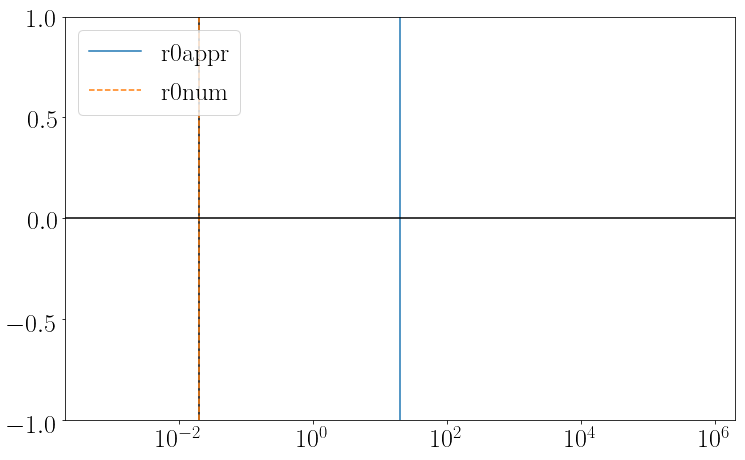

0.02004010027140957


In [12]:
def r0num(potential,alphaX,mX,mphi,l,v,logging=False):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #_____r0_____
    def r0(r):
        #return k**2.-l**2/r**2.+2*m*U(potential,alphaX,mphi,r)
        #print('[term1,term2]='+str([-l**2/r**2.,2*m*U(potential,alphaX,mphi,r)]))
        return (-1.)*(k**2.-l**2/r**2.-2*m*U(potential,alphaX,mphi,r)) 
    r0appr=l/k
    #[r0min,r0max]=[10.**(-5.)*r0appr,10.**(5.)*r0appr]
    #[r0min,r0max]=[10.**(-5.)*r0appr,r0appr]
    #r0num=opt.brentq(r0,r0min,r0max,maxiter=500) #Numerically unstable
    r0vals=np.logspace(np.log10(10.**(-5.)*r0appr),np.log10(10.**5.*r0appr),1000)
    r0index=list(itertools.chain.from_iterable(np.argwhere(r0(r0vals)>0)))[-1] #Find outermost solution
    #print(r0vals[r0index])
    #epsilon=10.**(-1.)
    epsilon=0.1
    [r0min,r0max]=[(1-epsilon)*r0vals[r0index],(1+epsilon)*r0vals[r0index]]
    r0valsnew=np.logspace(np.log10(r0min),np.log10(r0max),10000)
    r_r0Int=interp1d(r0(r0valsnew),r0valsnew,kind='linear')
    r0num=r_r0Int(0.)
    #print(r0num)
    if logging==True:
        print('[r0appr,r0num, Ueff(r0)]='+str([r0appr,r0num, r0(r0num)]))
        #print(l**2/(mX*(v/(2*c*mphi)))**2*1/(4*alphaX*mphi/(mX*(v/c)**2)))
        pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
        #r0vals=np.logspace(np.log10(10.**(-5.)*r0appr),np.log10(10.**5.*r0appr),100)
        pl.plot(r0vals,r0(r0vals),color='black')
        #for r in r0vals:
        #    print([r,r0(r)])
        pl.axvline(r0appr,color='C0',label='r0appr')
        pl.axvline(r0num,color='C1',label='r0num',linestyle='--')
        #pl.axvline(l**2/(mX*(v/(2*c*mphi)))**2*1/(4*alphaX*mphi/(mX*(v/c)**2)), color='red', linestyle='-', label='appr 2')
        #pl.axvline((mX*alphaX - np.sqrt(mX**2*alphaX**2 + 4*k**2))/(2*k**2), color='red', label='r0appr2', linestyle=':')
        #pl.axvline(r0min,color='black',linestyle=':')
        #pl.axvline(r0max,color='black',linestyle=':')
        pl.axhline(0.,color='black')
        pl.legend(loc='upper left')
        pl.xscale('log')
        #pl.yscale('log')
        pl.xlim([r0vals[0],r0vals[-1]])
        pl.ylim([-1.,1.])
        #pl.ylim([-10000.,10000.])
        pl.show()
    return r0num

for beta in [1000]:
    print('beta='+str(beta))
    #for l in [1,8,30,500]:
    for l in [100.]:
        print('l='+str(l))
        #_____Fixed parameters_____
        potential='attractive'
        alphaX=0.1
        mphi=0.1 #GeV.
        #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
        cl = 100
        mX= cl**2*beta/2
        #print(mX)
        v=(0.2/(beta*cl))*c #km/s
        #print(v)
        print(r0num(potential,alphaX,mX,mphi,l,v,logging=True))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


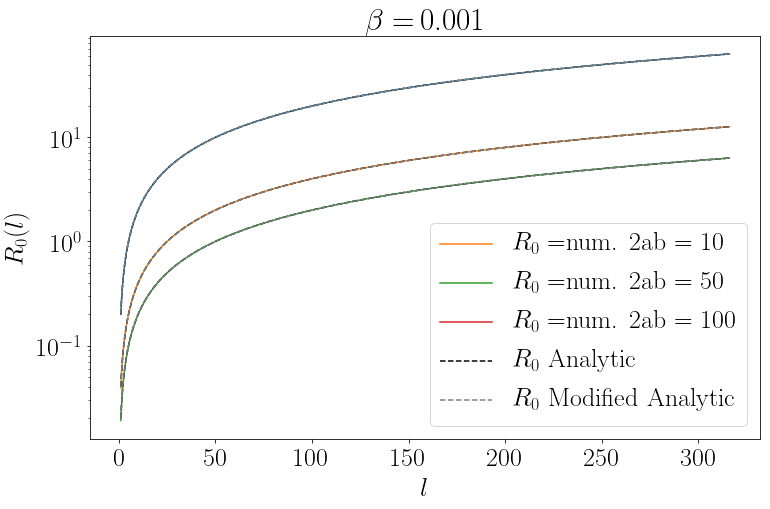

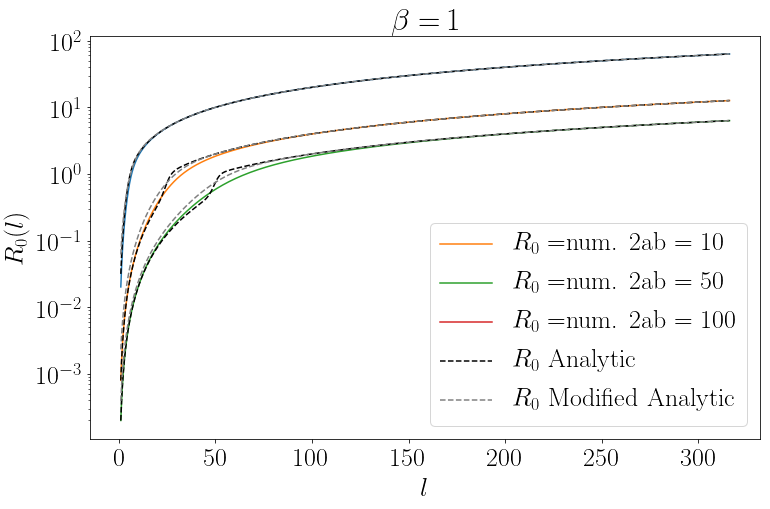

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


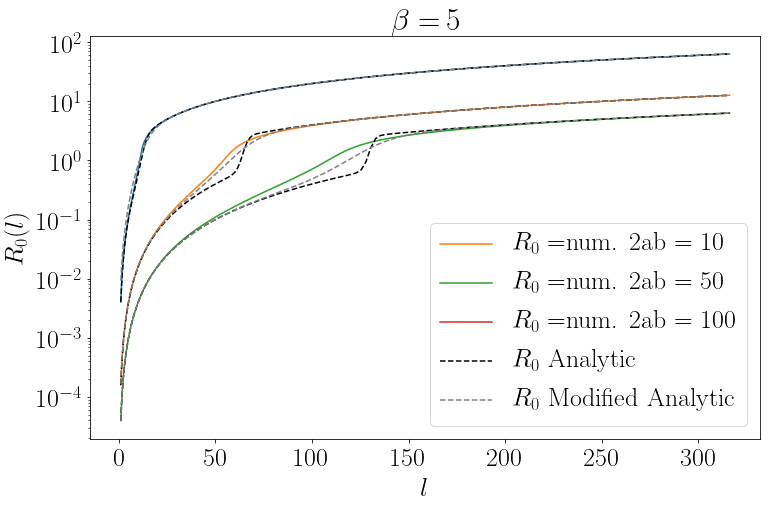

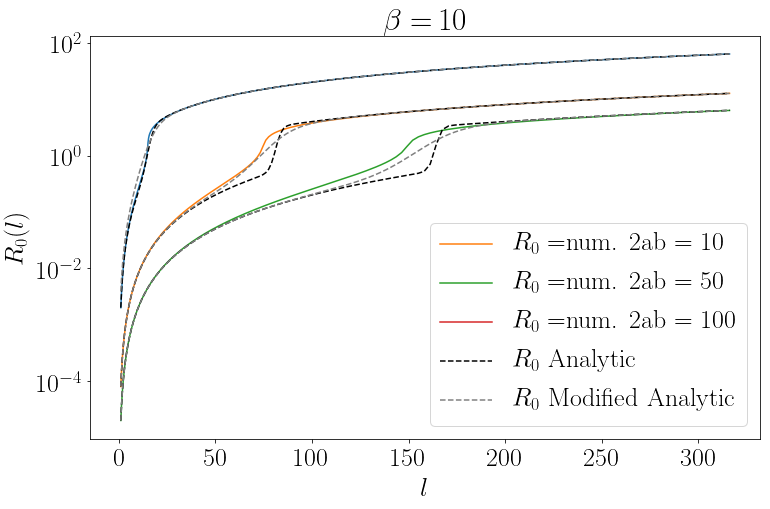

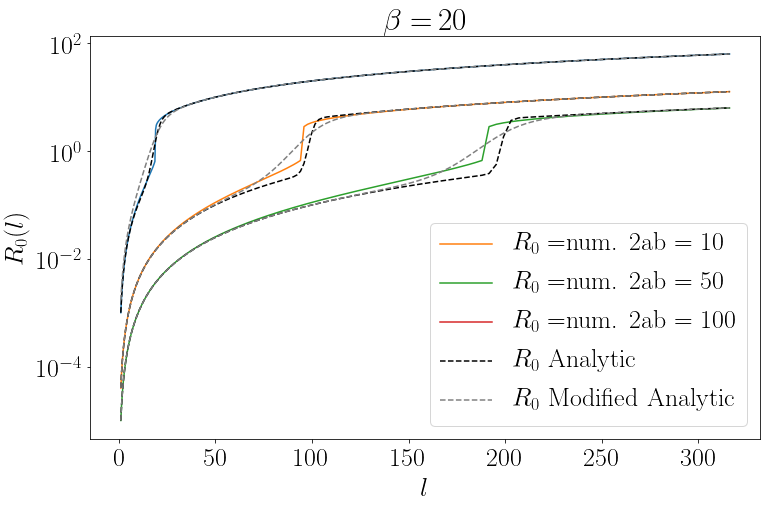

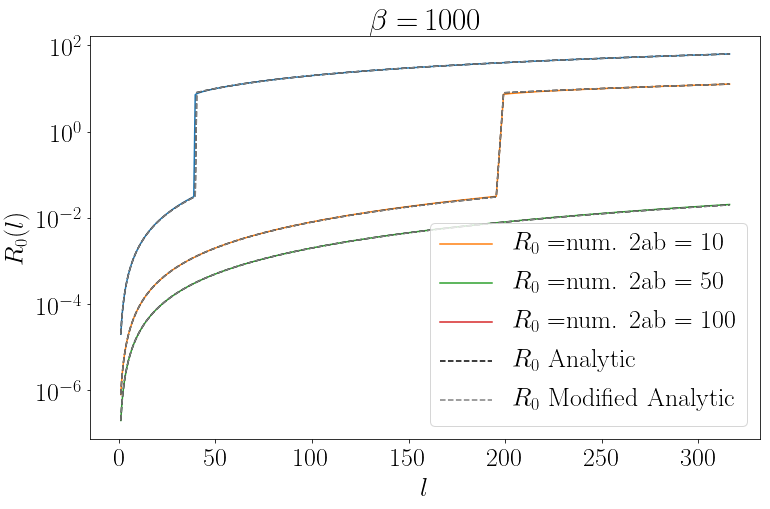

In [105]:
for beta in [0.001,1,5, 10,20,1000]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    #lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
    lvalsnew=np.logspace(0,2.5,300)
    #_____Fixed parameters_____
    for cl in [10, 50,100]:
        potential='attractive'
        a = 1/(beta*cl)
        b = cl**2*beta/2
        mphi=0.1 #GeV.
        alphaX = 0.1
        mX= cl**2*beta/2
        v = 0.2/(beta*cl)*c

    #_____Relations_____
        m=(mX/2.)  #reduced mass m
        p=m*(v/c) #momentum p
        k=p/hbar
        pl.plot(lvalsnew,[mphi*r0num(potential,alphaX,mX,mphi,l,v,logging=False) for l in lvalsnew],'-',label=r'$R_0=$num. 2ab = '+str(cl))
        pl.plot(lvalsnew, [R0_full(a,b,l) for l in lvalsnew], linestyle='--', color = 'black')
        pl.plot(lvalsnew,[R0_full_modified(a,b,l) for l in lvalsnew], linestyle='--', color = 'grey')
        custom_lines = [Line2D([0], [0], color='C1'),Line2D([0], [0], color='C2'),Line2D([0], [0], color='C3'), Line2D([0],[0],linestyle='--',color='black'), Line2D([0],[0],linestyle='--',color='grey')]
        pl.legend(custom_lines, [r'$R_0=$num. 2ab = 10',r'$R_0=$num. 2ab = 50',r'$R_0=$num. 2ab = 100', r'$R_0$ Analytic', r'$R_0$ Modified Analytic'])
        if beta == 5:
            pl.yscale('log')
            pl.xlabel(r'$l$',fontsize=fontsize)
            pl.ylabel(r'$R_{0}(l)$',fontsize=fontsize)
            pl.title(r'$\beta=\,$'+str(beta))
            pl.savefig('Plots/R0_l.pdf')
    pl.yscale('log')
    #pl.ylim(0.01,100)
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.ylabel(r'$R_{0}(l)$',fontsize=fontsize)
    pl.title(r'$\beta=\,$'+str(beta))
    pl.show()

# $\delta_l$

## Approximate analytical solution for $\delta_l$

Approximate $\delta_l$ with $r_0 = l/k$: $\delta_l = \frac{1}{2a}K_0\left(\frac{l}{ab}\right)$

Approximate $\delta_l$ in terms of $r_0$: $\delta_l = \frac{1}{2a}K_0 \left(m_\phi r_0 \right)$

In [31]:
def deltalappr(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=-1.
    elif potential=='repulsive':
        prefactor=+1.
    #_____Variables_____
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #r0=l/k
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    #_____deltalappr_____
    #deltalappr=(-1.)*prefactor*alphaX*(m/hbar**2)*(kn(0.,mphi*r0)/k)
    deltalappr=(-1.)*prefactor*(1./(2.*a))*kn(0.,l/(a*b))
    return deltalappr


def deltalappr_r0(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=-1.
    elif potential=='repulsive':
        prefactor=+1.
    #_____Variables_____
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #r0=l/k
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    r0 = r0_analytic(alphaX,mX,mphi,l,v) 
    #_____deltalappr_____
    #deltalappr=(-1.)*prefactor*alphaX*(m/hbar**2)*(kn(0.,mphi*r0)/k)
    deltalappr_r0=(-1.)*prefactor*(1./(2.*a))*kn(0.,mphi*r0)
    return deltalappr_r0

def deltalappr_r0_modified(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=-1.
    elif potential=='repulsive':
        prefactor=+1.
    #_____Variables_____
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #r0=l/k
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    r0 = r0_analytic_modified(alphaX,mX,mphi,l,v) 
    #_____deltalappr_____
    #deltalappr=(-1.)*prefactor*alphaX*(m/hbar**2)*(kn(0.,mphi*r0)/k)
    deltalappr_r0_modified=(-1.)*prefactor*(1./(2.*a))*kn(0.,mphi*r0)
    return deltalappr_r0_modified    


potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=10
v=10 #km/s
print(deltalappr(potential,alphaX,mX,mphi,l,v))
print(deltalappr_r0(potential,alphaX,mX,mphi,l,v))
print(deltalappr_r0_modified(potential,alphaX,mX,mphi,l,v))

10.439657650303863
933.6238744826524
933.6238744826524


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


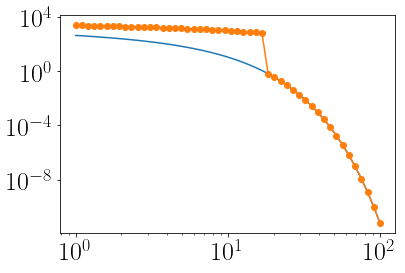

In [32]:
lvals = np.logspace(0,2,50)
pl.figure()
pl.plot(lvals, [deltalappr(potential, alphaX, mX, mphi, l, v) for l in lvals], '-')
pl.plot(lvals, [deltalappr_r0(potential, alphaX, mX, mphi, l, v) for l in lvals], 'o-')
pl.xscale('log')
pl.yscale('log')
pl.show()

## Approximate analytical solution for $\delta_{l+1}-\delta_{l} \sim \frac{d \delta_l}{d l}$

## For $r_0 = \frac{l}{k}$

$\frac{d\delta_l}{dl} = -\frac{1}{2a^2b}K_1\left(\frac{l}{ab}\right)$

In [33]:
def ddeltal_dl_appr(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=+1.
    elif potential=='repulsive':
        prefactor=-1.
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    #_____ddeltal_dl_appr_____
    ddeltal_dl_appr=(-1.)*prefactor*(1./(2.*a**2.*b))*kn(1.,l/(a*b))
    return ddeltal_dl_appr

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1
v=10 #km/s
print(ddeltal_dl_appr(potential,alphaX,mX,mphi,l,v))

-274.8746242028307


In [34]:
#Parameters from Fig.2 in Sean's paper 1302.3898. mX=200 GeV, mphi=1 MeV=10**(-3) GeV, alphaX=10**(-2), v=1000 km/s.
lvals =np.logspace(0,3,10)
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
v=1000. #km/s
ddeltal_dl_apprvals=np.array([ddeltal_dl_appr(potential,alphaX,mX,mphi,l,v) for l in range(1,len(lvals)-1)])
print(ddeltal_dl_apprvals)

[-2.99783801 -1.49880783 -0.99909289 -0.74920957 -0.59926048 -0.4992795
 -0.42785244 -0.3742721 ]


## For $r_0$ = (analytic)

In [96]:
def ddeltal_dl_appr_r0(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=+1.
    elif potential=='repulsive':
        prefactor=-1.
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta = 1/(2*a**2*b)
    if beta <=10:
        x = (l - a*b*(1+np.log(beta)))/(3)
        y = (l*(1+a*l+np.tanh(x) + a*l*np.tanh(-x)))/(2*a*b)
        prefactor1 = 1/(12*a**2*b)*(-3-6*a*l + l*(-1+a*l)*np.cosh(x)**(-2) + (-3+6*a*l*np.tanh(x)))
        return prefactor1*kn(1, y)
    else:
        if l <= a*b*(1+np.log(beta)):
            return -l/(a*b)*kn(1,l**2/b)
        else:
            return -beta*kn(1,l/(a*b))

        
def ddeltal_dl_appr_r0_beta(l, beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return ddeltal_dl_appr_r0(potential,alphaX,mX,mphi,l,v)
    
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1
v=10 #km/s
cl = 2*v/c/(2*alphaX)*alphaX*mX/mphi
beta = 2*alphaX*mphi/(mX*(v/c)**2)
print(ddeltal_dl_appr_r0(potential,alphaX,mX,mphi,l,v))
print(ddeltal_dl_appr_r0_beta(l, beta, cl))
print(ddeltal_dl_appr_r0_beta(10,0.1,10))

-599.5843001637654
-599.5843001637654
-0.013971850666430096


## For $r_0 =$ (analytic modified) 

$\frac{d\delta_l}{dl} = -\frac{b \left(-a l^2 \text{sech}^2\left(\frac{a b \left(\log \left(\frac{1}{2 a^2 b}\right)+1\right)-l}{3 \sqrt{a b}}\right)+3 \sqrt{a b} \left((2 a l-1) \tanh \left(\frac{a b \log \left(\frac{1}{2 a^2 b}\right)+a b-l}{3 \sqrt{a b}}\right)+2 a l+1\right)+l \text{sech}^2\left(\frac{l-a b \left(\log \left(\frac{1}{2 a^2 b}\right)+1\right)}{3 \sqrt{a b}}\right)\right) K_1\left(\frac{l \left(a l+a \tanh \left(\frac{a b \left(\log \left(\frac{1}{2 a^2 b}\right)+1\right)-l}{3 \sqrt{a b}}\right) l+\tanh \left(\frac{l-a b \left(\log \left(\frac{1}{2 a^2 b}\right)+1\right)}{3 \sqrt{a b}}\right)+1\right)}{2 a b}\right)}{12 (a b)^{5/2}}$ for $\beta \leq 10$

$\frac{d\delta_l}{dl} = -\frac{1}{2a^2b}\,K_1\left(\frac{l}{ab}\right)$ for $\beta > 10$ and $l \leq ab\,(1+\log\beta)$

$\frac{d\delta_l}{dl} = -\frac{l}{ab}\,K_1\left(\frac{l^2}{b}\right)$ for $\beta > 10$ and $l > ab\,(1+\log\beta)$

In [39]:
def ddeltal_dl_appr_r0_modified(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=+1.
    elif potential=='repulsive':
        prefactor=-1.
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta = 1/(2*a**2*b)
    if beta <=10:
        x = (l - a*b*(1+np.log(beta)))/(3*np.sqrt(a*b))
        y = (l*(1+a*l+np.tanh(x) + a*l*np.tanh(-x)))/(2*a*b)
        prefactor1 = -b/(12*(a*b)**(5/2))*(l*np.cosh(x)**(-1) - a*l**2*np.cosh(-x)**(-2) + 3*np.sqrt(a*b)*(1+2*a*l+(-1+2*a*l)*np.tanh(-x)))
        return prefactor1*kn(1, y)
    else:
        if l <= a*b*(1+np.log(beta)):
            return -l/(a*b)*kn(1,l**2/b)
        else:
            return -beta*kn(1,l/(a*b))
    
def ddeltal_dl_appr_r0_beta_modified(l, beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return ddeltal_dl_appr_r0_modified(potential,alphaX,mX,mphi,l,v)
    
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1
v=10 #km/s
cl = 2*v/c/(2*alphaX)*alphaX*mX/mphi
beta = 2*alphaX*mphi/(mX*(v/c)**2)
print(ddeltal_dl_appr_r0_modified(potential,alphaX,mX,mphi,l,v))
print(ddeltal_dl_appr_r0_beta_modified(l, beta, cl))
print(ddeltal_dl_appr_r0_beta_modified(10,0.1,10))

-599.5843001637654
-599.5843001637654
-0.01239322359759988


## Numerical solution for $\delta_l$ with $r_0 = l/k$

In [40]:
def deltal(potential,alphaX,mX,mphi,l,v):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #E=(hbar**2.*k**2.)/(2.*m) #kinetic energy
    E=p**2./(2.*m) #kinetic energy
    #_____deltal integral_____
    #def integrand(r):
    #    return -(mX/hbar**2)*(U(potential,alphaX,mphi,r)/np.sqrt(k**2.-((l+1./2.)**2./r**2.)))
    #def integrand(r):
    #    return (1./hbar)*np.sqrt(hbar**2.*k**2.-2.*m*U(potential,alphaX,mphi,r)-(hbar**2.*(l+1./2.)**2.)/r**2.)-k ###Doesn't work well. Numerically very unstable.
    def integrand(r):
        x=1.-(r0**2./r**2)
        #x=k**2.-((l+1./2.)**2./r**2.)
        y=U(potential,alphaX,mphi,r)/(E*c**2)
        #y=2*m*U(potential,alphaX,mphi,r)
        #print([x,y])
        #print([np.sqrt(x-y),np.sqrt(x)])
        #return np.sqrt(x-y)-np.sqrt(x)
        #print([np.sqrt(1-y/x),1.])
        return np.sqrt(x)*(np.sqrt(1-y/x)-1.)
    r0=l/k
    #rmax=10**6 #.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
    rmax=10**2.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
#     #rmax=10.**10.
#     #print([r0,rmax])
#     epsilon=10.**(-8.)
#     rvals=np.logspace(np.log10((1+epsilon)*r0),np.log10(rmax),5000.)
#     integrandvals=np.array([integrand(r) for r in rvals])
#     #print(integrandvals)
#     deltalintegral=np.trapz(integrandvals,x=rvals) #Trapezoidal rule is slower and less accurate.
    logging=False
    if logging:
        print([r0,rmax,rmax/r0])
        pl.xscale('log')
        #pl.yscale('log') 
        Rvals=np.logspace(np.log10(r0),np.log10(rmax),50)
        pl.plot(Rvals,[integrand(r) for r in Rvals])
        pl.show()
        pl.xscale('log')
        #pl.yscale('log')
        pl.plot(Rvals,[U(potential,alphaX,mphi,r) for r in Rvals])
        pl.show()
    #deltal=integrate.quad(integrand,r0,rmax,limit=200)[0] #,limit=200
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,points=r0)[0] #,limit=200
    #deltal=deltalintegral+(1./2.)*np.pi*(l+(1./2.))-k*r0
    #print([deltalintegral,(1./2.)*np.pi*(l+(1./2.))-k*r0])
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,epsabs=5.*10.**(-7.), epsrel=5*10.**(-1.))[0]
    deltalintegral=integrate.quad(integrand,r0,rmax)[0]
    deltal=k*c**2*deltalintegral
    if deltal == 0:
        deltal = deltalappr(potential,alphaX,mX,mphi,l,v)
    return deltal

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1.
v=10. #km/s
print(deltalappr(potential,alphaX,mX,mphi,l,v))
print(deltal(potential,alphaX,mX,mphi,l,v))

411.64339210020086
411.6420355129689


# Numerical solution for $\delta_l$ with $r_0 = r_0$ (num.)

In [41]:
def deltalr0num(potential,alphaX,mX,mphi,l,v):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #E=(hbar**2.*k**2.)/(2.*m) #kinetic energy
    E=p**2./(2.*m) #kinetic energy
    #_____deltal integral_____
    #def integrand(r):
    #    return -(mX/hbar**2)*(U(potential,alphaX,mphi,r)/np.sqrt(k**2.-((l+1./2.)**2./r**2.)))
    #def integrand(r):
    #    return (1./hbar)*np.sqrt(hbar**2.*k**2.-2.*m*U(potential,alphaX,mphi,r)-(hbar**2.*(l+1./2.)**2.)/r**2.)-k ###Doesn't work well. Numerically very unstable.
    def integrand(r):
        x=1.-(r0**2./r**2)
        #x=k**2.-((l+1./2.)**2./r**2.)
        y=U(potential,alphaX,mphi,r)/(E*c**2)
        #y=2*m*U(potential,alphaX,mphi,r)
        #print([x,y])
        #print([np.sqrt(x-y),np.sqrt(x)])
        #return np.sqrt(x-y)-np.sqrt(x)
        #print([np.sqrt(1-y/x),1.])
        return np.sqrt(x)*(np.sqrt(1-y/x)-1.)
    #r0=l/k
    r0=r0num(potential,alphaX,mX,mphi,l,v)
    #rmax=10**6 #.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
    rmax=10**2.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
#     #rmax=10.**10.
#     #print([r0,rmax])
#     epsilon=10.**(-8.)
#     rvals=np.logspace(np.log10((1+epsilon)*r0),np.log10(rmax),5000.)
#     integrandvals=np.array([integrand(r) for r in rvals])
#     #print(integrandvals)
#     deltalintegral=np.trapz(integrandvals,x=rvals) #Trapezoidal rule is slower and less accurate.
    logging=False
    if logging:
        print([r0,rmax,rmax/r0])
        pl.xscale('log')
        #pl.yscale('log') 
        Rvals=np.logspace(np.log10(r0),np.log10(rmax),50)
        pl.plot(Rvals,[integrand(r) for r in Rvals])
        pl.show()
        pl.xscale('log')
        #pl.yscale('log')
        pl.plot(Rvals,[U(potential,alphaX,mphi,r) for r in Rvals])
        pl.show()
    #deltal=integrate.quad(integrand,r0,rmax,limit=200)[0] #,limit=200
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,points=r0)[0] #,limit=200
    #deltal=deltalintegral+(1./2.)*np.pi*(l+(1./2.))-k*r0
    #print([deltalintegral,(1./2.)*np.pi*(l+(1./2.))-k*r0])
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,epsabs=5.*10.**(-7.), epsrel=5*10.**(-1.))[0]
    deltalintegral=integrate.quad(integrand,r0,rmax)[0]
    deltal=k*c**2*deltalintegral
    if deltal == 0:
        deltal = deltalappr(potential,alphaX,mX,mphi,l,v)
    return deltal

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1.
v=10. #km/s
print(deltalappr(potential,alphaX,mX,mphi,l,v))
print(deltal(potential,alphaX,mX,mphi,l,v))
print(deltalr0num(potential,alphaX,mX,mphi,l,v))

411.64339210020086
411.6420355129689
1573.5584834851848


### $\delta_l$ as a function of $\beta$, Cl
Cl $= 2ab$ determines how deep we are in the classical limit

In [42]:
def deltal_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return deltal(potential,alphaX,mX,mphi,l,v)
    
for beta in [1000.]:
    for l in [2]:
        for cl in [10]:
            print(deltal_beta(l,beta, cl))

5572.642713992423


In [43]:
def deltalr0num_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return deltalr0num(potential,alphaX,mX,mphi,l,v)
    
for beta in [1000.]:
    for l in [2]:
        for cl in [10.]:
            print(deltalr0num_beta(l,beta, cl))

26442.901292817984


In [44]:
def deltalappr_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return deltalappr(potential,alphaX,mX,mphi,l,v)

#for beta in [1.,10.,100.,1000.]:
for beta in [1.,1000.]:
    for l in [1]:
        for cl in [10.]:
            print(deltalappr_beta(l,beta,cl))

8.76351927764073
8763.519277640731


In [45]:
def deltalapprr0num(potential,alphaX,mX,mphi,l,v):
    if potential=='attractive':
        prefactor=-1.
    elif potential=='repulsive':
        prefactor=+1.
    #_____Variables_____
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #r0=l/k
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    #_____deltalappr_____
    r0=r0num(potential,alphaX,mX,mphi,l,v)
    #deltalappr=(-1.)*prefactor*alphaX*(m/hbar**2)*(kn(0.,mphi*r0)/k)
    #deltalappr=(-1.)*prefactor*(1./(2.*a))*kn(0.,l/(a*b))
    deltalappr=(-1.)*prefactor*(1./(2.*a))*kn(0.,mphi*r0)
    return deltalappr

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1
v=10 #km/s
print(deltalappr(potential,alphaX,mX,mphi,l,v))
print(deltalapprr0num(potential,alphaX,mX,mphi,l,v))

411.64339210020086
2313.299652757894


In [46]:
def deltalapprr0num_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    ans = deltalapprr0num(potential,alphaX,mX,mphi,l,v)
    return ans


#for beta in [1.,10.,100.,1000.]:
for beta in [1.]:
    for l in [1]:
        for cl in [10.]:
            print(deltalappr_beta(l,beta, cl))
            print(deltalapprr0num_beta(l,beta,cl))

8.76351927764073
20.09259901887871


In [47]:
def deltalappr_r0_beta(l, beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return deltalappr_r0(potential,alphaX,mX,mphi,l,v)
    
for beta in [1]:
    for l in [1]:
        for cl in [10]:
            print(deltalappr_r0_beta(l,beta,cl))

17.843461711324


In [49]:
def deltalappr_r0_modified_beta(l, beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return deltalappr_r0_modified(potential,alphaX,mX,mphi,l,v)
    
for beta in [1]:
    for l in [1]:
        for cl in [10]:
            print(deltalappr_r0_modified_beta(l,beta,cl))

14.50919204372298


# Plotting $\delta_l$ with $l$ in various approximations

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


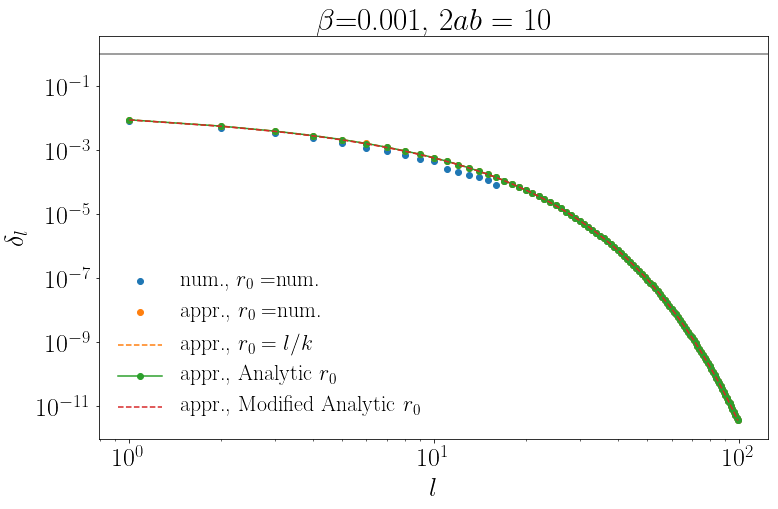

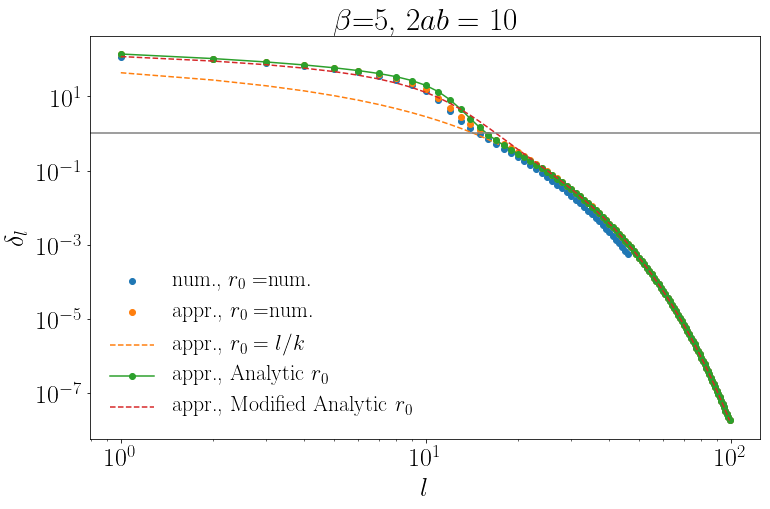

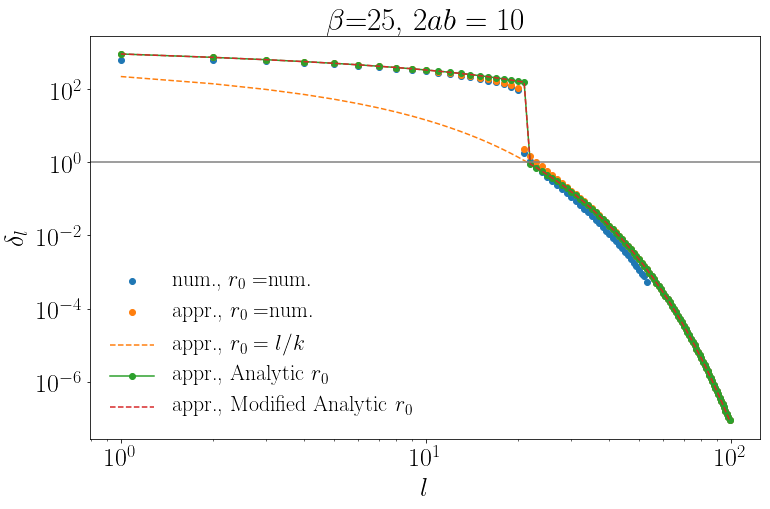

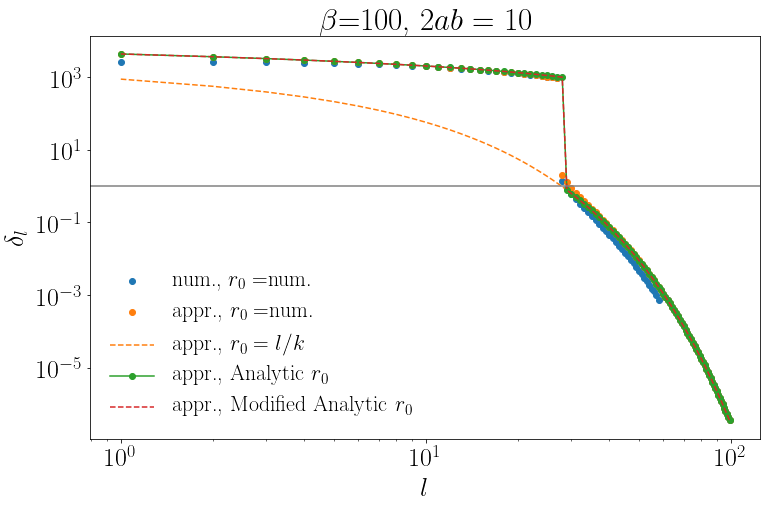

In [52]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)
#fixing cl = 2ab = 10
cl = 10

for beta in [0.001,5,25,100]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    deltalr0num_betavals=np.array([[l,deltalr0num_beta(l,beta,cl)] for l in lvalsnew])
    pl.plot(deltalr0num_betavals[:,0],deltalr0num_betavals[:,1],'o',color='C0',label='num., $r_0=$num.')
    
    #deltal_betavals=np.array([[l,deltal_beta(l,beta, cl)] for l in lvalsnew])
    #pl.plot(deltal_betavals[:,0],deltal_betavals[:,1],color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    pl.plot(lvalsnew,[deltalapprr0num_beta(l,beta, cl) for l in lvalsnew],'o',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[deltalappr_beta(l,beta, cl) for l in lvalsnew],color='C1',linestyle='--',label=r'appr., $r_0=l / k$')
    pl.plot(lvalsnew, [deltalappr_r0_beta(l, beta, cl) for l in lvalsnew], 'o-', color='C2', label=r'appr., Analytic $r_0$')
    pl.plot(lvalsnew, [deltalappr_r0_modified_beta(l, beta, cl) for l in lvalsnew], linestyle='--', color='C3', label=r'appr., Modified Analytic $r_0$')
    
    pl.xscale('log')
    pl.yscale('log')
    pl.axhline(1,color = 'grey')
    pl.xlabel(r'$l$',fontsize=fontsize)
    #pl.ylim([10.**(-3.),10.**5.])
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$\delta_{l}$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) + r', $2ab =$ ' + str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


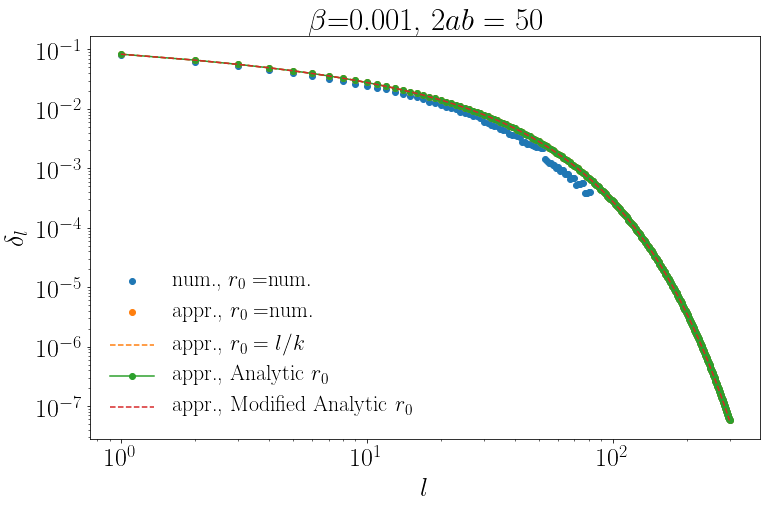

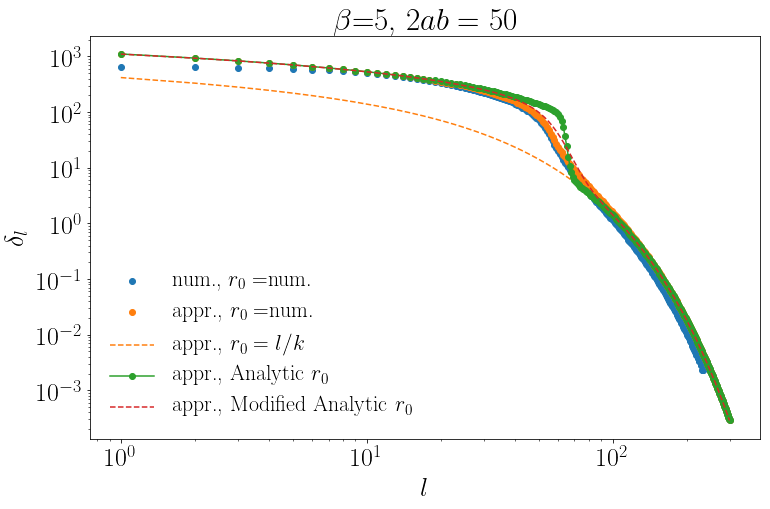

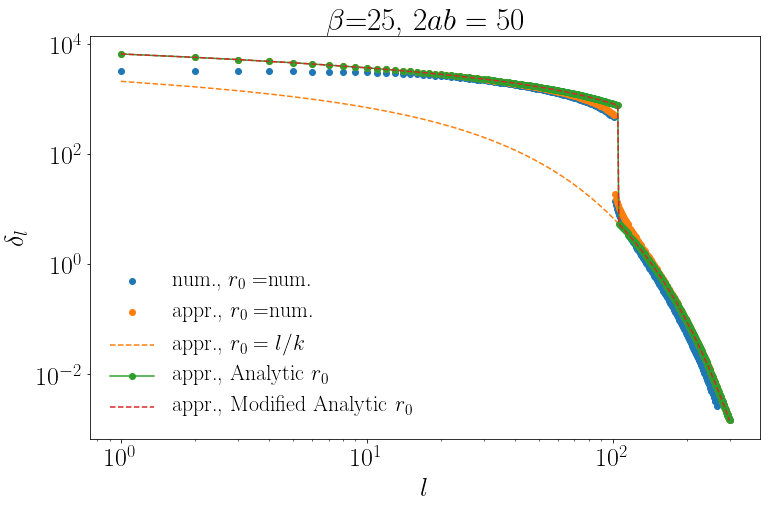

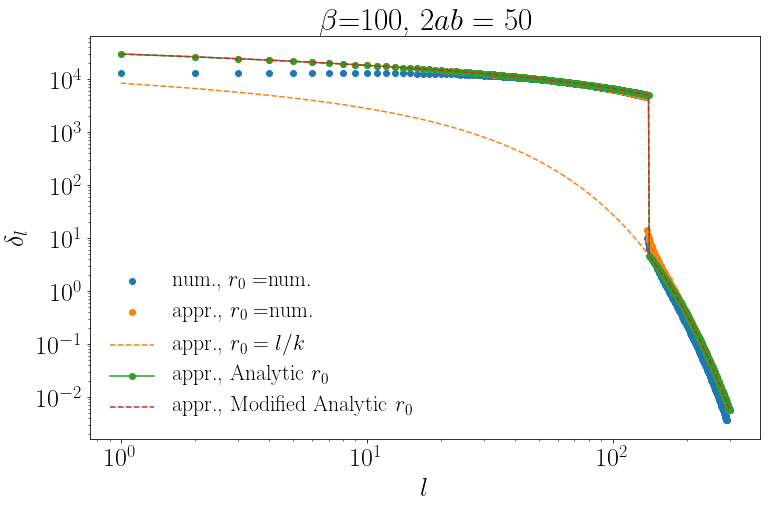

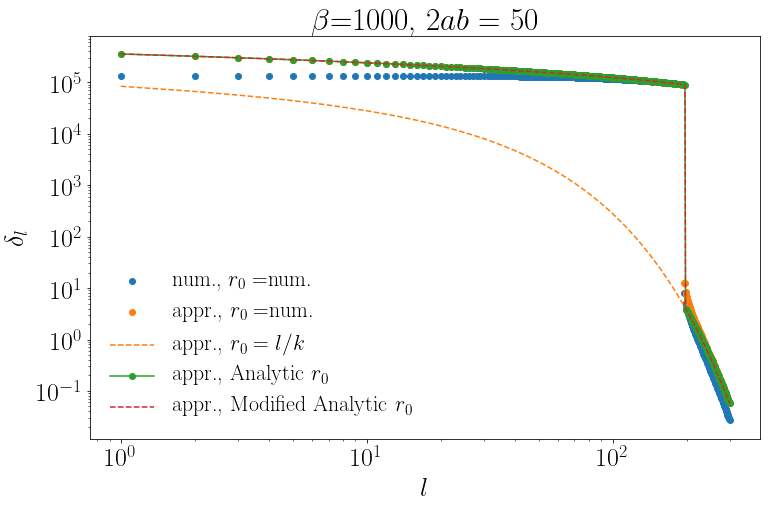

In [53]:
lvalsnew=np.array([l for l in range(1,300)]) #l=1,2,...,1500
#print(lvalsnew)
#fixing cl = 2ab = 10
cl = 50

for beta in [0.001,5,25,100, 1000]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    deltalr0num_betavals=np.array([[l,deltalr0num_beta(l,beta,cl)] for l in lvalsnew])
    pl.plot(deltalr0num_betavals[:,0],deltalr0num_betavals[:,1],'o',color='C0',label='num., $r_0=$num.')
    
    #deltal_betavals=np.array([[l,deltal_beta(l,beta, cl)] for l in lvalsnew])
    #pl.plot(deltal_betavals[:,0],deltal_betavals[:,1],color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    pl.plot(lvalsnew,[deltalapprr0num_beta(l,beta, cl) for l in lvalsnew],'o',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[deltalappr_beta(l,beta, cl) for l in lvalsnew],color='C1',linestyle='--',label=r'appr., $r_0=l / k$')
    pl.plot(lvalsnew, [deltalappr_r0_beta(l, beta, cl) for l in lvalsnew], 'o-', color='C2', label=r'appr., Analytic $r_0$')
    pl.plot(lvalsnew, [deltalappr_r0_modified_beta(l, beta, cl) for l in lvalsnew], linestyle='--', color='C3', label=r'appr., Modified Analytic $r_0$')
    
    pl.xscale('log')
    pl.yscale('log')
    #pl.axhline(1,color = 'grey')
    pl.xlabel(r'$l$',fontsize=fontsize)
    #pl.ylim([10.**(-3.),10.**5.])
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$\delta_{l}$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) + r', $2ab =$ ' + str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

## Numerical solution for d delta_l/ d l

In [30]:
# def ddeltaldl(potential,alphaX,mX,mphi,l,v):
#     #_____deltal_____
#     def deltal_l(l):
#         return deltal(potential,alphaX,mX,mphi,l,v)
#     #_____d deltal/dl_____
#     #epsilon = 10.**(-10.)
#     epsilon = 10.**(-2.) #Inaccurate, derivative depends on choice of epsilon.
#     deltal1=deltal_l((1.-epsilon)*l)
#     deltal2=deltal_l((1.+epsilon)*l)
#     #deltalavg=(deltal1+deltal2)/2. #In principle need to use ddeltaldlavg instead of ddeltaldl to be consistent with derivative, but values are very close.
#     #print([deltal_l(l),deltalavg])
#     ddeltaldl=(deltal2-deltal1)/(2.*epsilon*l)
# #     lvalsnew=np.array([l for l in range(1,1500)]) #l=1,2,...,1500
# #     deltalvals=np.array([deltal_l(l) for l in lvalsnew])
# #     ddeltaldlvals=np.gradient(deltalvals,lvalsnew)
# #     lindex=list(itertools.chain.from_iterable(np.argwhere(lvalsnew==l)))[0]
# #     #print(lindex)
# #     ddeltaldl=ddeltaldlvals[lindex]
#     return ddeltaldl

# potential='attractive' #['attractive','repulsive']:
# alphaX=10.**(-2.)
# mX=200 #GeV
# mphi=10**(-3.) #GeV.
# l=1.
# v=10. #km/s
# print(ddeltaldl(potential,alphaX,mX,mphi,l,v))

In [54]:
def ddeltaldl(potential,alphaX,mX,mphi,lvals,v):
    #_____deltal_____
    def deltal_l(l):
        return deltal(potential,alphaX,mX,mphi,l,v)
    #_____d deltal/dl_____
    deltalvals=np.array([deltal_l(l) for l in lvals])
    ddeltaldlvals=np.gradient(deltalvals,lvals)
    lddeltaldlvals=np.array([[lvals[i],ddeltaldlvals[i]] for i in range(0,len(lvals))])
    return lddeltaldlvals

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
#l=1.
v=10. #km/s
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)
#print(ddeltaldl(potential,alphaX,mX,mphi,lvalsnew,v))

In [55]:
def ddeltaldl_beta(lvals,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return ddeltaldl(potential,alphaX,mX,mphi,lvals,v)
    
for beta in [1.,10.,100.,1000.]:
    for lvals in [lvalsnew]:
        for cl in [10.]:
            print(ddeltaldl_beta(lvals,beta, cl))
        #pl.plot(ddeltaldl_beta(lvals,beta))
        #pl.show()

[[ 1.00000000e+00 -3.07143370e+00]
 [ 2.00000000e+00 -2.32923269e+00]
 [ 3.00000000e+00 -1.28390136e+00]
 [ 4.00000000e+00 -8.18184788e-01]
 [ 5.00000000e+00 -5.57046427e-01]
 [ 6.00000000e+00 -3.94296622e-01]
 [ 7.00000000e+00 -2.86132420e-01]
 [ 8.00000000e+00 -2.11225807e-01]
 [ 9.00000000e+00 -1.57998779e-01]
 [ 1.00000000e+01 -1.19402813e-01]
 [ 1.10000000e+01 -9.10618406e-02]
 [ 1.20000000e+01 -6.96674189e-02]
 [ 1.30000000e+01 -5.36866385e-02]
 [ 1.40000000e+01 -4.16464260e-02]
 [ 1.50000000e+01 -3.22358165e-02]
 [ 1.60000000e+01 -2.53823210e-02]
 [ 1.70000000e+01 -1.97437669e-02]
 [ 1.80000000e+01 -1.53361447e-02]
 [ 1.90000000e+01 -1.21903598e-02]
 [ 2.00000000e+01 -9.51071518e-03]
 [ 2.10000000e+01 -7.40845882e-03]
 [ 2.20000000e+01 -5.95247945e-03]
 [ 2.30000000e+01 -4.84939548e-03]
 [ 2.40000000e+01 -3.73275556e-03]
 [ 2.50000000e+01 -2.79872753e-03]
 [ 2.60000000e+01 -2.31521088e-03]
 [ 2.70000000e+01 -1.87105121e-03]
 [ 2.80000000e+01 -1.54516354e-03]
 [ 2.90000000e+01 -1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [56]:
def ddeltaldlr0num(potential,alphaX,mX,mphi,lvals,v):
    #_____deltal_____
    def deltal_l(l):
        return deltalr0num(potential,alphaX,mX,mphi,l,v)
    #_____d deltal/dl_____
    deltalvals=np.array([deltal_l(l) for l in lvals])
    ddeltaldlvals=np.gradient(deltalvals,lvals)
    lddeltaldlvals=np.array([[lvals[i],ddeltaldlvals[i]] for i in range(0,len(lvals))])
    return lddeltaldlvals

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
#l=1.
v=10. #km/s
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)
#print(ddeltaldlr0num(potential,alphaX,mX,mphi,lvalsnew,v))

In [61]:
def ddeltaldlr0num_beta(lvals,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return ddeltaldlr0num(potential,alphaX,mX,mphi,lvals,v)
    
for beta in [1.,10.,100.,1000.]:
    for lvals in [lvalsnew]:
        for cl in [10.]:
            print(ddeltaldlr0num_beta(lvals,beta, cl))
        #pl.plot(ddeltaldlr0num_beta(lvals,beta))
        #pl.show()

[[ 1.00000000e+00 -6.76237643e+00]
 [ 2.00000000e+00 -5.42955688e+00]
 [ 3.00000000e+00 -3.44326756e+00]
 [ 4.00000000e+00 -2.34555176e+00]
 [ 5.00000000e+00 -1.56103862e+00]
 [ 6.00000000e+00 -9.86903099e-01]
 [ 7.00000000e+00 -6.11574276e-01]
 [ 8.00000000e+00 -3.87483091e-01]
 [ 9.00000000e+00 -2.55035857e-01]
 [ 1.00000000e+01 -1.74159582e-01]
 [ 1.10000000e+01 -1.22569911e-01]
 [ 1.20000000e+01 -8.83132352e-02]
 [ 1.30000000e+01 -6.49044137e-02]
 [ 1.40000000e+01 -4.82966701e-02]
 [ 1.50000000e+01 -3.64727288e-02]
 [ 1.60000000e+01 -2.78973776e-02]
 [ 1.70000000e+01 -2.12608810e-02]
 [ 1.80000000e+01 -1.63927040e-02]
 [ 1.90000000e+01 -1.27972637e-02]
 [ 2.00000000e+01 -9.84341275e-03]
 [ 2.10000000e+01 -7.73186835e-03]
 [ 2.20000000e+01 -6.19362566e-03]
 [ 2.30000000e+01 -4.77545399e-03]
 [ 2.40000000e+01 -3.83060102e-03]
 [ 2.50000000e+01 -3.00049318e-03]
 [ 2.60000000e+01 -2.30751537e-03]
 [ 2.70000000e+01 -1.86525595e-03]
 [ 2.80000000e+01 -1.54059974e-03]
 [ 2.90000000e+01 -1

[[ 1.00000000e+00 -3.01080120e+01]
 [ 2.00000000e+00 -3.84900081e+01]
 [ 3.00000000e+00 -5.71022849e+01]
 [ 4.00000000e+00 -7.72152644e+01]
 [ 5.00000000e+00 -9.65959535e+01]
 [ 6.00000000e+00 -1.15213247e+02]
 [ 7.00000000e+00 -1.33063081e+02]
 [ 8.00000000e+00 -1.50113968e+02]
 [ 9.00000000e+00 -1.66318852e+02]
 [ 1.00000000e+01 -1.81626613e+02]
 [ 1.10000000e+01 -1.95988865e+02]
 [ 1.20000000e+01 -2.09363508e+02]
 [ 1.30000000e+01 -2.21716933e+02]
 [ 1.40000000e+01 -2.33024818e+02]
 [ 1.50000000e+01 -2.43272474e+02]
 [ 1.60000000e+01 -2.52455088e+02]
 [ 1.70000000e+01 -2.60577295e+02]
 [ 1.80000000e+01 -2.67652811e+02]
 [ 1.90000000e+01 -2.73703750e+02]
 [ 2.00000000e+01 -2.78759921e+02]
 [ 2.10000000e+01 -2.82858133e+02]
 [ 2.20000000e+01 -2.86041011e+02]
 [ 2.30000000e+01 -2.88356298e+02]
 [ 2.40000000e+01 -2.89856050e+02]
 [ 2.50000000e+01 -2.90595390e+02]
 [ 2.60000000e+01 -2.90631502e+02]
 [ 2.70000000e+01 -2.90023390e+02]
 [ 2.80000000e+01 -2.88830462e+02]
 [ 2.90000000e+01 -2

In [57]:
def ddeltaldlappr_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return ddeltal_dl_appr(potential,alphaX,mX,mphi,l,v)

#for beta in [1.,10.,100.,1000.]:
for beta in [1.,1000.]:
    for l in [1]:
        for cl in [10.]:
            print(ddeltaldlappr_beta(l,beta, cl))

-4.7759725432204725
-4775.972543220471


In [58]:
def ddeltalapprr0_dl(potential,alphaX,mX,mphi,l,v,r0):
    if potential=='attractive':
        prefactor=+1.
    elif potential=='repulsive':
        prefactor=-1.
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    #_____ddeltal_dl_appr_____
    #ddeltal_dl_appr=(-1.)*prefactor*(1./(2.*a**2.*b))*kn(1.,l/(a*b))
    ddeltalappr_dl=(-1.)*prefactor*(1./(2.*a**2.*b))*kn(1.,mphi*r0)
    return ddeltalappr_dl

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1
v=10 #km/s
m=(mX/2.)  #reduced mass m
p=m*(v/c) #momentum p
k=p/hbar
print(ddeltal_dl_appr(potential,alphaX,mX,mphi,l,v))
print(ddeltalapprr0_dl(potential,alphaX,mX,mphi,l,v,l/k))

-274.8746242028307
-274.87462420283066


In [59]:
def ddeltaldlapprr0num_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    r0=r0num(potential,alphaX,mX,mphi,l,v)
    return ddeltalapprr0_dl(potential,alphaX,mX,mphi,l,v,r0)

#for beta in [1.,10.,100.,1000.]:
for beta in [1.,1000.]:
    for l in [1]:
        for cl in [10.]:
            print(ddeltaldlappr_beta(l,beta,cl))
            print(ddeltaldlapprr0num_beta(l,beta,cl))

-4.7759725432204725
-49.45950003191631
-4775.972543220471
-49999000.36560785


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


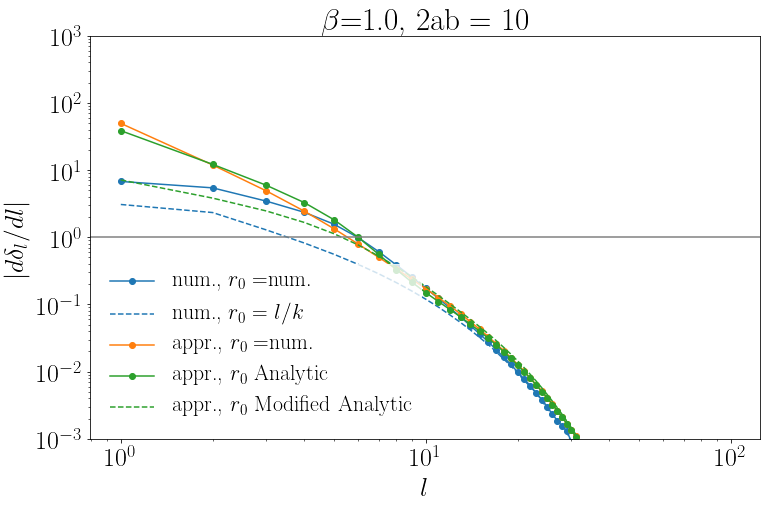

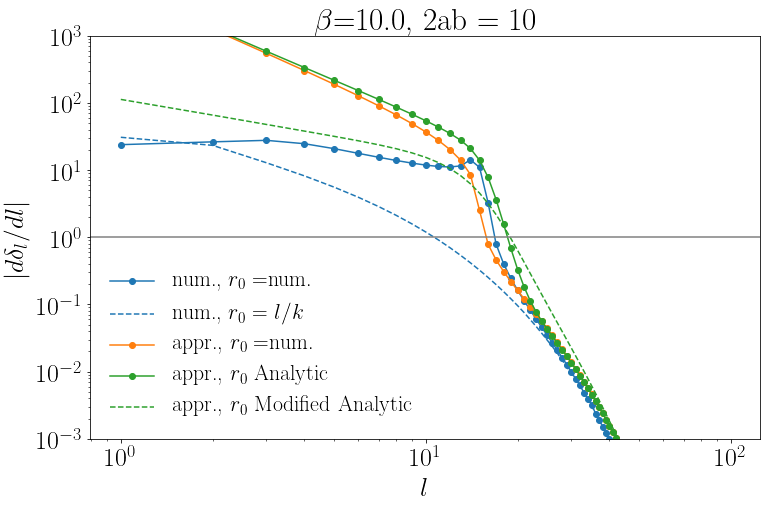

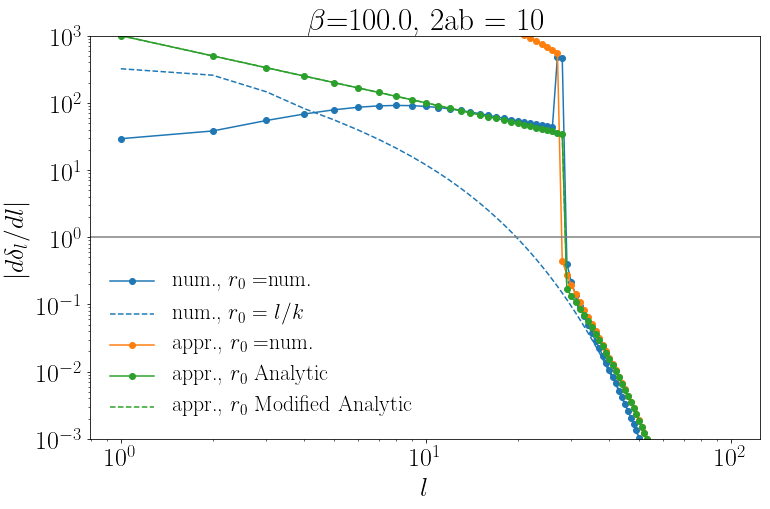

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


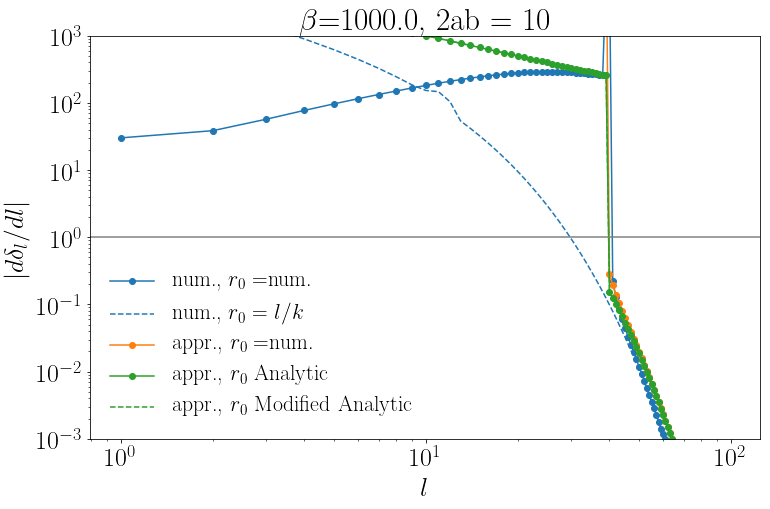

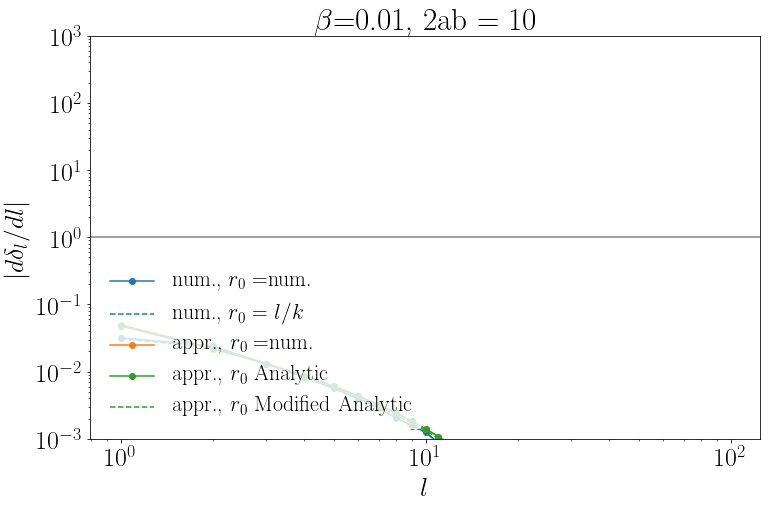

In [97]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#lvalsnew=np.logspace(np.log10(1),np.log10(100),500) #l=1,2,...,1500
#print(lvalsnew)
cl = 10

for beta in [1.,10.,100.,1000.,0.01]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    ddeltaldlr0num_betavals=ddeltaldlr0num_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(ddeltaldlr0num_betavals[:,0],abs(ddeltaldlr0num_betavals[:,1]),'o-',color='C0',label='num., $r_0=$num.')
    
    ddeltaldl_betavals=ddeltaldl_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(ddeltaldl_betavals[:,0],abs(ddeltaldl_betavals[:,1]),color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    pl.plot(lvalsnew,[abs(ddeltaldlapprr0num_beta(l,beta,cl)) for l in lvalsnew],'o-',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[abs(ddeltal_dl_appr_r0_beta(l,beta,cl)) for l in lvalsnew],'o-',color='C2',label=r'appr., $r_0$ Analytic')  

    pl.plot(lvalsnew,[abs(ddeltal_dl_appr_r0_beta_modified(l,beta,cl)) for l in lvalsnew],linestyle='--',color='C2',label=r'appr., $r_0$ Modified Analytic')  
    
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([10.**(-3.),10.**3.])
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.axhline(1,color = 'grey')
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$| d \delta_{l} / d l |$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) + ', 2ab = '+str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


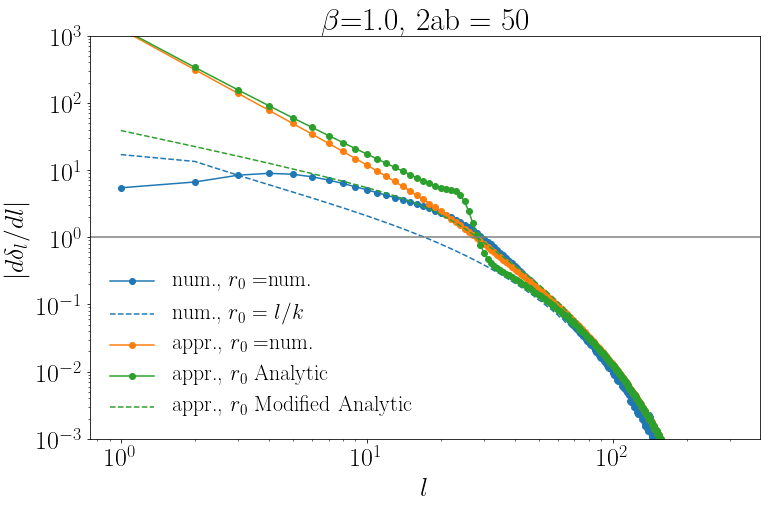

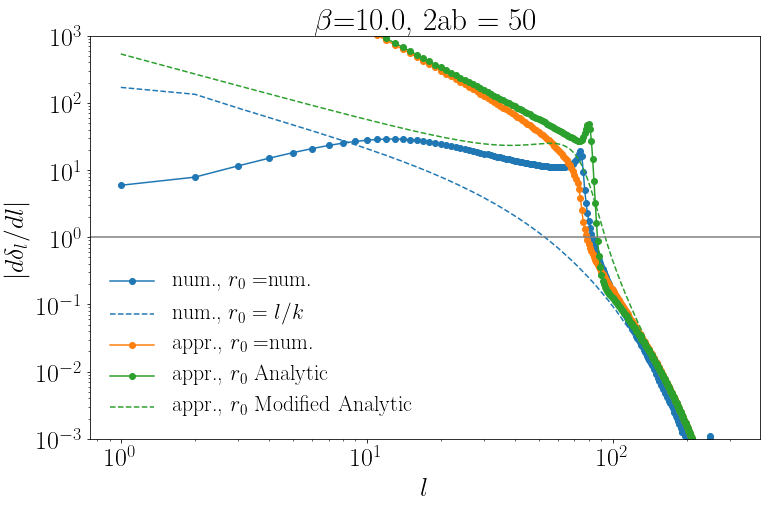

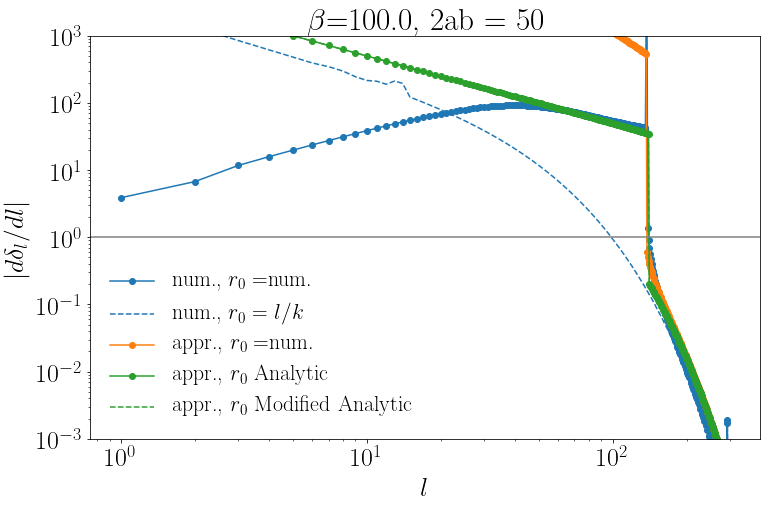

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


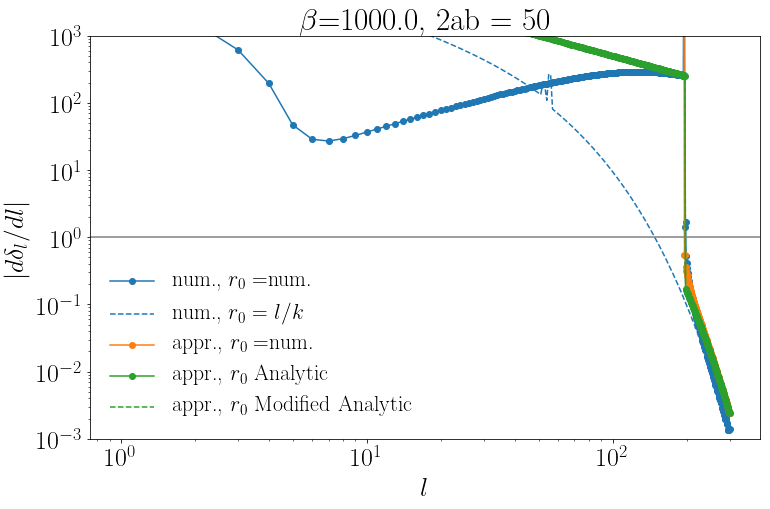

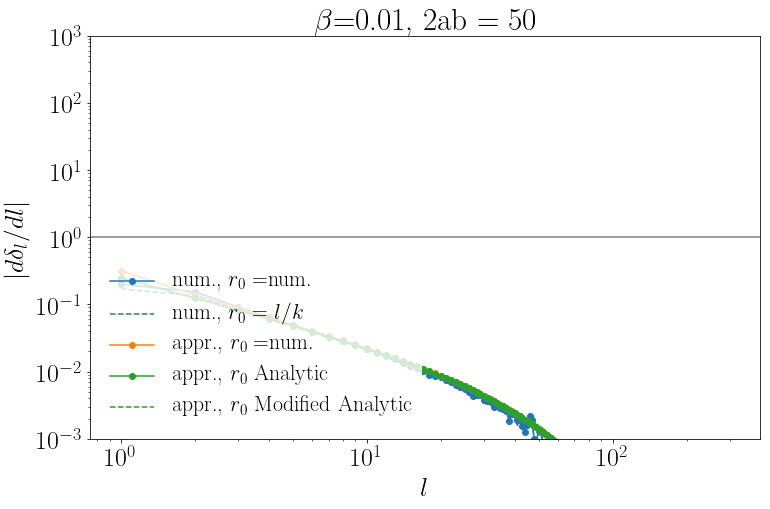

In [98]:
lvalsnew=np.array([l for l in range(1,300)]) #l=1,2,...,1500
#lvalsnew=np.logspace(np.log10(1),np.log10(100),500) #l=1,2,...,1500
#print(lvalsnew)
cl = 50

for beta in [1.,10.,100.,1000.,0.01]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    ddeltaldlr0num_betavals=ddeltaldlr0num_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(ddeltaldlr0num_betavals[:,0],abs(ddeltaldlr0num_betavals[:,1]),'o-',color='C0',label='num., $r_0=$num.')
    
    ddeltaldl_betavals=ddeltaldl_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(ddeltaldl_betavals[:,0],abs(ddeltaldl_betavals[:,1]),color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    pl.plot(lvalsnew,[abs(ddeltaldlapprr0num_beta(l,beta,cl)) for l in lvalsnew],'o-',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[abs(ddeltal_dl_appr_r0_beta(l,beta,cl)) for l in lvalsnew],'o-',color='C2',label=r'appr., $r_0$ Analytic')  
    
    pl.plot(lvalsnew,[abs(ddeltal_dl_appr_r0_beta_modified(l,beta,cl)) for l in lvalsnew],linestyle='--',color='C2',label=r'appr., $r_0$ Modified Analytic')  
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([10.**(-3.),10.**3.])
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.axhline(1,color = 'grey')
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$| d \delta_{l} / d l |$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) + ', 2ab = '+str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


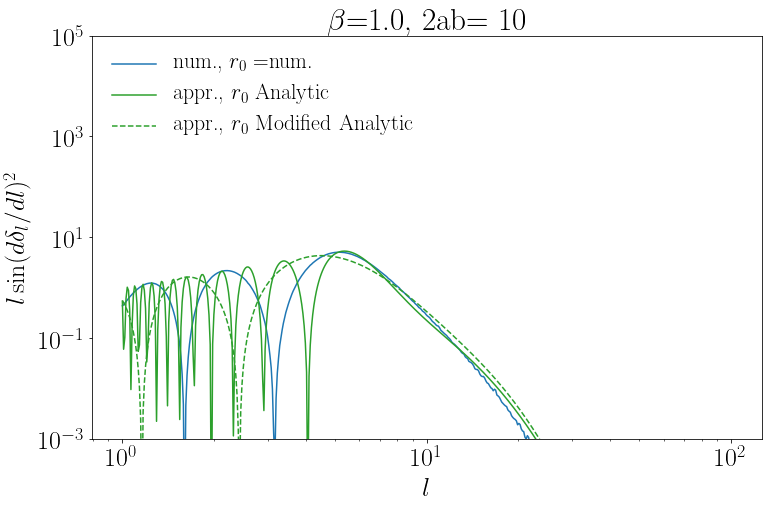

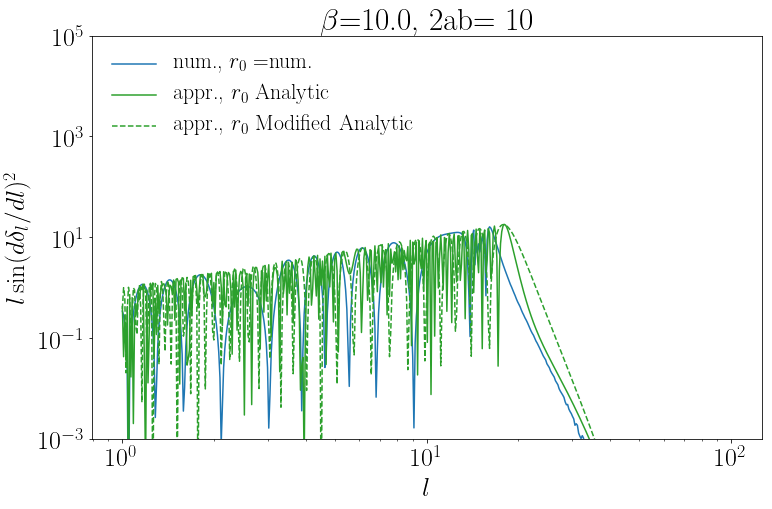

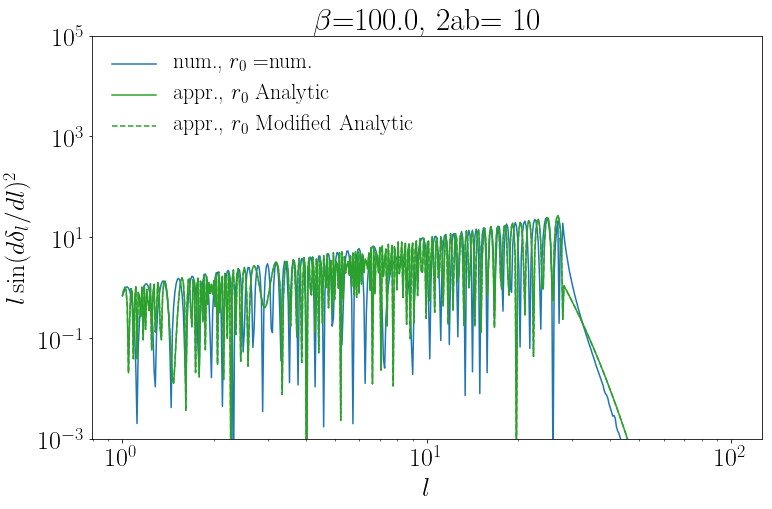

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


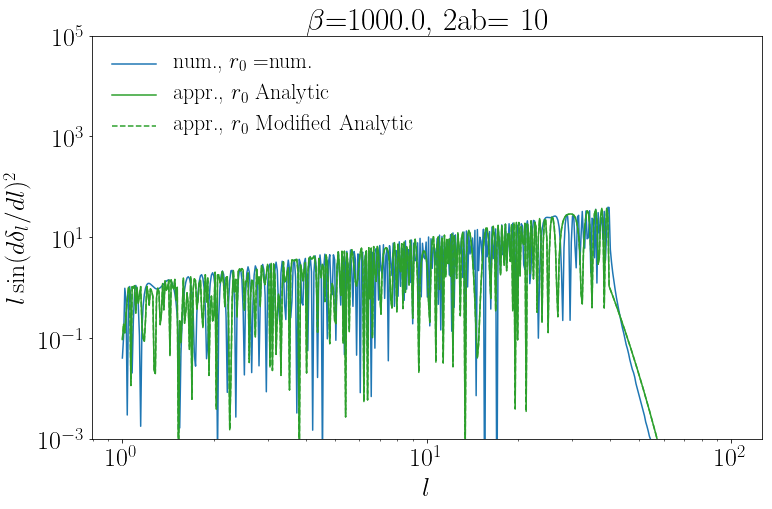

In [99]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
lvalsnew=np.logspace(np.log10(1),np.log10(100),500) #l=1,2,...,1500
#print(lvalsnew)
cl = 10
for beta in [1.,10.,100.,1000.]:
#for beta in [0.01]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    ddeltaldlr0num_betavals=ddeltaldlr0num_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(ddeltaldlr0num_betavals[:,0],ddeltaldlr0num_betavals[:,0]**1.*np.sin(ddeltaldlr0num_betavals[:,1])**2.,'-',color='C0',label='num., $r_0=$num.')
    
    ddeltaldl_betavals=ddeltaldl_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    #pl.plot(ddeltaldl_betavals[:,0],ddeltaldl_betavals[:,0]**1.*np.sin(ddeltaldl_betavals[:,1])**2.,color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    #pl.plot(lvalsnew,[l**1.*np.sin(ddeltaldlapprr0num_beta(l,beta, cl))**2. for l in lvalsnew],'-',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[l**1.*np.sin(ddeltal_dl_appr_r0_beta(l,beta, cl))**2. for l in lvalsnew],'-',color='C2',label=r'appr., $r_0$ Analytic')
    pl.plot(lvalsnew,[l**1.*np.sin(abs(ddeltal_dl_appr_r0_beta_modified(l,beta,cl)))**2 for l in lvalsnew],linestyle='--',color='C2',label=r'appr., $r_0$ Modified Analytic')  
    
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([10.**(-3.),10.**5.])
    pl.xlabel(r'$l$',fontsize=fontsize)
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$l \sin(d \delta_{l} / d l)^2$',fontsize=fontsize) 
    pl.legend(loc='upper left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) +', 2ab= ' + str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

# Transfer cross section sigmaT

## Numerical solution for sigmaT from potential U(r) with r0=l/k

In [69]:
def sigmaT(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    #_____Sum_____
    def deltalnew(l):
        return deltal(potential,alphaX,mX,mphi,l,v)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT
    
def sigmaTm2pi_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>=1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaT(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [10.]:
    for cl in [10.]:
        print(sigmaTm2pi_beta(beta, cl))

8.986234665170459


## sigmaT as a numerical sum using analytical $r_0$

In [74]:
def sigmaT_r0(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    cl = 2*a*b
    k=(c/hbar)*a*b*mphi
    #_____Sum_____
    def deltalnew(l):
        #return deltalappr_r0(potential,alphaX,mX,mphi,l,v)
        return deltalappr_r0_beta(l, beta, cl)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT
    
def sigmaTm2pi_r0_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>=1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaT_r0(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi


for beta in [10.]:
    for cl in [100.]:
        print(sigmaTm2pi_r0_beta(beta,cl))

11.45821673743401


## sigmaT as a numerical sum using modified analytical $r_0$

In [73]:
def sigmaT_r0_modified(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    cl = 2*a*b
    k=(c/hbar)*a*b*mphi
    #_____Sum_____
    def deltalnew(l):
        #return deltalappr_r0(potential,alphaX,mX,mphi,l,v)
        return deltalappr_r0_modified_beta(l, beta, cl)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT
    
def sigmaTm2pi_r0_beta_modified(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>=1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaT_r0_modified(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi


for beta in [10.]:
    for cl in [100.]:
        print(sigmaTm2pi_r0_beta_modified(beta,cl))

15.58312207957497


## Numerical solution for sigmaT from potential U(r) with r0 determined numerically

In [75]:
def sigmaTr0num(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    #_____Sum_____
    def deltalnew(l):
        return deltalr0num(potential,alphaX,mX,mphi,l,v)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT

def sigmaTm2pir0num_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaTr0num(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [1000.]:
    for cl in [10.]:
        print(sigmaTm2pir0num_beta(beta, cl))
        #print(sigmaTm2pi_r0_beta(beta,cl))
        
for beta in [1000.]:
    for cl in [100]:
        print(sigmaTm2pir0num_beta(beta, cl))

78.72992772009357
69.31430140808241


## Numerical cross-section using $\frac{d\delta_l}{dl}$ with analytical $r_0$

In [76]:
def sigmaT_ddeltaldl_r0(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    cl = 2*a*b
    #_____Sum_____
    def ddeltalnew(l):
        return ddeltal_dl_appr_r0_beta(l,beta,cl)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(ddeltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT

def sigmaTm2pi_ddeltaldl_r0_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>=1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaT_ddeltaldl_r0(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [1000.]:
    for cl in [100.]:
        print(sigmaTm2pi_ddeltaldl_r0_beta(beta, cl))

62.19718448689192


## Numerical cross-section using $\frac{d\delta_l}{dl}$ with modified analytical $r_0$

In [78]:
def sigmaT_ddeltaldl_r0_modified(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    cl = 2*a*b
    #_____Sum_____
    def ddeltalnew(l):
        return ddeltal_dl_appr_r0_beta_modified(l,beta,cl)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(ddeltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT

def sigmaTm2pi_ddeltaldl_r0_beta_modified(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>=1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaT_ddeltaldl_r0_modified(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [10.]:
    for cl in [100.]:
        print(sigmaTm2pi_ddeltaldl_r0_beta_modified(beta, cl))

16.6102293610048


## Numerical cross-section using $\frac{d\delta_l}{dl}$ with numerical $r_0$

In [124]:
def sigmaT_ddeltaldl_r0num(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    cl = 2*a*b
    #_____Sum_____
    #ddeltaldlr0num_beta([10.,11.],10,10)[1,1]
    def ddeltalnew(l):
        return ddeltaldlr0num_beta([l,l+1],beta, cl)[1,1]
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1.)*np.sin(ddeltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT

def sigmaTm2pi_ddeltaldl_r0num_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    if int(cl/2)>=1:
        lmax = int(cl/2)*len(lvals)
    else:
        lmax=len(lvals) #len(lvals)=1501
    return (sigmaT_ddeltaldl_r0num(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [10.]:
    for cl in [10.]:
        print(sigmaTm2pi_ddeltaldl_r0num_beta(beta, cl))

15.444282342147106


## Phenomenological fit formula for sigmaT in terms of beta

In [79]:
#_____Classical regime ((v/c)(mX/mphi)>>1 <=> 2ab>>1)_____
#For sigmaTclass see eqns.(7)+(A3) in Sean's paper "Beyond Colisionless DM...", 1302.3898

def sigmaTpheno(potential,alphaX,mX,mphi,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    cl = 2*a*b
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    #k=(c/hbar)*a*b*mphi
    #_____sigmaT_____
    if potential=='repulsive':
        if beta<=1.:
            term=(1./2.)*beta**2.*np.log(1.+(1./beta**2.))
        elif beta>1.:
            term=(1./4.)*(np.log(2.*beta)-np.log(np.log(2.*beta)))**2.
    elif potential=='attractive':
        if beta<=10.**(-1.): 
            term=beta**2.*np.log(1.+(1./beta))
        elif 10.**(-1.)<beta<10.**3.:
            term=2.*(beta**2./(1.+1.5*beta**1.65))
        elif beta>=10.**3.:
            term=(1./4.)*(np.log(beta)+1.-1./(2.*np.log(beta)))**2.
    prefactor=((4.*np.pi)/(mphi*(GeV_to_cmminus1/c))**2.)*(hbar/c)**2
    sigmaTbeta=prefactor*term
    return sigmaTbeta

def sigmaTm2pipheno_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    lmax=len(lvals) #len(lvals)=1501
    return (sigmaTpheno(potential,alphaX,mX,mphi,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [0.1]:
    for cl in [10.]:
        print(sigmaTm2pipheno_beta(beta, cl))

0.09591581091193485


## Approximate analytical solution with different lmin for small and large beta (OLD)

In [80]:
def sigmaTappr_beta(mphi,beta):
    ### No difference between attractive and repulsive case for cross section.
    #if potential=='attractive':
    #    prefactor=+1.
    #elif potential=='repulsive':
    #    prefactor=-1.
    #_____sigmaTappr_____
    prefactor=((2.*np.pi)/(mphi*(GeV_to_cmminus1/c))**2.)*(hbar/c)**2
    b = 50*beta
    if beta<=1:
        #term=2.*beta**4.*(kn(0.,beta)*kn(2.,beta)-kn(1.,beta)**2.)
        #term=beta**4.*(1./(2*beta**2.)-kn(1.,beta)**2.+kn(0.,beta)*kn(2.,beta))
        term = beta**4.*(1./(2*beta**2.) -kn(1.,beta)**2.+kn(0.,beta)*kn(2.,beta))  
    elif beta>1:
        term=beta**2.*abs(prodlog(beta**2.*np.pi))**2./4.*(1./(2*beta**2.)-kn(1.,abs(prodlog(beta**2.*np.pi))/2.)**2.+kn(0.,abs(prodlog(np.pi*beta**2.))/2.)*kn(2.,abs(prodlog(np.pi*beta**2.))/2.))
    sigmaT=prefactor*term
    return sigmaT

def sigmaTm2piappr_beta(beta):
    mphi=0.1 #GeV.
    return (sigmaTappr_beta(mphi,beta)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [100]:
    print(sigmaTm2piappr_beta(beta))

26.563676295404225


## Approximate analytical solution with lmin determined numerically

In [81]:
def r0num(potential,alphaX,mX,mphi,l,v,logging=False):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #_____r0_____
    def r0(r):
        #return k**2.-l**2/r**2.+2*m*U(potential,alphaX,mphi,r)
        #print('[term1,term2]='+str([-l**2/r**2.,2*m*U(potential,alphaX,mphi,r)]))
        return (-1.)*(k**2.-l**2/r**2.-2*m*U(potential,alphaX,mphi,r))
    r0appr=l/k
    #[r0min,r0max]=[10.**(-5.)*r0appr,10.**(5.)*r0appr]
    #[r0min,r0max]=[10.**(-5.)*r0appr,r0appr]
    #r0num=opt.brentq(r0,r0min,r0max,maxiter=500) #Numerically unstable
    r0vals=np.logspace(np.log10(10.**(-5.)*r0appr),np.log10(10.**5.*r0appr),1000)
    r0index=list(itertools.chain.from_iterable(np.argwhere(r0(r0vals)>0)))[-1] #Find outermost solution
    #print(r0vals[r0index])
    epsilon=10.**(-1.)
    #epsilon=10.**(-10.)
    [r0min,r0max]=[(1-epsilon)*r0vals[r0index],(1+epsilon)*r0vals[r0index]]
    #[r0min,r0max]=[epsilon*r0vals[r0index],(1/epsilon)*r0vals[r0index]]
    r0valsnew=np.logspace(np.log10(r0min),np.log10(r0max),10000)
    r_r0Int=interp1d(r0(r0valsnew),r0valsnew,kind='linear')
    r0num=r_r0Int(0.)
    #print(r0num)
    if logging==True:
        print('[r0appr,r0num]='+str([r0appr,r0num]))
        pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
        #r0vals=np.logspace(np.log10(10.**(-5.)*r0appr),np.log10(10.**5.*r0appr),100)
        pl.plot(r0vals,r0(r0vals),color='black')
        #for r in r0vals:
        #    print([r,r0(r)])
        pl.axvline(r0appr,color='C0',label='r0appr')
        pl.axvline(r0num,color='C1',label='r0num')
        #pl.axvline(r0min,color='black',linestyle=':')
        #pl.axvline(r0max,color='black',linestyle=':')
        pl.axhline(0.,color='black')
        pl.legend(loc='upper left')
        pl.xscale('log')
        #pl.yscale('log')
        pl.xlim([r0vals[0],r0vals[-1]])
        pl.ylim([-1.,1.])
        #pl.ylim([-10000.,10000.])
        pl.show()
    return r0num

# for beta in [1000.]:
#     print('beta='+str(beta))
#     for l in [2,41,42]:
#         print('l='+str(l))
#         #_____Fixed parameters_____
#         potential='attractive'
#         alphaX=0.1
#         mphi=0.1 #GeV.
#         #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
#         mX=50.*beta
#         #print(mX)
#         v=(0.02/beta)*c #km/s
#         #print(v)
#         print(r0num(potential,alphaX,mX,mphi,l,v,logging=True))

beta=0.001
[lminappr,lminnum]=[0.005, array(1.29144195e-05)]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


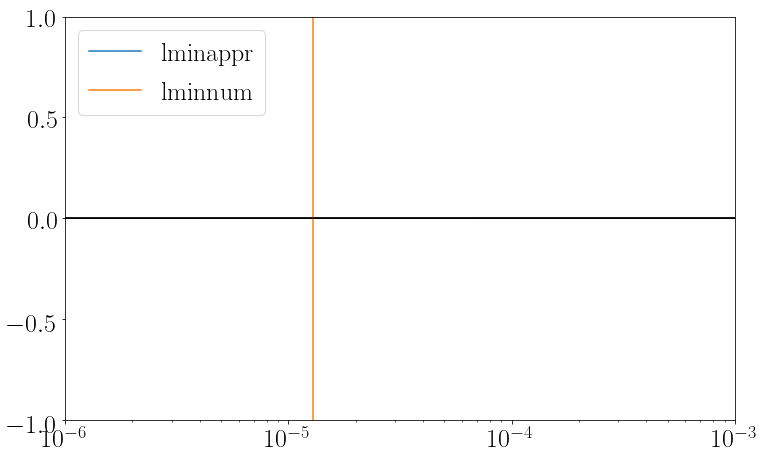

1.2914419478506352e-05
beta=1.0
[lminappr,lminnum]=[5.0, array(0.0129144)]


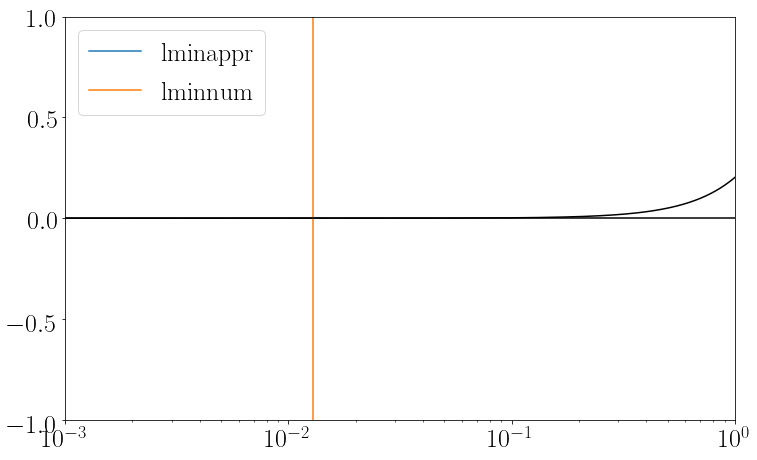

0.01291439788857448
beta=10.0
[lminappr,lminnum]=[50.0, array(0.12914203)]


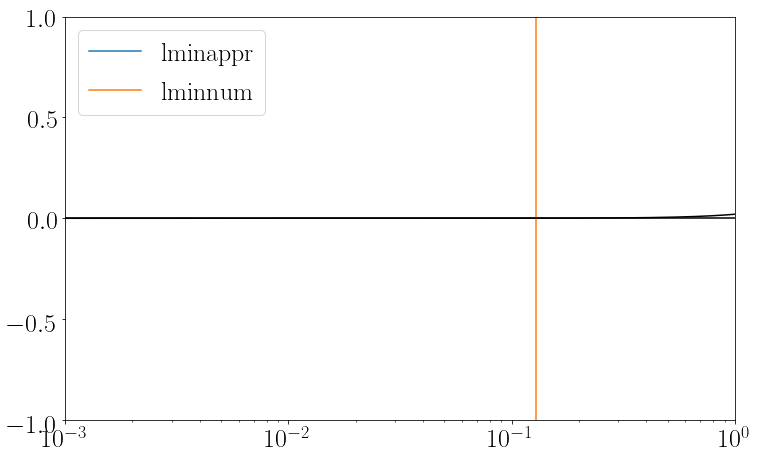

0.12914203388185072
beta=100.0
[lminappr,lminnum]=[500.0, array(1.29122587)]


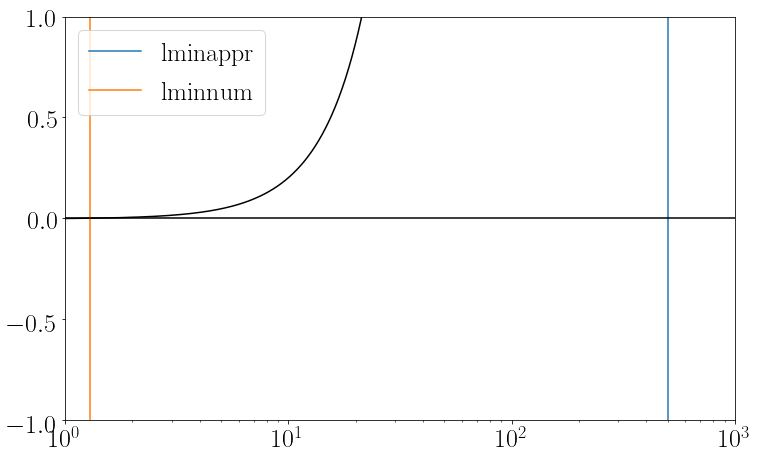

1.29122586897726
beta=1000.0
[lminappr,lminnum]=[5000.0, array(12.89284315)]


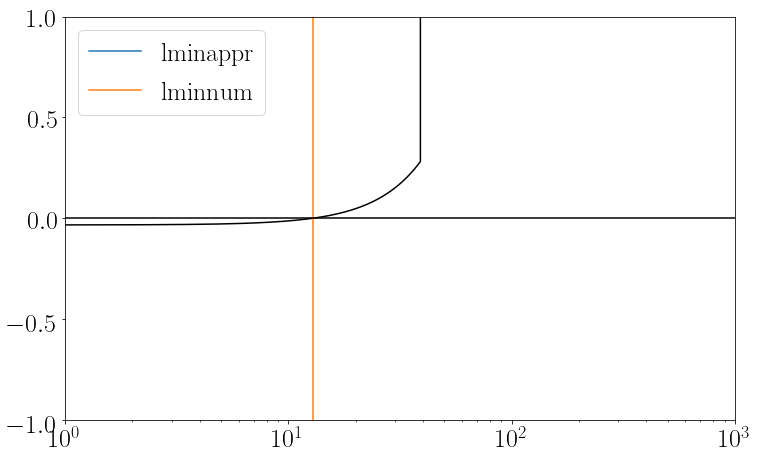

12.89284315071738


In [82]:
def lminnum(potential,alphaX,mX,mphi,v,logging=False):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    lminappr=1/(2.*a)
    #print(lminappr)
    def lmin(l):
        return (r0num(potential,alphaX,mX,mphi,l,v)-beta/((c/hbar)*mphi)) #*(hbar/c)
    if beta<=1.:
        lvals=np.logspace(np.log10(10.**(-6.)),np.log10(10.**(-3.)),1000)
    elif beta<=10.:
        lvals=np.logspace(np.log10(10.**(-3.)),np.log10(1.),1000)
    elif beta>10:
        lvals=np.logspace(np.log10(1.),np.log10(10.**(3.)),1000)
    #lvals=np.linspace(1.,1000.,1000)
    #print(lvals)
    l_lminlInt=interp1d([lmin(l) for l in lvals],lvals,kind='linear')
    lminnum=l_lminlInt(0.)
    #print(lminnum)
    if logging==True:
        print('[lminappr,lminnum]='+str([lminappr,lminnum]))
        #for l in lvals:
        #    print([l,lminappr,lmin(l)])
        pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
        pl.plot(lvals,[lmin(l) for l in lvals],color='black')
        pl.axvline(lminappr,color='C0',label='lminappr')
        pl.axvline(lminnum,color='C1',label='lminnum')
        pl.axhline(0.,color='black')
        pl.legend(loc='upper left')
        pl.xscale('log')
        #pl.yscale('log')
        pl.xlim([lvals[0],lvals[-1]])
        pl.ylim([-1.,1.])
        #pl.ylim([-10000.,10000.])
        pl.show()
    return lminnum
    
for beta in [10.**(-3.),1.,10.,100.,1000.]:
    print('beta='+str(beta))
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta)*c #km/s
    #print(v)
    print(lminnum(potential,alphaX,mX,mphi,v,logging=True))

In [83]:
def sigmaTappr_lmin(alphaX,mX,mphi,v,lmin,lmax):
    ### No difference between attractive and repulsive case for cross section.
    #if potential=='attractive':
    #    prefactor=+1.
    #elif potential=='repulsive':
    #    prefactor=-1.
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    k=(c/hbar)*a*b*mphi
    #_____sigmaT_appr_____
    xmin=lmin/(a*b)
    xmax=lmax/(a*b)
    def term(x):
        return x*kn(0.,x)**2.-x*kn(1.,x)**2.+2.*kn(0.,x)*kn(1.,x)
    def term(x):
        return (x/2.)*(x*kn(0.,x)**2.-x*kn(1.,x)**2.+2.*kn(0.,x)*kn(1.,x))
    sigmaT_appr=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)*(1./(4.*a**2.))*(term(xmin)-term(xmax))
    return sigmaT_appr

def sigmaTappr_lmin_beta(beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #lmin=1 #lmin cannot be 0 here because r0=l/k.
    lmin=lminnum(potential,alphaX,mX,mphi,v,logging=False)
    lmax=len(lvals) #len(lvals)=1501
    return (sigmaTappr_lmin(alphaX,mX,mphi,v,lmin,lmax)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [100.]:
    for cl in [10.]:
        print(sigmaTappr_lmin_beta(beta, cl))

42045.60314034697


## Updated phenomenological formula from Bringmann et al

In [84]:
def sigmaTmphi2pi_pheno_Bringmann(beta):
    if beta <= 0.01:
        return 2*beta**2*np.log(1 + beta**-2.)
    elif 0.01 < beta <= 100:
        return 7*(beta**1.8 + 280*(beta/10)**10.3)/(1 + 1.4*beta + 0.006*beta**4 + 160*(beta/10)**10)
    elif beta > 100:
        return 0.81*(1+np.log(beta)-(2*np.log(beta))**-1)**2

print(sigmaTmphi2pi_pheno_Bringmann(0.01))

0.0018420880733953035


## Plotting $\frac{\sigma_T \,m_\phi^2}{\pi}$ as a function of $\beta$ 

In [85]:
def sigmamPhi2_Analytical(beta):
    if beta <= 1:
        return 2*np.pi*beta**4*(1/beta**2 - kn(1,beta)**2 + kn(0,beta)*kn(2,beta))
    if beta > 1:
        return np.pi*beta**2*abs(prodlog(beta**2*np.pi))**2/2*(1/beta**2 - kn(1,abs(prodlog(beta**2*np.pi))/2)**2 + kn(0,abs(prodlog(np.pi*beta**2))/2)*kn(2,abs(prodlog(np.pi*beta**2))/2))

In [86]:
betamin=10.**(-4.)
betamax=10.**(3.)
betavals=np.logspace(np.log10(betamin),np.log10(betamax),50)
print(betavals)

[1.00000000e-04 1.38949549e-04 1.93069773e-04 2.68269580e-04
 3.72759372e-04 5.17947468e-04 7.19685673e-04 1.00000000e-03
 1.38949549e-03 1.93069773e-03 2.68269580e-03 3.72759372e-03
 5.17947468e-03 7.19685673e-03 1.00000000e-02 1.38949549e-02
 1.93069773e-02 2.68269580e-02 3.72759372e-02 5.17947468e-02
 7.19685673e-02 1.00000000e-01 1.38949549e-01 1.93069773e-01
 2.68269580e-01 3.72759372e-01 5.17947468e-01 7.19685673e-01
 1.00000000e+00 1.38949549e+00 1.93069773e+00 2.68269580e+00
 3.72759372e+00 5.17947468e+00 7.19685673e+00 1.00000000e+01
 1.38949549e+01 1.93069773e+01 2.68269580e+01 3.72759372e+01
 5.17947468e+01 7.19685673e+01 1.00000000e+02 1.38949549e+02
 1.93069773e+02 2.68269580e+02 3.72759372e+02 5.17947468e+02
 7.19685673e+02 1.00000000e+03]


In [87]:
cl = 10; #fixing 2ab = 10

#numerical \delta_l with r_0 = l/k, numerical sum
sigmaTm2pi_betavals=np.array([[beta,sigmaTm2pi_beta(beta, cl)] for beta in betavals]) 

#numerical r_0, numerical \delta_l, numerical sum
sigmaTm2pir0num_betavals=np.array([[beta,sigmaTm2pir0num_beta(beta, cl)] for beta in betavals])

#analytic expression for r0, \delta_l but numerical sum (\delta_l+1-\delta_l):
sigmaTm2pi_r0_betavals=np.array([[beta,sigmaTm2pi_r0_beta(beta, cl)] for beta in betavals])

#modified analytic expression for r0, \delta_l but numerical sum (\delta_l+1-\delta_l)
sigmaTm2pi_r0_modified_betavals=np.array([[beta,sigmaTm2pi_r0_beta_modified(beta, cl)] for beta in betavals])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [188]:
cl = 100; #fixing 2ab = 100

#numerical \delta_l with r_0 = l/k, numerical sum
sigmaTm2pi_betavals100=np.array([[beta,sigmaTm2pi_beta(beta, cl)] for beta in betavals]) 

#numerical r_0, numerical \delta_l, numerical sum BREAKS DOWN FOR 2ab > 10 and beta > 1000 FIX THIS!!!
sigmaTm2pir0num_betavals100=np.array([[beta,sigmaTm2pir0num_beta(beta, cl)] for beta in betavals])

#analytic expression for r0, \delta_l but numerical sum (\delta_l+1-\delta_l):
sigmaTm2pi_r0_betavals100=np.array([[beta,sigmaTm2pi_r0_beta(beta, cl)] for beta in betavals])

#modified analytic expression for r0, \delta_l but numerical sum (\delta_l+1-\delta_l)
sigmaTm2pi_r0_modified_betavals100=np.array([[beta,sigmaTm2pi_r0_beta_modified(beta, cl)] for beta in betavals])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [125]:
cl = 10
#numerical cross-section using sin(d\delta_l/dl) with analytic r0
sigmaTm2phi_ddeltaldl_betavals = np.array([[beta,sigmaTm2pi_ddeltaldl_r0_beta(beta, cl)] for beta in betavals]) 

#numerical cross-section using sin(d\delta_l/dl) with modified analytic r0
sigmaTm2phi_ddeltaldl_modified_betavals = np.array([[beta,sigmaTm2pi_ddeltaldl_r0_beta_modified(beta, cl)] for beta in betavals]) 


#numerical cross-section using sin(d\delta_l/dl) with numerical r0
sigmaTm2phi_ddeltaldl_r0num_betavals = np.array([[beta, sigmaTm2pi_ddeltaldl_r0num_beta(beta, cl)] for beta in betavals])

In [161]:
print(sigmaTm2pi_r0_beta(10, 10))
print(sigmaTm2pi_r0_beta(10.5, 10))
print(sigmaTm2pi_r0_beta(11, 10))

16.326757102366855
15.58308731032147
18.176560754369692


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


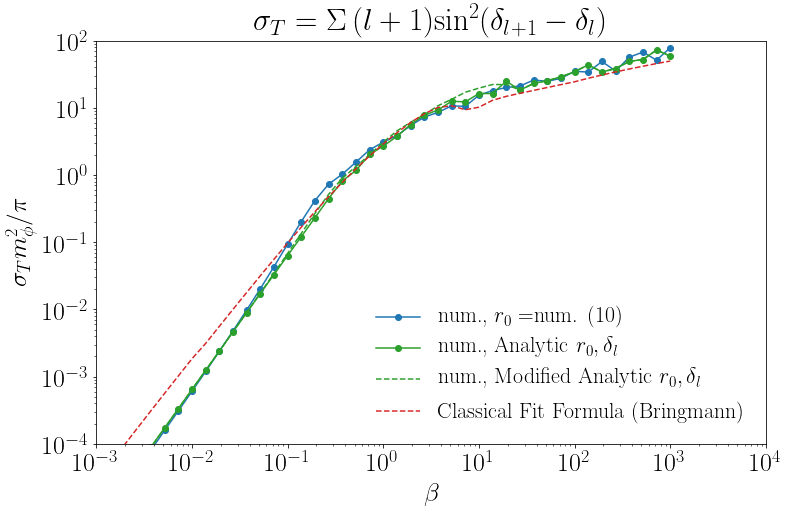

In [110]:
pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.

pl.plot(sigmaTm2pir0num_betavals[:,0],sigmaTm2pir0num_betavals[:,1],'o-',color='C0',label='num., $r_0=$num. (10)')
#pl.plot(betavals,[sigmaTm2pir0num_beta(beta, 30) for beta in betavals],'o-',label='num., $r_0=$num. (30)')
#pl.plot(betavals,[sigmaTm2pir0num_beta(beta, 100) for beta in betavals],'o-',label='num., $r_0=$num.(100)')

pl.plot(sigmaTm2pi_r0_betavals[:,0],sigmaTm2pi_r0_betavals[:,1],'o-', color='C2',label='num., Analytic $r_0,\\delta_l$')
#pl.plot(10.5, sigmaTm2pi_r0_beta(10.5,10), color='C2')
#pl.plot(betavals,[sigmaTm2pi_r0_beta(beta, 30) for beta in betavals],'o-', color='C2',label='num., Analytic $r_0,\\delta_l$ 30')
#pl.plot(betavals,[sigmaTm2pi_r0_beta(beta, 100) for beta in betavals],'o-', color='C2',label='num., Analytic $r_0,\\delta_l$ 100')
#pl.plot(sigmaTm2pi_betavals[:,0], sigmaTm2pi_betavals[:,1], '--', color = 'C4', label='num., $r_0 = l/k$')

#pl.plot(betavals,[sigmaTm2pi_ddeltaldl_r0_beta(beta, 10) for beta in betavals], linestyle='--', label='num. Analytic $r_0\ d\delta_l/dl$')
pl.plot(sigmaTm2pi_r0_modified_betavals[:,0], sigmaTm2pi_r0_modified_betavals[:,1], linestyle='--', color='C2', label='num., Modified Analytic $r_0,\\delta_l$')

pl.plot(betavals,[sigmaTmphi2pi_pheno_Bringmann(beta) for beta in betavals], color = 'C3', linestyle = '--', label = 'Classical Fit Formula (Bringmann)')

pl.xscale('log')
pl.yscale('log')
#pl.xlim([betamin,betamax])
pl.xlim(1e-3,1e4)
#pl.ylim([10.**(-8.),200.])
pl.ylim([1e-4,100.])
pl.xlabel(r'$\beta$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_{T} m_{\phi}^2 / \pi$',fontsize=fontsize) 
pl.legend(loc='lower right',edgecolor='white',fontsize=legendfontsize) 
#pl.axhline(sigmaTm2pi_r0_beta(9,10), color ='grey')
#pl.axvline(9, color='grey')
#pl.legend(bbox_to_anchor=(1,1))
#pl.axvline(9, color='grey')
#pl.axvline(0.02, color='grey')
#pl.tight_layout()
pl.title(r'$\sigma_T = \Sigma \,(l+1)\mathrm{sin}^2(\delta_{l+1}-\delta_l)$')
#pl.savefig('Plots/sigmaTm2phi_num.pdf')
pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


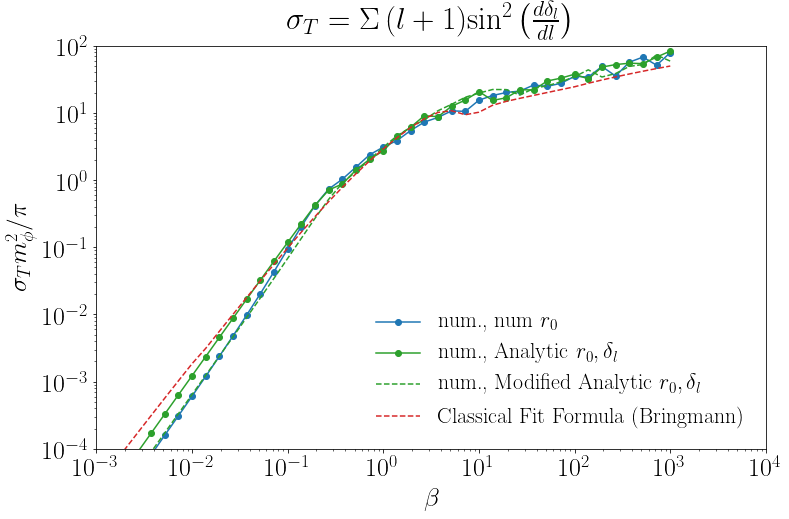

In [129]:
pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.

pl.plot(sigmaTm2phi_ddeltaldl_r0num_betavals[:,0],sigmaTm2phi_ddeltaldl_r0num_betavals[:,1], 'o-', color='C0', label='num., num $r_0$')

pl.plot(sigmaTm2phi_ddeltaldl_betavals[:,0],sigmaTm2phi_ddeltaldl_betavals[:,1],'o-', color='C2',label='num., Analytic $r_0,\\delta_l$')

pl.plot(sigmaTm2pi_r0_modified_betavals[:,0], sigmaTm2pi_r0_modified_betavals[:,1], linestyle='--', color='C2', label='num., Modified Analytic $r_0,\\delta_l$')

pl.plot(betavals,[sigmaTmphi2pi_pheno_Bringmann(beta) for beta in betavals], color = 'C3', linestyle = '--', label = 'Classical Fit Formula (Bringmann)')

pl.xscale('log')
pl.yscale('log')
#pl.xlim([betamin,betamax])
pl.xlim(1e-3,1e4)
#pl.ylim([10.**(-8.),200.])
pl.ylim([1e-4,100.])
pl.xlabel(r'$\beta$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_{T} m_{\phi}^2 / \pi$',fontsize=fontsize) 
pl.legend(loc='lower right',edgecolor='white',fontsize=legendfontsize) 
#pl.axhline(sigmaTm2pi_r0_beta(9,10), color ='grey')
#pl.axvline(9, color='grey')
#pl.legend(bbox_to_anchor=(1,1))
#pl.axvline(9, color='grey')
#pl.axvline(0.02, color='grey')
#pl.tight_layout()
pl.title(r'$\sigma_T = \Sigma \,(l+1)\mathrm{sin}^2\left(\frac{d\delta_l}{dl}\right)$')
#pl.savefig('Plots/sigmaTm2phi_num_ddeltaldl.pdf')
pl.show()

# Ignore everything below this line!

In [69]:
#np.savetxt('testarray2.dat', testarray2)

In [70]:
#The fully numerical cross-section differs from the one where r0 is calculated using l/k in the regime 0.01< \beta<100
#which is curiously also the range where this bump appears. So maybe it does make sense to break the formula into 3
#pieces instead of 2? I'm still not sure why the low beta limit doesn't match with the classical formula and why our 
#analytical formula works. 

#Go back to the beginning and look at all the assumptions

In [71]:
#The reason that the numerical approach breaks down at small \beta is that the phase shift integral breaks down for
#important l values and \delta_l evaluates to zero, giving a reduced cross-section. It might even be that this same 
#effect is also important at large \beta values and so the "matching" of solutions is just a coincidence and the cross
#section ends up being larger even in the numerical approach. Although from the plot it appears that the cross-section
#in this case would be dominated by low l's (and just be proportional to l**2)?? 
#Including higher l's doesn't change the result at all :( 
#Why does the low beta limit of the cross-section differ this much from the approximate solution? 

In [72]:
#The low beta region where  the numerical results differ from the approximate solution is also the region where the 
#interpolated results (from Sean's data) differ from the classical fit formula! It appears that the classical fit 
#formula breaks down in this region! Which also means our analytical formula is wrong. (tested for beta=0.01, a=10,b=.5)


In [73]:
print('sigmaNum = ' + str(sigmaTm2pir0num_beta(0.01)))
print('sigmaPheno = '+str(sigmaTm2pipheno_beta(0.01)))
print('Error = ' + str(abs(sigmaTm2pir0num_beta(0.01)- sigmaTm2pipheno_beta(0.01))/sigmaTm2pipheno_beta(0.01)))

sigmaNum = 0.0006044807033656061
sigmaPheno = 0.0018460482067365039
Error = 0.6725542154534392


# What happens at small $\beta$

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


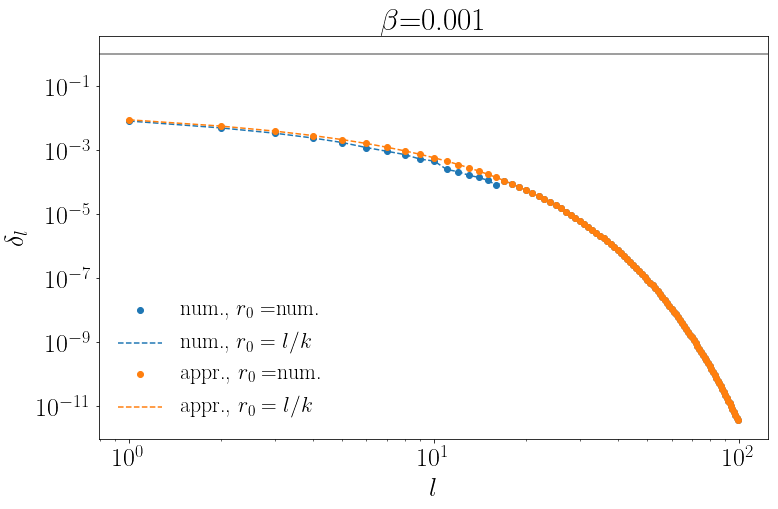

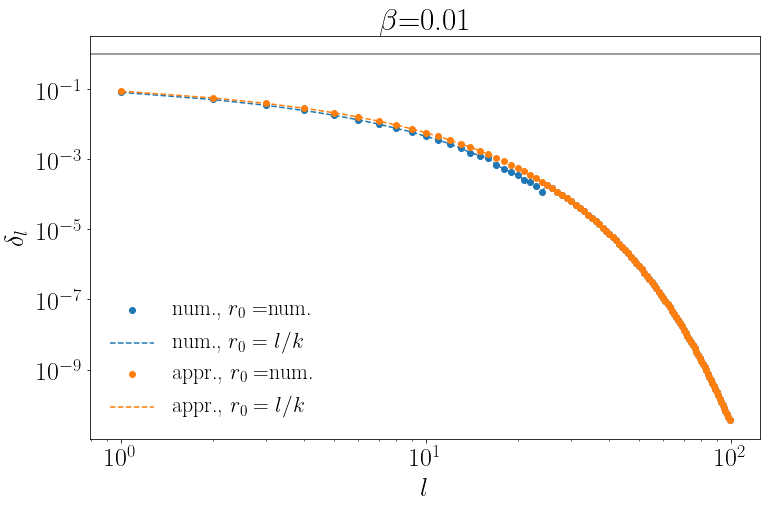

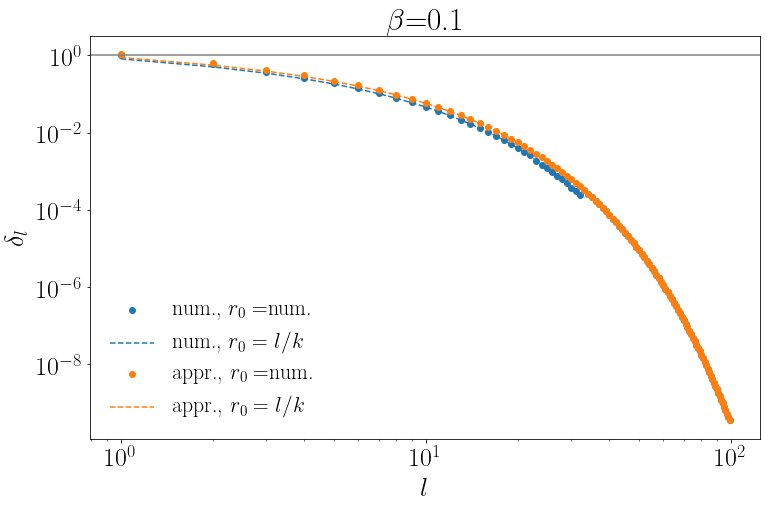

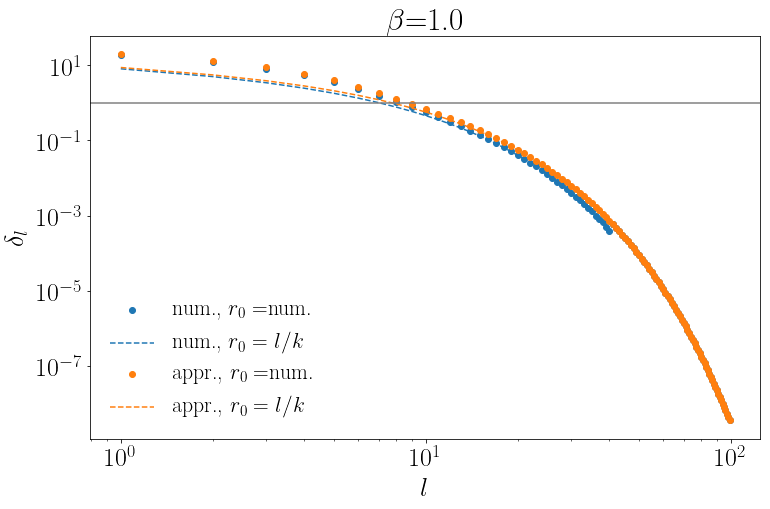

In [74]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)

for beta in [0.001,0.01,0.1,1.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    deltalr0num_betavals=np.array([[l,deltalr0num_beta(l,beta)] for l in lvalsnew])
    pl.plot(deltalr0num_betavals[:,0],deltalr0num_betavals[:,1],'o',color='C0',label='num., $r_0=$num.')
    
    deltal_betavals=np.array([[l,deltal_beta(l,beta)] for l in lvalsnew])
    ##print(deltal_betavals)
    pl.plot(deltal_betavals[:,0],deltal_betavals[:,1],color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    pl.plot(lvalsnew,[deltalapprr0num_beta(l,beta) for l in lvalsnew],'o',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[deltalappr_beta(l,beta) for l in lvalsnew],color='C1',linestyle='--',label=r'appr., $r_0=l / k$')
   
    pl.xscale('log')
    pl.yscale('log')
    pl.axhline(1,color = 'grey')
    pl.xlabel(r'$l$',fontsize=fontsize)
    #pl.ylim([10.**(-3.),10.**5.])
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$\delta_{l}$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

In [75]:
#Phase shifts follow exactly the bessel function. In principle, cross-section should also agree! 
#Difference in going from sum to integral? --> Checked, doesn't work. In fact cross-section goes further down although
#this might be due to numercial instabilities in the integral 

#Missing contribution from larger l's --> Nope. Added approximate formula for \delta_l where the numerical integration
#breaks down and this doesn't change the result at all. 

#\delta_{l+1} - \delta_l unequal to d\delta_l/dl (as a bessel function) --> Nope. The two curves follow each other 
#quite well. (Also checked for different values of beta)


#Difference between Sin(...)**2 and just (...)**2 --> Take a guess.

#Using a numerical evaluation of \delta_l but with r0 = l/k: no change at small beta but the cross-section for  the
#larger beta values is lower as expected

#for a given value of beta, plotting the summed-up cross-section until lmax? 

In [76]:
beta = 0.01

In [77]:
sin_ddeltalr0num_betavals=np.array([[l,(l+1)*np.sin(deltalr0num_beta(l+1,beta)-deltalr0num_beta(l,beta))**2] for l in lvalsnew])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


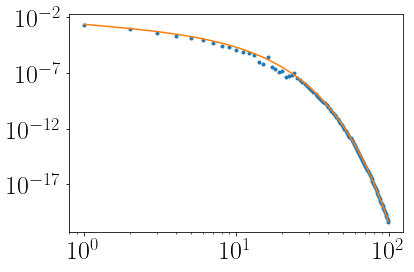

In [78]:
pl.plot(sin_ddeltalr0num_betavals[:,0],sin_ddeltalr0num_betavals[:,1],'.')
pl.plot(lvalsnew,[l*np.sin(ddeltaldlappr_beta(l,beta))**2 for l in lvalsnew],'-') 
pl.xscale('log')
pl.yscale('log')

In [79]:
def sigmaTr0num(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    #_____Sum_____
    def deltalnew(l):
        return deltalr0num(potential,alphaX,mX,mphi,l,v)
    def deltalnewappr(l):
        return deltal_beta(l,beta)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #Sum=np.sum([(l+1)*np.sin(deltalnewappr(l+1)-deltalnewappr(l))**2. for l in range(lmin,lmax)])
    #Sum=np.sum([(l+1.)*(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #def integrand(l):
     #   return l*np.sin(deltalnew(l+1)-deltalnew(l))**2
    #Sum = integrate.quad(integrand, lmin,lmax)[0]
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT

def sigmaTm2pir0num_beta(beta):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta)*c #km/s
    #print(v)
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    lmax=len(lvals) #len(lvals)=1501
    return (sigmaTr0num(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

def sigmaTm2pir0num_beta_lmax(beta, lmax):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta)*c #km/s
    #print(v)
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    return (sigmaTr0num(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi
for beta in [0.01]:
    print(sigmaTm2pir0num_beta(beta))
    print(sigmaTm2pir0num_beta_lmax(beta,2))

0.0006044807033656061
0.00032578869671241


In [80]:
for beta in [0.001]:
    print(sigmaTm2pipheno_beta(beta))
    print(sigmaTm2piappr_beta(beta))
    print(sigmaTm2pir0num_beta(beta))

2.7635019117260874e-05
2.709476322592173e-05
5.935943956063264e-06


In [81]:
betalist2 = np.logspace(-3,2,30)
pheno_list = np.array([sigmaTm2pipheno_beta(beta) for beta in betalist2])
num_list = np.array([sigmaTm2pir0num_beta(beta) for beta in betalist2])
analytic_list = np.array([2*beta**4*(beta**(-2.)-kn(1,beta)**2 + kn(0,beta)*kn(2,beta)) for beta in betalist2])
analytic_list_2 = np.array([sigmaTm2piappr_beta(beta) for beta in betalist2])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


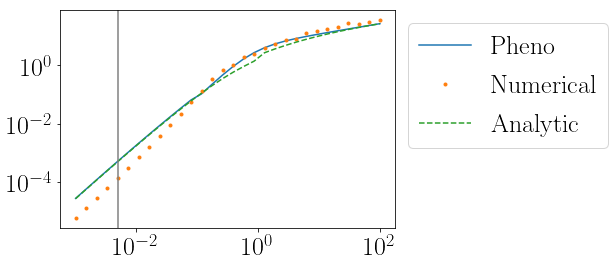

In [82]:
pl.plot(betalist2, pheno_list, '-', label='Pheno')
pl.plot(betalist2, num_list, '.', label = 'Numerical')
#pl.plot(betalist2, analytic_list, '--', label='Analytic w/ lmin = 1/2a')
pl.plot(betalist2, analytic_list_2,'--', label='Analytic')
pl.xscale('log')
pl.yscale('log')
pl.legend(bbox_to_anchor = (1,1))
#pl.axhline(sigmaTm2piappr_beta(0.01), color = 'grey')
#pl.axhline(sigmaTm2_appr_lmax(0.005, 1000), color = 'grey')
pl.axvline(0.005, color='grey')
pl.show()

In [83]:
def sigmaTm2_appr_lmax(beta, lmax):
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta) #natural units 
    #print(v)
    a = v/(2*alphaX)
    b = alphaX*mX/mphi
    k = (mX*v/2)*c #km/s
    lmin = 1
    def deltalnew(l):
        return deltalappr_beta(l,beta)
    def deltaltest(l):
        return 1/(2*a)*kn(0,l/(a*b))
    def ddeltalnew(l):
        return -beta*kn(1,l/(a*b))
    def integrand(l):
        return (l+1)*np.sin(deltaltest(l+1)-deltaltest(l))**2
    def integrand2(l):
        return (l+1)*np.sin(ddeltalnew(l))**2
    #ans = 4/k**2*mphi**2*np.sum([(l+1)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    integral = integrate.quad(integrand2, lmin, lmax, limit = 200)[0]
    #print(integral)
    ans = ((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)*(integral)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2./np.pi
    return ans
    
for beta in [0.001]:
    print(sigmaTm2_appr_lmax(beta, 100))
    print(sigmaTm2pipheno_beta(beta))

7.657083801585645e-06
2.7635019117260874e-05


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


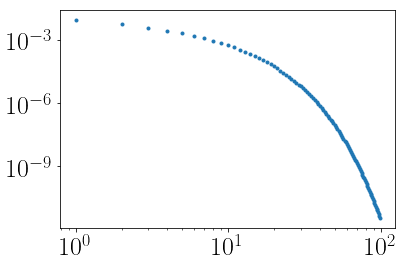

In [84]:
testdeltalvals = [deltalappr_beta(l,0.001)for l in range(1,100)]
testlvals = range(1,100)
pl.plot(testlvals, testdeltalvals, '.')
pl.xscale('log')
pl.yscale('log')

In [85]:
lmaxvals = np.arange(2,100)
sigmaT_beta_lmax_list = np.array([sigmaTm2pir0num_beta_lmax(1,lmax) for lmax in lmaxvals])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


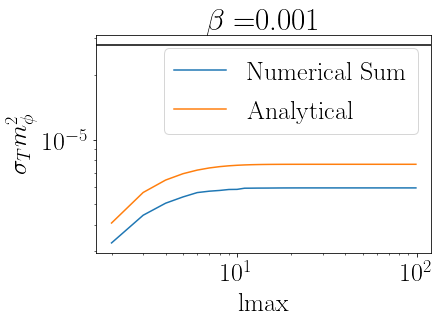

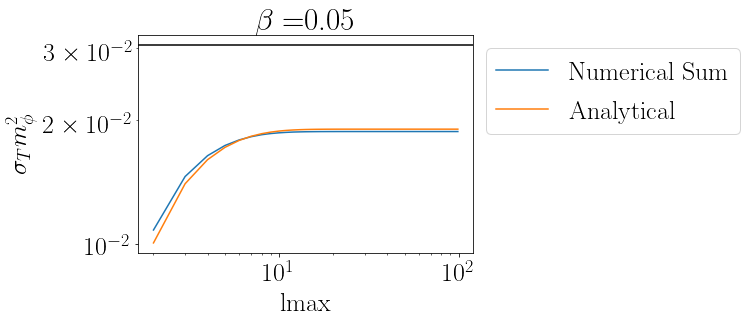

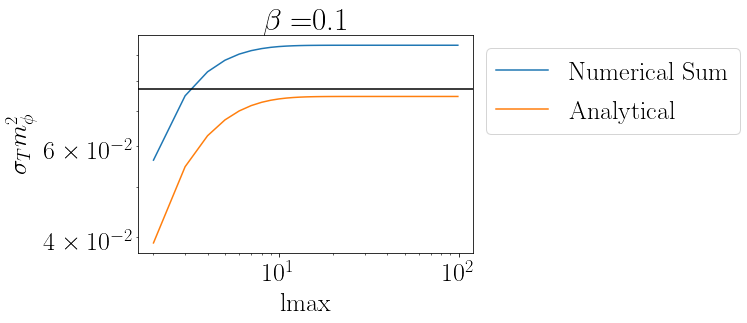

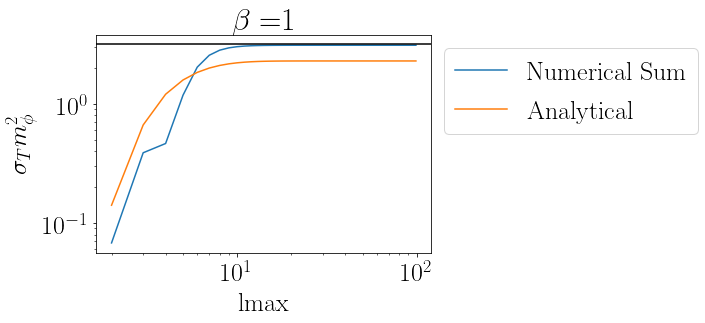

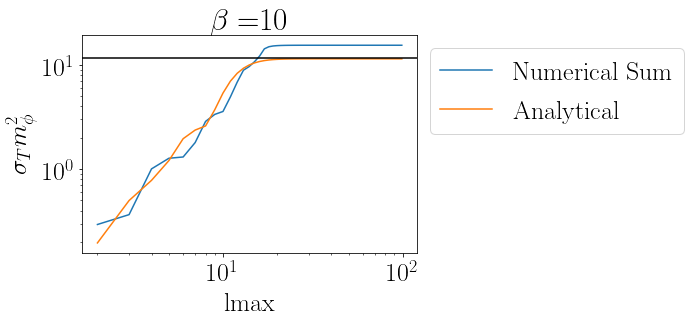

In [86]:
for beta in [0.001,0.05,0.1, 1, 10]:
    sigmaT_beta_lmax_list = np.array([sigmaTm2pir0num_beta_lmax(beta,lmax) for lmax in lmaxvals])
    sigmaT_beta_lmax_appr_list = np.array([sigmaTm2_appr_lmax(beta, lmax) for lmax in lmaxvals])
    pl.figure()
    pl.plot(lmaxvals, sigmaT_beta_lmax_list, label='Numerical Sum')
    pl.plot(lmaxvals, sigmaT_beta_lmax_appr_list, label = 'Analytical')
    pl.xlabel("lmax")
    pl.ylabel(r'$\sigma_T m_\phi^2$')
    pl.xscale('log')
    pl.yscale('log')
    pl.axhline(sigmaTm2pipheno_beta(beta), color = 'black')
    pl.title(r'$\beta = $'+str(beta))
    pl.legend(bbox_to_anchor = (1,1))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


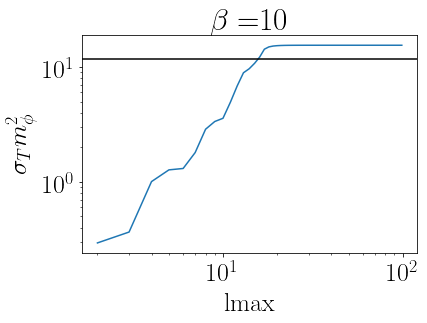

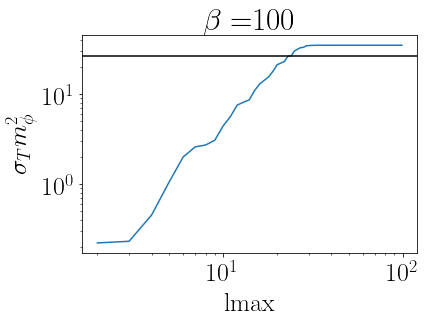

In [87]:
for beta in [10,100]:
    sigmaT_beta_lmax_list = np.array([sigmaTm2pir0num_beta_lmax(beta,lmax) for lmax in lmaxvals])
    pl.figure()
    pl.plot(lmaxvals, sigmaT_beta_lmax_list, label='Numerical Sum')
    pl.xlabel("lmax")
    pl.ylabel(r'$\sigma_T m_\phi^2$')
    pl.xscale('log')
    pl.yscale('log')
    pl.axhline(sigmaTm2pipheno_beta(beta), color = 'black')
    pl.title(r'$\beta = $'+str(beta))

# Approximations for large $\beta$

In [88]:
#Assuming r0 = [-(eta - 1) \pm sqrt((eta-1)**2 + 4*eta)]/(2*eta*mphi) --> slightly better at large beta but not good
#enough. Makes the small beta approximation better than the numerical one though which is weird. 

#Try a pseudo-analytical result so get l where the peak is, use this as lmin in the analytical formula and see if the
#cross-section still matches the phenomological result --> equivalent to approximate expression with numerical r0 which
#breaks down at small beta but works for large beta. 

In [89]:
#Assuming r0 = [-(eta - 1) \pm sqrt((eta-1)**2 + 4*eta)]/(2*eta*mphi)

def deltallargebeta(potential,alphaX,mX,mphi,l,v):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #E=(hbar**2.*k**2.)/(2.*m) #kinetic energy
    E=p**2./(2.*m) #kinetic energy
    #_____deltal integral_____
    #def integrand(r):
    #    return -(mX/hbar**2)*(U(potential,alphaX,mphi,r)/np.sqrt(k**2.-((l+1./2.)**2./r**2.)))
    #def integrand(r):
    #    return (1./hbar)*np.sqrt(hbar**2.*k**2.-2.*m*U(potential,alphaX,mphi,r)-(hbar**2.*(l+1./2.)**2.)/r**2.)-k ###Doesn't work well. Numerically very unstable.
    def integrand(r):
        x=1.-(r0**2./r**2)
        #x=k**2.-((l+1./2.)**2./r**2.)
        y=U(potential,alphaX,mphi,r)/(E*c**2)
        #y=2*m*U(potential,alphaX,mphi,r)
        #print([x,y])
        #print([np.sqrt(x-y),np.sqrt(x)])
        #return np.sqrt(x-y)-np.sqrt(x)
        #print([np.sqrt(1-y/x),1.])
        return np.sqrt(x)*(np.sqrt(1-y/x)-1.)
    eta = alphaX*m/(mphi*l**2)
    r0= (-(eta-1) + np.sqrt((eta-1)**2 + 4*eta))/(2*eta*mphi)
    #rmax=10**6 #.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
    rmax=10**2.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
#     #rmax=10.**10.
#     #print([r0,rmax])
#     epsilon=10.**(-8.)
#     rvals=np.logspace(np.log10((1+epsilon)*r0),np.log10(rmax),5000.)
#     integrandvals=np.array([integrand(r) for r in rvals])
#     #print(integrandvals)
#     deltalintegral=np.trapz(integrandvals,x=rvals) #Trapezoidal rule is slower and less accurate.
    logging=False
    if logging:
        print([r0,rmax,rmax/r0])
        pl.xscale('log')
        #pl.yscale('log') 
        Rvals=np.logspace(np.log10(r0),np.log10(rmax),50)
        pl.plot(Rvals,[integrand(r) for r in Rvals])
        pl.show()
        pl.xscale('log')
        #pl.yscale('log')
        pl.plot(Rvals,[U(potential,alphaX,mphi,r) for r in Rvals])
        pl.show()
    #deltal=integrate.quad(integrand,r0,rmax,limit=200)[0] #,limit=200
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,points=r0)[0] #,limit=200
    #deltal=deltalintegral+(1./2.)*np.pi*(l+(1./2.))-k*r0
    #print([deltalintegral,(1./2.)*np.pi*(l+(1./2.))-k*r0])
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,epsabs=5.*10.**(-7.), epsrel=5*10.**(-1.))[0]
    deltalintegral=integrate.quad(integrand,r0,rmax)[0]
    deltal=k*c**2*deltalintegral
    if deltal == 0:
        deltal = deltalappr(potential,alphaX,mX,mphi,l,v)
    return deltal

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1.
v=10. #km/s
print(deltalappr(potential,alphaX,mX,mphi,l,v))
print(deltallargebeta(potential,alphaX,mX,mphi,l,v))

411.64339210020086
1559.1342734302823


In [90]:
def sigmaTr0numlargebeta(potential,alphaX,mX,mphi,lmin,lmax,v):
    #_____Variables_____
    a=(v/c)/(2*alphaX)
    b=alphaX*(mX/mphi)
    beta=1./(2.*a**2.*b)
    #m=(mX/2.)  #reduced mass m
    #k=m*(v/c) #momentum k
    #print([k,a*b*mphi])
    k=(c/hbar)*a*b*mphi
    #_____Sum_____
    def deltalnew(l):
        return deltallargebeta(potential,alphaX,mX,mphi,l,v)
    if lmax==len(lvals):
        lmax=lmax-1
    Sum=np.sum([(l+1)*np.sin(deltalnew(l+1)-deltalnew(l))**2. for l in range(lmin,lmax)])
    #_____sigmaT_____
    prefactor=((4.*np.pi)/(k*(GeV_to_cmminus1/c))**2.)
    sigmaT=prefactor*Sum
    return sigmaT

def sigmaTm2pir0largebeta(beta):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta)*c #km/s
    #print(v)
    lmin=1 #lmin cannot be 0 here because r0=l/k.
    lmax=len(lvals) #len(lvals)=1501
    return (sigmaTr0numlargebeta(potential,alphaX,mX,mphi,lmin,lmax,v)*(c/hbar)**2.*(mphi*(GeV_to_cmminus1/c))**2.)/np.pi

for beta in [10.]:
    print(sigmaTm2pir0largebeta(beta))

32.97480711622722


In [91]:
betalist2 = np.logspace(-3,2,30)
pheno_list = np.array([sigmaTm2pipheno_beta(beta) for beta in betalist2])
num_list_largebeta = np.array([sigmaTm2pir0largebeta(beta) for beta in betalist2])
analytic_list = np.array([2*beta**4*(beta**(-2.)-kn(1,beta)**2 + kn(0,beta)*kn(2,beta)) for beta in betalist2])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


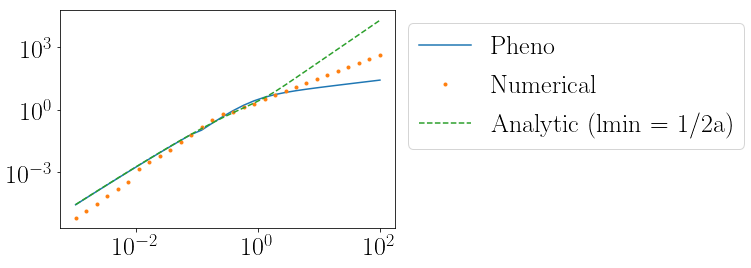

In [92]:
pl.plot(betalist2, pheno_list, '-', label='Pheno')
pl.plot(betalist2, num_list_largebeta, '.', label = 'Numerical')
pl.plot(betalist2, analytic_list, '--', label='Analytic (lmin = 1/2a)')
pl.xscale('log')
pl.yscale('log')
pl.legend(bbox_to_anchor = (1,1))
pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


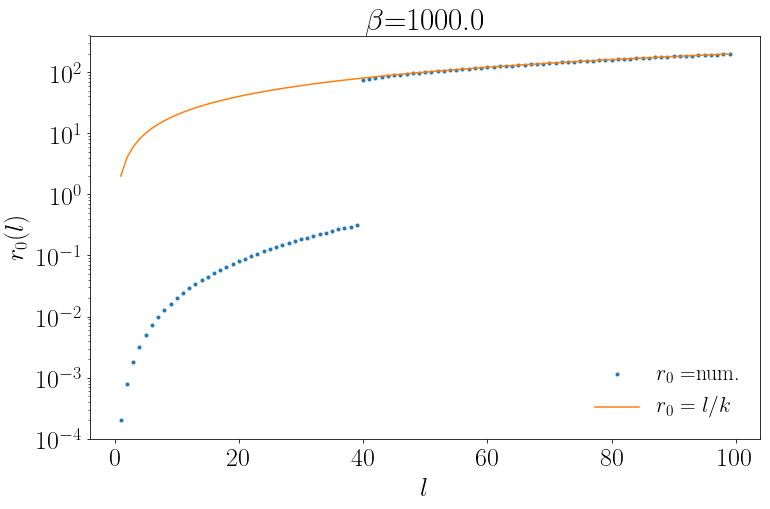

In [93]:
for beta in [1000.]:
    #print('beta='+str(beta))
    #for l in [30,35,40.]:
    #print('l='+str(l))
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta)*c #km/s
    #print(v)
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #r0appr=l/k
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
    pl.plot(lvalsnew,[r0num(potential,alphaX,mX,mphi,l,v,logging=False) for l in lvalsnew],'.',label=r'$r_0=$num.')
    pl.plot(lvalsnew,[l/k for l in lvalsnew],label=r'$r_0=l / k$')
    #pl.xscale('log')
    pl.yscale('log')
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.ylabel(r'$r_{0}(l)$',fontsize=fontsize)
    #pl.ylim([10.**(-5.),10.**5.])
    pl.legend(loc='lower right',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta))
    pl.show()

In [94]:
def sigmaTappr_beta_modified(mphi,beta):
    ### No difference between attractive and repulsive case for cross section.
    #if potential=='attractive':
    #    prefactor=+1.
    #elif potential=='repulsive':
    #    prefactor=-1.
    #_____sigmaTappr_____
    alphaX = 0.1
    mX = 50*beta
    v = 0.02/beta
    a = v/(2*alphaX)
    b = mX*alphaX/mphi
    k = mX*v/2;
    if beta<=1:
        prefactor=((2.*np.pi)/(mphi)**2.)
        #term=2.*beta**4.*(kn(0.,beta)*kn(2.,beta)-kn(1.,beta)**2.)
        term=beta**4.*(1./(2*beta**2.)-kn(1.,beta)**2.+kn(0.,beta)*kn(2.,beta))
        ans = prefactor*term
    elif beta>1:
        #term=beta**2.*abs(prodlog(beta**2.*np.pi))**2./4.*(1./beta**2.-kn(1.,abs(prodlog(beta**2.*np.pi))/2.)**2.+kn(0.,abs(prodlog(np.pi*beta**2.))/2.)*kn(2.,abs(prodlog(np.pi*beta**2.))/2.))
        lminnew = np.sqrt(b/(2*beta))*prodlog(np.pi*beta*b/2)/2
        #print(lminnew)
        #print(1/k**2)
        #term = 4*np.pi/k**2*(abs(lminnew)**2/2 - abs(lminnew)**2/(8*(a**4*b**2))*(kn(1, abs(lminnew)/(a*b))**2 - kn(0,abs(lminnew)/(a*b))*kn(2,abs(lminnew)/(a*b))))
        #ans = term #missing a factor of 2 in the derivation somehow
        term2 = abs(prodlog(np.pi/(4*a**2))**2)*beta**2*np.pi/(2*mphi**2)*(1/(2*beta**2) - (kn(1,0.5*abs(prodlog(np.pi/(4*a**2))))**2- kn(0,0.5*abs(prodlog(np.pi/(4*a**2))))*kn(2,0.5*abs(prodlog(np.pi/(4*a**2))))))
        ans = term2 #also missing a factor of 2 :( 
    sigmaT = ans
    #print(ans)
    return sigmaT

def sigmaTm2piappr_beta_modified(beta):
    mphi=0.1 #GeV.
    return (sigmaTappr_beta_modified(mphi,beta)*(mphi)**2.)/np.pi

for beta in [100]:
    print(sigmaTm2piappr_beta_modified(beta))
    print(sigmaTm2pipheno_beta(beta))
    print((sigmaTm2piappr_beta_modified(beta)/sigmaTm2pipheno_beta(beta)))

31.645537486112364
26.72105762482081
1.1842921013993577


# Geometric Cross-Section proportional to $l_\mathrm{min}^2$:

In [95]:
def sigmaTmphi2pi_Geometric(beta, lmin):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    mphi = 0.1
    #print(mX)
    v=(0.02/beta) 
    a = v/(2*alphaX)
    b = alphaX*mX/mphi
    #print(v)
    return (lmin/(a*b))**2 #(*2 currently removed for testing)

print(sigmaTmphi2pi_Geometric(5000,46.203))
print(sigmaTm2pipheno_beta(5000))

85.38868836000002
89.46300292343965


In [96]:
lminnum('attractive',0.1,50*100,0.1,0.02/100,logging=False)

array(499.99999997)

In [97]:

beta = 100
b = 0.1*50*beta/0.1
a = 0.02/(2*0.1*beta)
lminnew = np.sqrt(b/(2*beta))*prodlog(np.pi*beta*b/2)/2
#lminnew = a*b/2*prodlog(np.pi/(4*a**2))
#lminold = 1/2*a*b*prodlog(np.pi/4*a**4*b**2)
print(lminnew)
#print(lminold)
print(a*b)

(27.903694305322986+0j)
5.0


In [98]:
#lmin for small beta using k_0(x)=1 #INCORRECT
beta = 0.01
b = 0.1*50*beta/0.1
a = 0.02/(2*0.1*beta)
lminnew = 0.56*a*b*np.exp(-2*a)
lminold = 1/(2*a)
#lminnew = a*b/2*prodlog(np.pi/(4*a**2))
#lminold = 1/2*a*b*prodlog(np.pi/4*a**4*b**2)
print(lminnew)
print(lminold)
#print(a*b)

5.7712301428279625e-09
0.05


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


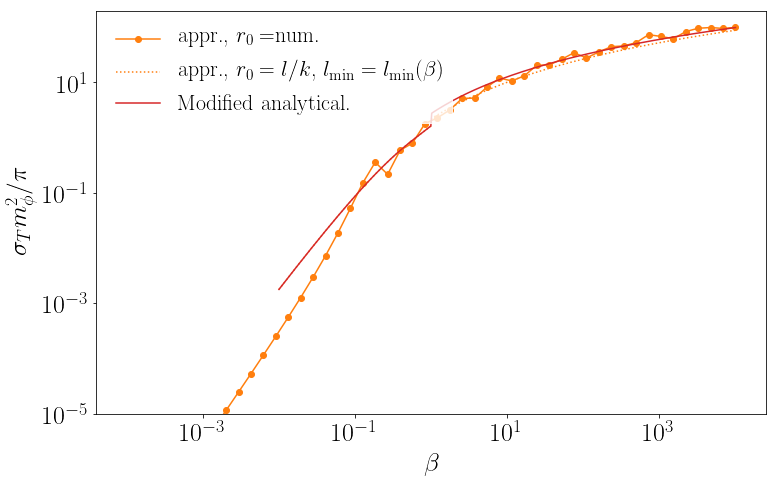

In [99]:
pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
betavals = np.logspace(-2,4,500)
#pl.plot(sigmaTm2pir0num_betavals[:,0],sigmaTm2pir0num_betavals[:,1],'o-',color='C0',label='num., $r_0=$num.')
#pl.plot(sigmaTm2pi_betavals[:,0],sigmaTm2pi_betavals[:,1],color='C0',linestyle='--',label='num., $r_0=l / k$')

pl.plot(sigmaTm2piapprr0num_betavals[:,0],sigmaTm2piapprr0num_betavals[:,1],'o-',color='C1',label=r'appr., $r_0=$num.')

#pl.plot(betavals,[sigmaTm2piappr_lmin12a_beta(beta) for beta in betavals],color='C1',linestyle='--',label=r'appr., $r_0=l / k$, $l_{\rm min}=1/2a$')

pl.plot(betavals,[sigmaTm2piappr_beta(beta) for beta in betavals],color='C1',linestyle=':',label=r'appr., $r_0=l / k$, $l_{\rm min}=l_{\rm min}(\beta)$')

#pl.plot(betavals,[sigmaTm2pipheno_beta(beta) for beta in betavals],color='C2',linestyle='-',label='pheno.')


pl.plot(betavals,[sigmaTm2piappr_beta_modified(beta) for beta in betavals],color='C3',linestyle='-',label='Modified analytical.')

pl.xscale('log')
pl.yscale('log')
#pl.xlim([betamin,betamax])
pl.ylim([10.**(-5.),200.])
#pl.ylim([-1.,30.])
pl.xlabel(r'$\beta$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_{T} m_{\phi}^2 / \pi$',fontsize=fontsize) 
pl.legend(loc='upper left',edgecolor='white',fontsize=legendfontsize) 
#pl.savefig('Plots/C_analytical_vs_pheno.pdf',bbox_inches='tight')
#print('Plots/C_analytical_vs_pheno.pdf exported.')
pl.show()

# Integrand for cross-section

In [100]:
def ddeltal_approx(l, beta):
    mphi = 0.1
    mX = 50*beta
    alphaX = 0.1
    v = 0.02/beta
    a = v/(2*alphaX)
    b = alphaX*mX/mphi
    return -beta*kn(1,l/(a*b))

print(ddeltal_approx(10,0.01))

-0.0013986588181652247


In [101]:
beta = 0.1
lsin_ddeltal_vals = np.array([l*np.sin(ddeltal_approx(l,beta))**2 for l in range(1,100)])
l_ddeltal_vals = np.array([l*ddeltal_approx(l,beta)**2 for l in range(1,100)])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


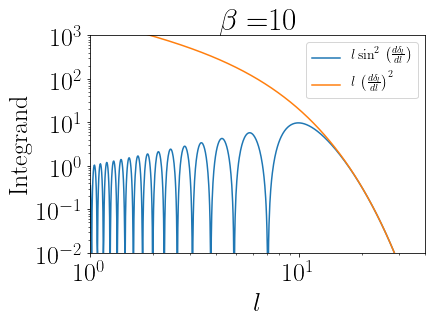

In [102]:
lvals = np.logspace(0,2,1000)
for beta in [10]:
    lsin_ddeltal_vals = np.array([l*np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    l_ddeltal_vals = np.array([l*ddeltal_approx(l,beta)**2 for l in lvals])
    
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    ddeltal_vals = np.array([ddeltal_approx(l,beta)**2 for l in lvals])
    
    pl.figure()
    pl.plot(lvals, lsin_ddeltal_vals, '-', label=r'$l\,\mathrm{sin}^2\,\left(\frac{d\delta_l}{dl}\right)$')
    pl.plot(lvals, l_ddeltal_vals, '-', label = r'$l\,\left(\frac{d\delta_l}{dl}\right)^2$')
    #pl.plot(lvals, lvals,'--', color = 'C2')
    
    #pl.plot(lvals, sin_ddeltal_vals, '-', label=r'$\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    #pl.plot(lvals, ddeltal_vals, '-', label = r'$\left(\frac{d\delta_l}{dl}\right)^2$')
    
    #pl.legend(bbox_to_anchor = (1,1))
    pl.legend(loc='upper right', fontsize=14)
    #pl.ylim(0,100)
    pl.ylim(1e-2,1e3)
    pl.yscale('log')
    pl.xscale('log')
    pl.xlim(1,40)
    #pl.axhline(0.5, color='grey')
    pl.ylabel('Integrand')
    pl.xlabel(r'$l$')
    pl.title(r'$\beta=$'+str(beta))
    #pl.savefig('Plots/integrand.pdf', bbox_inches='tight')
    pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


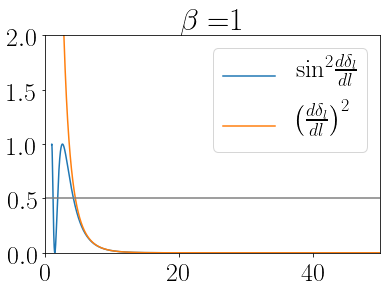

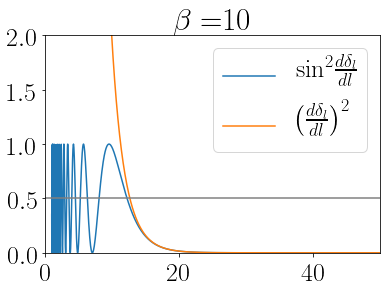

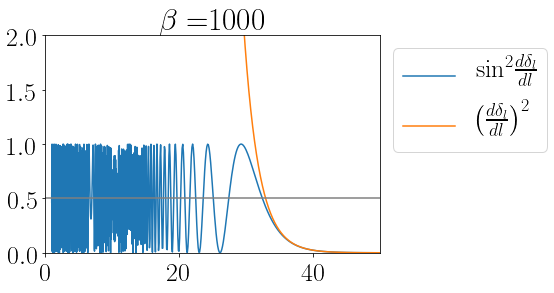

In [103]:
lvals = np.logspace(0,2,1000)
for beta in [1,10,1000]:
    lsin_ddeltal_vals = np.array([l*np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    l_ddeltal_vals = np.array([l*ddeltal_approx(l,beta)**2 for l in lvals])
    
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    ddeltal_vals = np.array([ddeltal_approx(l,beta)**2 for l in lvals])
    
    pl.figure()
    #pl.plot(lvals, lsin_ddeltal_vals, '-', label=r'$l\,\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    #pl.plot(lvals, l_ddeltal_vals, '-', label = r'$l\,\left(\frac{d\delta_l}{dl}\right)^2$')
    
    pl.plot(lvals, sin_ddeltal_vals, '-', label=r'$\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    pl.plot(lvals, ddeltal_vals, '-', label = r'$\left(\frac{d\delta_l}{dl}\right)^2$')
    
    pl.legend(bbox_to_anchor = (1,1))
    #pl.ylim(0,100)
    pl.ylim(0,2)
    pl.xlim(0,50)
    pl.axhline(0.5, color='grey')
    pl.title(r'$\beta=$'+str(beta))
    pl.show()
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


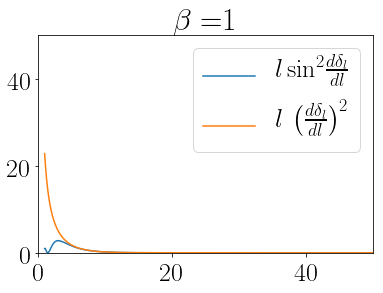

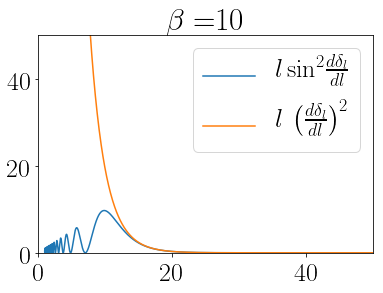

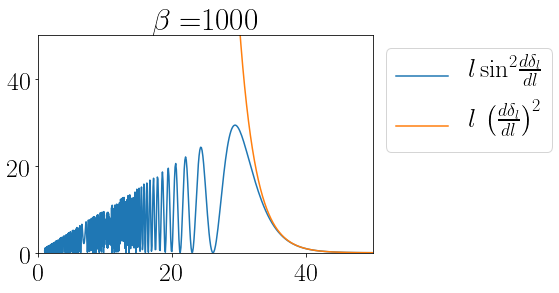

In [104]:
lvals = np.logspace(0,2,1000)
for beta in [1,10,1000]:
    lsin_ddeltal_vals = np.array([l*np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    l_ddeltal_vals = np.array([l*ddeltal_approx(l,beta)**2 for l in lvals])
    
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    ddeltal_vals = np.array([ddeltal_approx(l,beta)**2 for l in lvals])
    
    pl.figure()
    pl.plot(lvals, lsin_ddeltal_vals, '-', label=r'$l\,\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    pl.plot(lvals, l_ddeltal_vals, '-', label = r'$l\,\left(\frac{d\delta_l}{dl}\right)^2$')
    
    #pl.plot(lvals, sin_ddeltal_vals, '-', label=r'$\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    #pl.plot(lvals, ddeltal_vals, '-', label = r'$\left(\frac{d\delta_l}{dl}\right)^2$')
    
    pl.legend(bbox_to_anchor = (1,1))
    pl.ylim(0,50)
    pl.xlim(0,50)
    pl.title(r'$\beta=$'+str(beta))
    pl.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


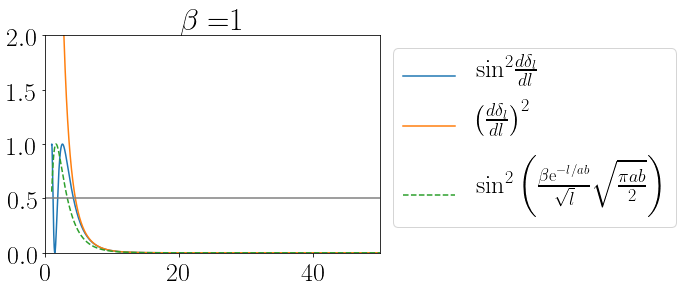

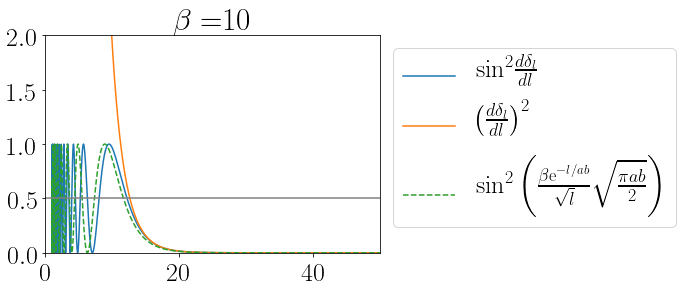

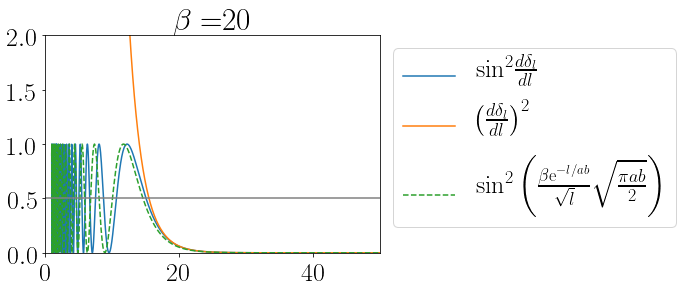

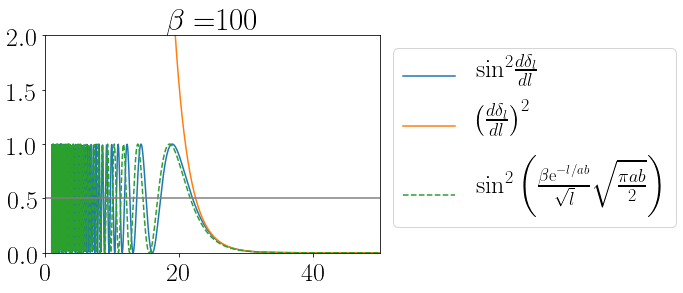

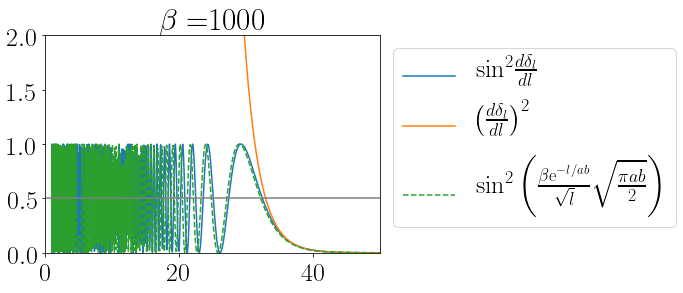

In [105]:
lvals = np.logspace(0,2,1000)
for beta in [1,10,20,100,1000]:
    
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    ddeltal_vals = np.array([ddeltal_approx(l,beta)**2 for l in lvals])
    
    sin_ddeltal_approx_vals = np.array([np.sin(beta*np.sqrt(np.pi/2)*np.exp(-l/(5))*np.sqrt(5/l))**2 for l in lvals]) #approximating beta*K_1(l/ab) as beta*ab/l
    
    pl.figure()
    
    pl.plot(lvals, sin_ddeltal_vals, '-', label=r'$\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    pl.plot(lvals, ddeltal_vals, '-', label = r'$\left(\frac{d\delta_l}{dl}\right)^2$')
    pl.plot(lvals, sin_ddeltal_approx_vals, '--', label = r'$\mathrm{sin}^2\left(\frac{\beta\mathrm{e}^{-l/ab}}{\sqrt{l}}\sqrt{\frac{\pi ab}{2}}\right)$')
    
    pl.legend(bbox_to_anchor = (1,1))
    #pl.ylim(0,100)
    pl.ylim(0,2)
    pl.xlim(0,50)
    pl.axhline(0.5, color='grey')
    pl.title(r'$\beta=$'+str(beta))
    pl.show()

## Small $\beta$

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


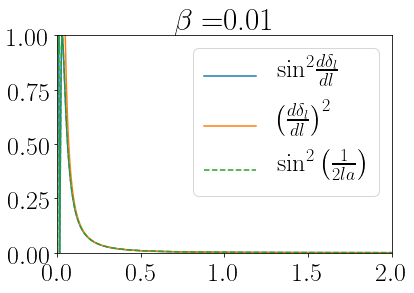

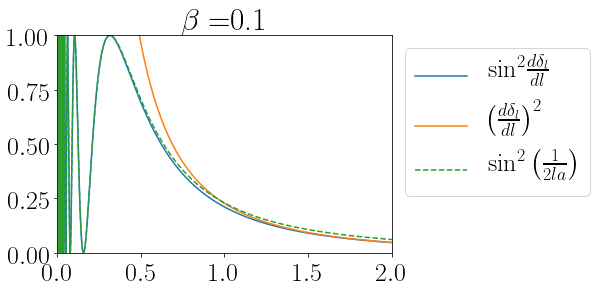

In [106]:
#lvals = np.logspace(0,2,1000)
lvals = np.logspace(-2,0.5,1000)
for beta in [0.01,0.1]:
    lsin_ddeltal_vals = np.array([l*np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    l_ddeltal_vals = np.array([l*ddeltal_approx(l,beta)**2 for l in lvals])
    
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    ddeltal_vals = np.array([ddeltal_approx(l,beta)**2 for l in lvals])
    sin_ddeltal_approx_vals = np.array([np.sin(beta/(l*0.2))**2 for l in lvals]) #approximating beta*K_1(l/ab) as beta*ab/l
    
    pl.figure()
    #pl.plot(lvals, lsin_ddeltal_vals, '-', label=r'$l\,\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    #pl.plot(lvals, l_ddeltal_vals, '-', label = r'$l\,\left(\frac{d\delta_l}{dl}\right)^2$')
    
    pl.plot(lvals, sin_ddeltal_vals, '-', label=r'$\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    pl.plot(lvals, ddeltal_vals, '-', label = r'$\left(\frac{d\delta_l}{dl}\right)^2$')
    pl.plot(lvals, sin_ddeltal_approx_vals, '--', label = r'$\mathrm{sin}^2\left(\frac{1}{2 l a}\right)$')
    
    pl.legend(bbox_to_anchor = (1,1))
    #pl.ylim(0,100)
    pl.ylim(0,1)
    pl.xlim(0,2)
    #pl.axhline(0.5, color='grey')
    pl.title(r'$\beta=$'+str(beta))
    pl.show()

In [107]:
def sigmaTappr_beta_modified2(mphi,beta):
    ### No difference between attractive and repulsive case for cross section.
    #if potential=='attractive':
    #    prefactor=+1.
    #elif potential=='repulsive':
    #    prefactor=-1.
    #_____sigmaTappr_____
    alphaX = 0.1
    mX = 50*beta
    v = 0.02/beta
    a = v/(2*alphaX)
    b = mX*alphaX/mphi
    k = mX*v/2;
    prefactor = 2*np.pi/(mphi**2)*beta**2
    if beta<=0.0001:
        lminnew = 1/a
        term = (lminnew/(a*b))**2*(1/(2*beta**2) -kn(1, lminnew/(a*b))**2 + kn(0,lminnew/(a*b))*kn(2,lminnew/(a*b)) )
        ans = prefactor*term
    elif beta>0.0001:
        #lminnew = a*b*0.5*abs(prodlog(4*np.pi*beta**2))
        lminnew = np.sqrt(b/(2*beta))*abs(prodlog(np.pi*beta*b/2))/2 #from when\delta_l crosses 1
        term2 = (lminnew/(a*b))**2*(1/(2*beta**2)-kn(1, lminnew/(a*b))**2 + kn(0,lminnew/(a*b))*kn(2,lminnew/(a*b)) )
        ans = prefactor*term2
    sigmaT = ans
    #print(ans)
    return sigmaT

def sigmaTm2piappr_beta_modified2(beta):
    mphi=0.1 #GeV.
    return (sigmaTappr_beta_modified2(mphi,beta)*(mphi)**2.)/np.pi

for beta in [100]:
    print(sigmaTm2piappr_beta_modified2(beta))
    print(sigmaTm2pipheno_beta(beta))
    print((sigmaTm2piappr_beta_modified2(beta)/sigmaTm2pipheno_beta(beta)))

31.64553748611237
26.72105762482081
1.184292101399358


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


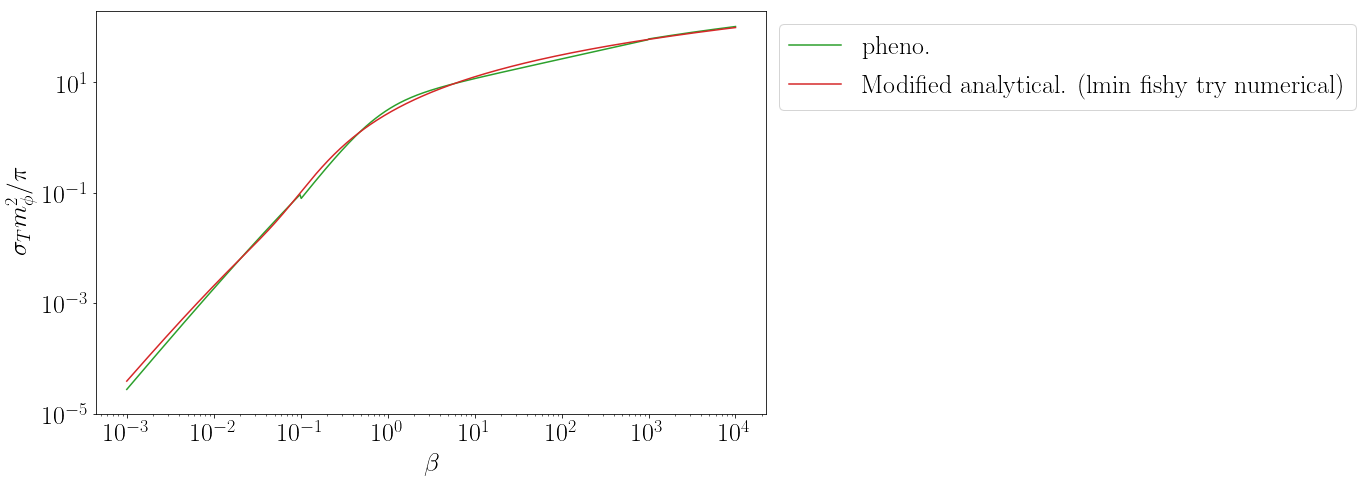

In [108]:
pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
betavals = np.logspace(-3,4,500)


#pl.plot(betavals,[sigmaTm2piappr_beta(beta) for beta in betavals],color='C1',linestyle=':',label=r'appr., $r_0=l / k$, $l_{\rm min}=l_{\rm min}(\beta)$')

pl.plot(betavals,[sigmaTm2pipheno_beta(beta) for beta in betavals],color='C2',linestyle='-',label='pheno.')

pl.plot(betavals,[sigmaTm2piappr_beta_modified2(beta) for beta in betavals],color='C3',linestyle='-',label='Modified analytical. (lmin fishy try numerical)')

pl.xscale('log')
pl.yscale('log')
#pl.xlim([betamin,betamax])
pl.ylim([10.**(-5.),200.])
#pl.ylim([-1.,30.])
pl.xlabel(r'$\beta$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_{T} m_{\phi}^2 / \pi$',fontsize=fontsize) 
pl.legend(bbox_to_anchor = (1,1)) 
#pl.savefig('Plots/C_analytical_vs_pheno.pdf',bbox_inches='tight')
#print('Plots/C_analytical_vs_pheno.pdf exported.')
pl.show()

## Plotting $\mathrm{sin}^2\,(\delta_{l+1}-\delta_l)$ with l

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


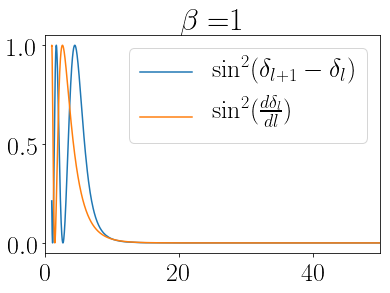

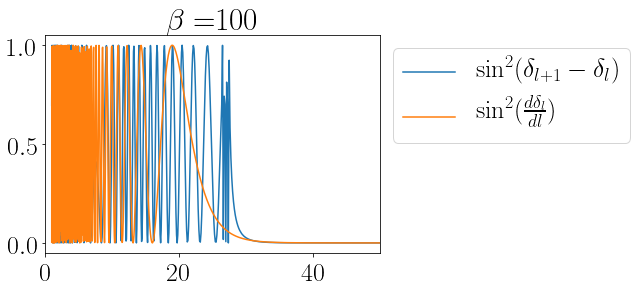

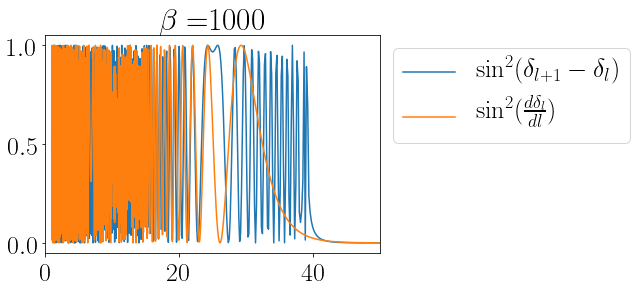

In [109]:
lvals = np.logspace(0,2,1000)
for beta in [1,100,1000]:
    sin_deltal_vals = np.array([np.sin(deltalr0num_beta(l+1,beta)-deltalr0num_beta(l,beta))**2 for l in lvals])
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    
    
    pl.figure()
    #pl.plot(lvals, lsin_ddeltal_vals, '-', label=r'$l\,\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    #pl.plot(lvals, l_ddeltal_vals, '-', label = r'$l\,\left(\frac{d\delta_l}{dl}\right)^2$')
    
    pl.plot(lvals, sin_deltal_vals, '-', label=r'$\mathrm{sin}^2(\delta_{l+1}-\delta_{l})$')
    pl.plot(lvals, sin_ddeltal_vals, '-', label = r'$\mathrm{sin}^2(\frac{d\delta_l}{dl})$')  
    
    pl.legend(bbox_to_anchor = (1,1))
    #pl.ylim(0,100)
    #pl.ylim(0,2)
    pl.xlim(0,50)
    pl.title(r'$\beta=$'+str(beta))
    pl.show()
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


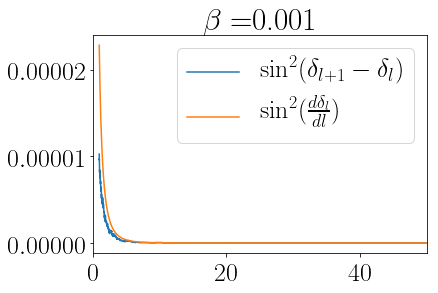

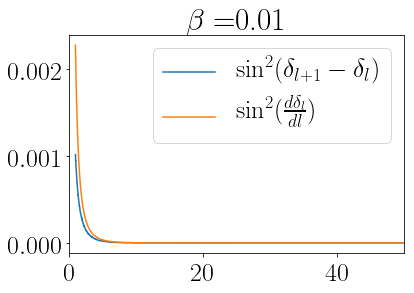

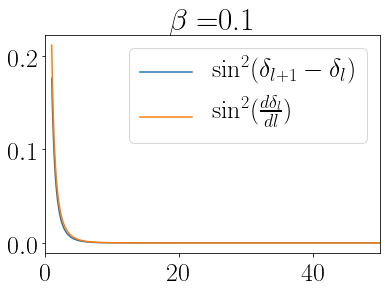

In [110]:
lvals = np.logspace(0,2,1000)
for beta in [0.001,0.01,0.1]:
    sin_deltal_vals = np.array([np.sin(deltalr0num_beta(l+1,beta)-deltalr0num_beta(l,beta))**2 for l in lvals])
    sin_ddeltal_vals = np.array([np.sin(ddeltal_approx(l,beta))**2 for l in lvals])
    
    
    pl.figure()
    #pl.plot(lvals, lsin_ddeltal_vals, '-', label=r'$l\,\mathrm{sin}^2\frac{d\delta_l}{dl}$')
    #pl.plot(lvals, l_ddeltal_vals, '-', label = r'$l\,\left(\frac{d\delta_l}{dl}\right)^2$')
    
    pl.plot(lvals, sin_deltal_vals, '-', label=r'$\mathrm{sin}^2(\delta_{l+1}-\delta_{l})$')
    pl.plot(lvals, sin_ddeltal_vals, '-', label = r'$\mathrm{sin}^2(\frac{d\delta_l}{dl})$')
    
    pl.legend(bbox_to_anchor = (1,1))
    #pl.ylim(0,100)
    #pl.ylim(0,2)
    pl.xlim(0,50)
    #pl.axhline(0.5, color='grey')
    pl.title(r'$\beta=$'+str(beta))
    pl.show()
    

## Plotting $|\delta_{l+1} - \delta_l|$ and $|\frac{d\delta_l}{dl}|$ with $l$

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


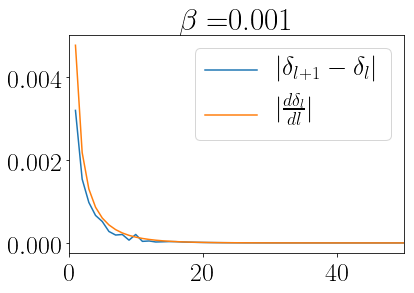

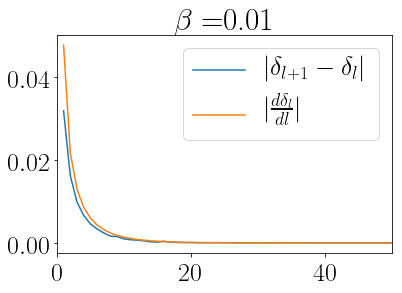

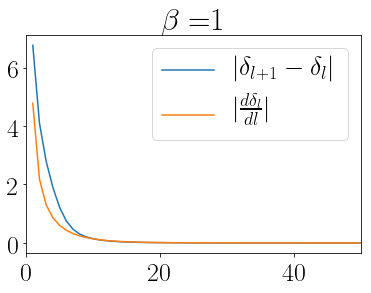

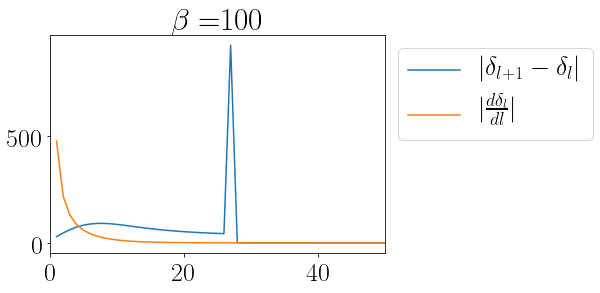

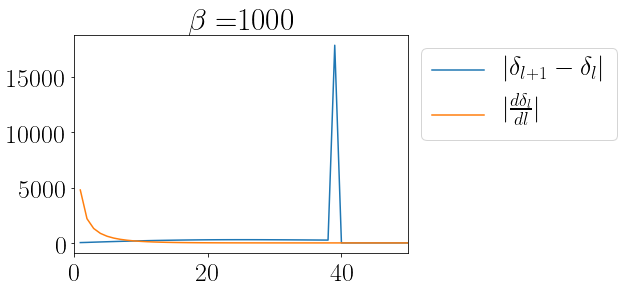

In [111]:
#lvals = np.logspace(0,2,1000)
lvals = range(1,100)
for beta in [0.001,0.01,1,100,1000]:
    deltal_difference_vals = np.array([abs(deltalr0num_beta(l+1,beta)-deltalr0num_beta(l,beta)) for l in lvals])
    ddeltal_vals = np.array([abs(ddeltal_approx(l,beta)) for l in lvals])
    
    
    pl.figure()
    
    pl.plot(lvals, deltal_difference_vals, label=r'$|\delta_{l+1}-\delta_{l}|$')
    pl.plot(lvals, ddeltal_vals, label=r'$|\frac{d\delta_l}{dl}|$')    
    
    pl.legend(bbox_to_anchor = (1,1))
    #pl.ylim(0,100)
    #pl.ylim(0,2)
    pl.xlim(0,50)
    #pl.yscale('log')
    pl.title(r'$\beta=$'+str(beta))
    pl.show()

## Scattering angle $\theta = \delta_l/l$
For small angles, scattering is almost never classical

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


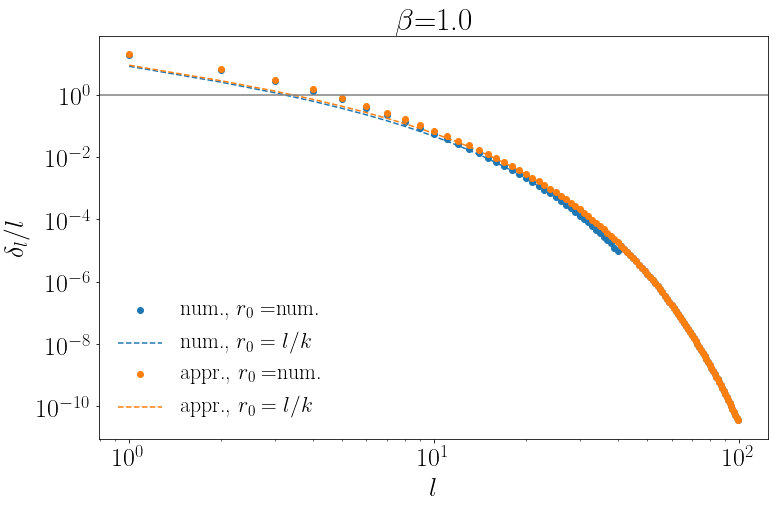

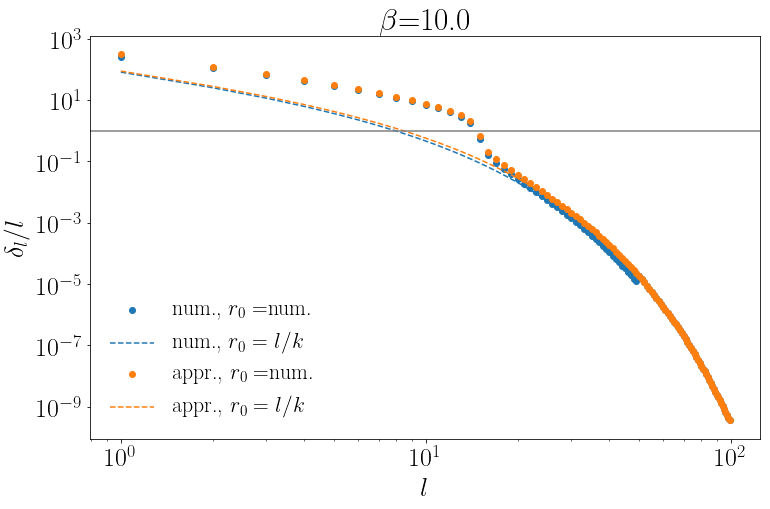

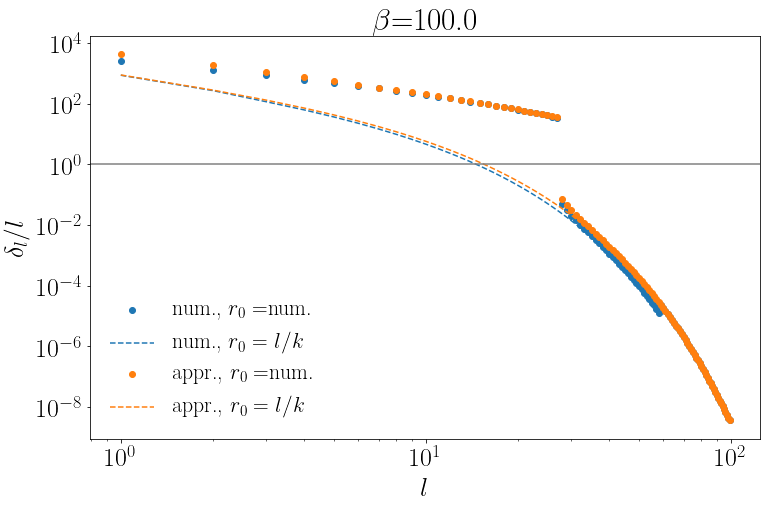

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


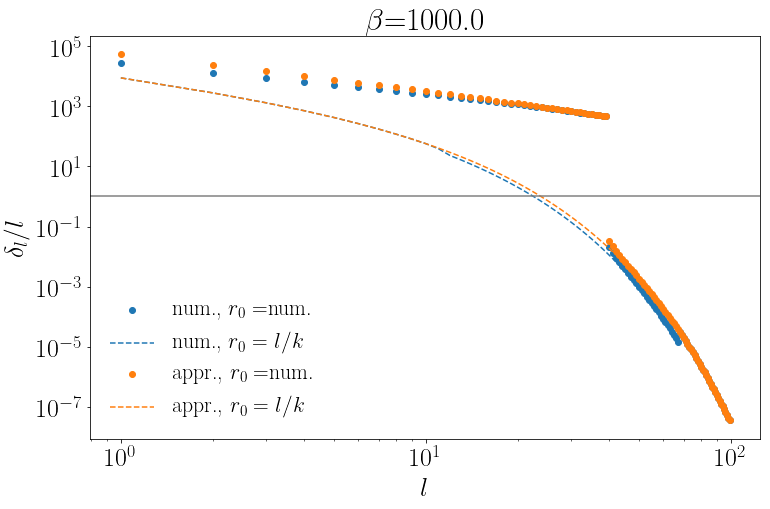

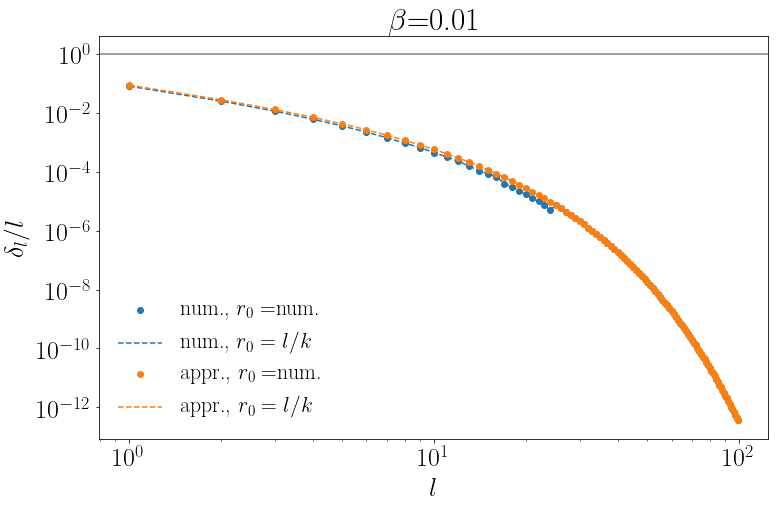

In [112]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)

for beta in [1.,10.,100.,1000.,0.01]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    deltalr0num_over_l_betavals=np.array([[l,deltalr0num_beta(l,beta)/l] for l in lvalsnew])
    pl.plot(deltalr0num_over_l_betavals[:,0],deltalr0num_over_l_betavals[:,1],'o',color='C0',label='num., $r_0=$num.')
    
    deltal_over_l_betavals=np.array([[l,deltal_beta(l,beta)/l] for l in lvalsnew])
    ##print(deltal_betavals)
    pl.plot(deltal_over_l_betavals[:,0],deltal_over_l_betavals[:,1],color='C0',linestyle='--',label='num., $r_0=l / k$')
    
    pl.plot(lvalsnew,[deltalapprr0num_beta(l,beta)/l for l in lvalsnew],'o',color='C1',label=r'appr., $r_0=$num.')
    
    pl.plot(lvalsnew,[deltalappr_beta(l,beta)/l for l in lvalsnew],color='C1',linestyle='--',label=r'appr., $r_0=l / k$')
   
    pl.xscale('log')
    pl.yscale('log')
    pl.axhline(1,color = 'grey')
    pl.xlabel(r'$l$',fontsize=fontsize)
    #pl.ylim([10.**(-3.),10.**5.])
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$\delta_{l}/l$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

In [113]:
from scipy.special import erf 
def lbreak_test(a,b):
    beta = 1/(2*a**2*b)
    return a*b*beta

def R0_patch2(a, b,l):
    beta = 1/(2*a**2*b)
    return (np.tanh((l-a*b*(1+np.log(beta/2)))/3) + 1)/2*l/(a*b) + l**2/(a*b)**2/beta*(np.tanh((a*b*(1+np.log(beta/2))-l)/3)+1)/2




def r0_analytic5(alphaX, mX, mphi, v, l):
    beta = 2*alphaX*mphi/(mX*v**2)
    cl = mX*v/mphi
    a = 1/(beta*cl)
    b = beta*cl**2/2
    m = mX/2
    k = m*v
    #print(lbreak_2(beta, cl))
    if l < lbreak_2(beta, cl) + np.sqrt(abs(lbreak_2(beta,cl))):
    #    if m*(m*alphaX**2 - 2*alphaX*l**2*mphi + l**2*m*v**2)<0:
    #        return l**2/(alphaX*m + np.sqrt(-m*(m*alphaX**2 - 2*alphaX*l**2*mphi + l**2*m*v**2))) #hack to ensure real results
    #    else:
    #        return l**2/(alphaX*m + np.sqrt(m*(m*alphaX**2 - 2*alphaX*l**2*mphi + l**2*m*v**2)))
        return (2*alphaX*mphi - m*v**2)/(3*alphaX*mphi**2) - (2**(1/3)*m*(2*alphaX**2*mphi**2 + 4*alphaX*m*mphi*v**2 - m**2*v**4))/(3*alphaX*mphi**2*(-20*alphaX**3*m**3*mphi**3 + 27*alphaX**2*l**2*m**2*mphi**4 - 6*alphaX**2*m**4*mphi**2*v**2 + 12*alphaX*m**5*mphi*v**4 - 2*m**6*v**6 + np.sqrt(4*m**6*(2*alphaX**2*mphi**2 + 4*alphaX*m*mphi*v**2 - m**2*v**4)**3 + (alphaX**2*m**2*mphi**3*(20*alphaX*m - 27*l**2*mphi) + 6*alphaX**2*m**4*mphi**2*v**2 - 12*alphaX*m**5*mphi*v**4 + 2*m**6*v**6)**2))**(1/3)) + (1/(3*2**(1/3)*alphaX*m*mphi**2))*((-20*alphaX**3*m**3*mphi**3 + 27*alphaX**2*l**2*m**2*mphi**4 - 6*alphaX**2*m**4*mphi**2*v**2 + 12*alphaX*m**5*mphi*v**4 - 2*m**6*v**6 + np.sqrt(4*m**6*(2*alphaX**2*mphi**2 + 4*alphaX*m*mphi*v**2 - m**2*v**4)**3 + (alphaX**2*m**2*mphi**3*(20*alphaX*m - 27*l**2*mphi) + 6*alphaX**2*m**4*mphi**2*v**2 - 12*alphaX*m**5*mphi*v**4 + 2*m**6*v**6)**2))**(1/3))
    elif lbreak_2(beta,cl) + np.sqrt(abs(lbreak_2(beta,cl))) <=l<= lbreak_2(beta,cl)+2*np.sqrt(abs(lbreak_2(beta,cl))):
    #if l <= lbreak_2(beta, cl):
        return r0_patch(beta,cl,l)
    elif l> lbreak_2(beta, cl)+2*np.sqrt(abs(lbreak_2(beta,cl))):
        return l/k 

In [114]:
def R0_patch3(alphaX, mX, mphi, v,l):
    a = v/c/(2*alphaX)
    b = alphaX*mX/mphi
    beta = 1/(2*a**2*b)
    m = mX/2
    #print(sol2)        
    #sol2 = l**2/(alphaX*m + np.sqrt(m*(m*alphaX**2 - 2*alphaX*l**2*mphi + l**2*m*(v/c)**2)))
    sol2 = 0.5*l**2/((a*b)**2*beta)
    #return (np.tanh((l-a*b*(1+np.log(beta/2)))/3) + 1)/2*l/(a*b) + sol2*(np.tanh((a*b*(1+np.log(beta/2))-l)/3)+1)/2
    return (np.tanh((l-a*b*(1+np.log(beta)))/3) + 1)/2*l/(a*b) + sol2*(np.tanh((a*b*(1+np.log(beta))-l)/3)+1)/2


R0_patch3(0.1, 50, 0.1, 0.02*c,100)

20.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


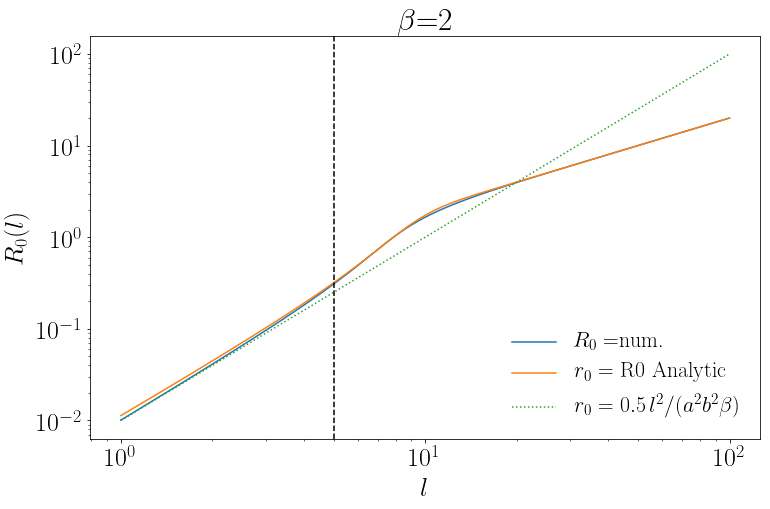

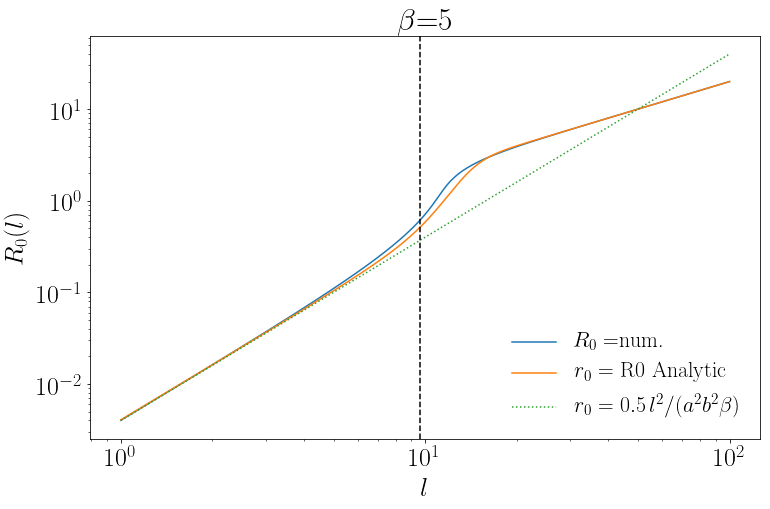

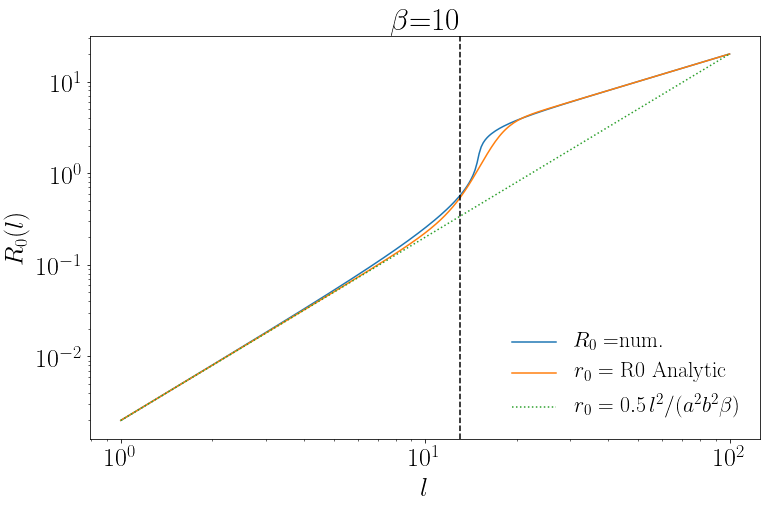

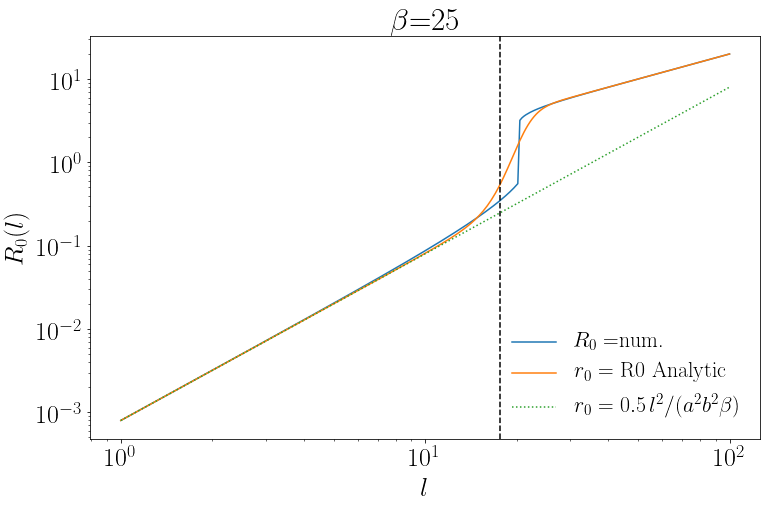

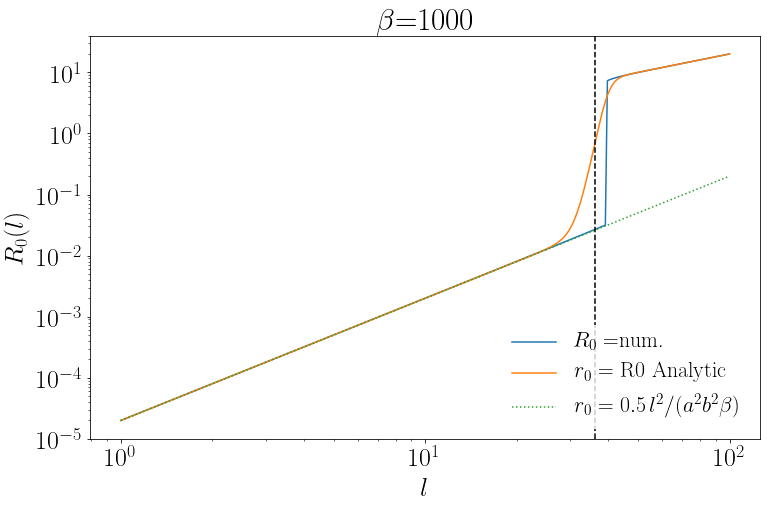

In [115]:
for beta in [2,5,10,25,1000]:
#print('beta='+str(beta))
    #for l in [30,35,40.]:
    #print('l='+str(l))
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX=50.*beta
    #print(mX)
    v=(0.02/beta)*c #km/s
    #print(v)
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    b = 0.1*50*beta/0.1
    a = 0.02/(2*0.1*beta)
    #r0appr=l/k
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    #lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
    lvalsnew=np.logspace(0,2,300)
    pl.plot(lvalsnew,[mphi*r0num(potential,alphaX,mX,mphi,l,v,logging=False) for l in lvalsnew],'-',label=r'$R_0=$num.')
    #pl.plot(lvalsnew,[mphi*l/k for l in lvalsnew],label=r'$r_0=l / k$',linestyle= '--')
    pl.plot(lvalsnew,[R0_patch3(alphaX, mX, mphi, v,l) for l in lvalsnew], label=r'$r_0 =$ R0 Analytic',linestyle='-')
    pl.plot(lvalsnew,[0.5*l**2/(a**2*b**2*beta) for l in lvalsnew], label=r'$r_0 = 0.5\,l^2/(a^2b^2\beta)$', linestyle=':')
    #pl.plot(lvalsnew,[mphi*r0_analytic(alphaX,mX,mphi,v/c,l) for l in lvalsnew], label=r'Analytical $R_0$')
    #pl.plot(lvalsnew,[r0_analytic4(alphaX,mX,mphi,v/c,l) for l in lvalsnew], label=r'Analytical $r_0$ (4)')
    #pl.plot(lvalsnew,[mphi*r0_analytic5(alphaX,mX,mphi,v/c,l) for l in lvalsnew], label=r'Analytical $R_0$ (5)')
    pl.xscale('log')
    pl.yscale('log')
    #pl.ylim(0.01,100)
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.ylabel(r'$R_{0}(l)$',fontsize=fontsize)
    #pl.ylim([10.**(-5.),10.**5.])
    #pl.axhline(k**2, label=r'$k^2$', color = 'black')
    #pl.axvline(a*b*beta, color = 'black')
    pl.axvline(a*b*(1+np.log(beta/2)), linestyle='--', color = 'black')
    pl.legend(loc='lower right',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta))
    pl.show()
    

In [12]:
def R0_full(a,b,l):
    beta = 1/(2*a**2*b)
    if beta <= 10:
        return (np.tanh((l-a*b*(1+np.log(beta)))/3) + 1)/2*l/(a*b) + l**2/((a*b)**2*2*beta)*(np.tanh((a*b*(1+np.log(beta))-l)/3)+1)/2
    else:
        if l <= a*b*(1 + np.log(beta)):
            return l**2/((a*b)**2*2*beta)
        else:
            return l/(a*b)


In [115]:
def R0_full_test(a,b,l):
    beta = 1/(2*a**2*b)
    if beta <= 10:
        return (erf((l-a*b*(1+np.log(beta)))/(a*b)) + 1)/2*l/(a*b) + l**2/((a*b)**2*2*beta)*(erf((a*b*(1+np.log(beta))-l)/(a*b))+1)/2
    else:
        if l <= a*b*(1 + np.log(beta)):
            return l**2/((a*b)**2*2*beta)
        else:
            return l/(a*b)

In [24]:
def R0_full2(a,b,l):
    beta = 1/(2*a**2*b)
    cl = 2*a*b
    if l <= a*b*(1 + np.log(beta)):
        if (l/(a*b))**2 <= beta:
            return l**2/((a*b)**2*2*beta)
        else:
        return l**2/((a*b)**2*2*beta)
    else:
        if l <= a*b*(1 + np.log(beta)):
            return l**2/((a*b)**2*2*beta)
        else:
            return l/(a*b)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


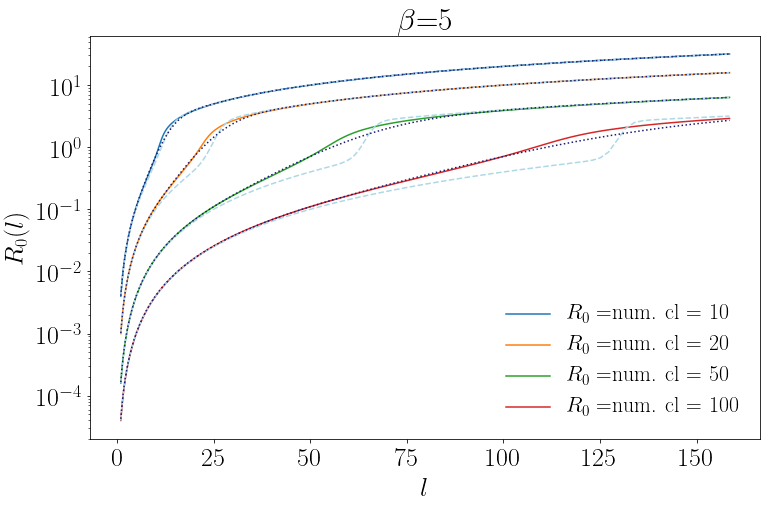

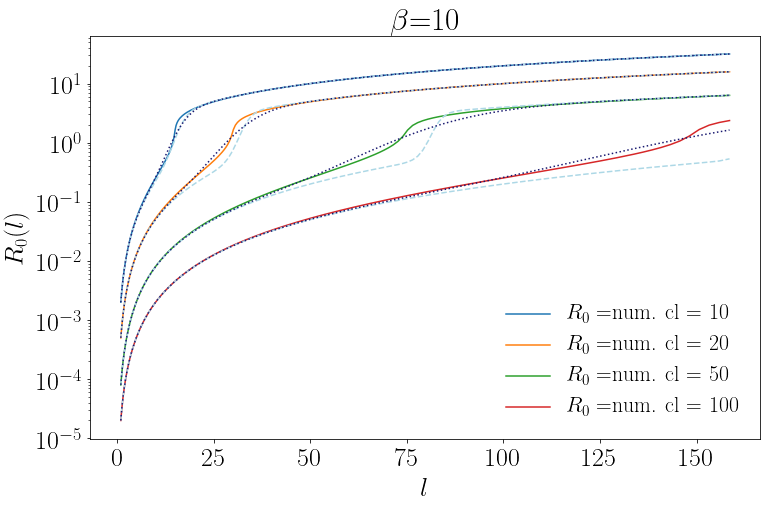

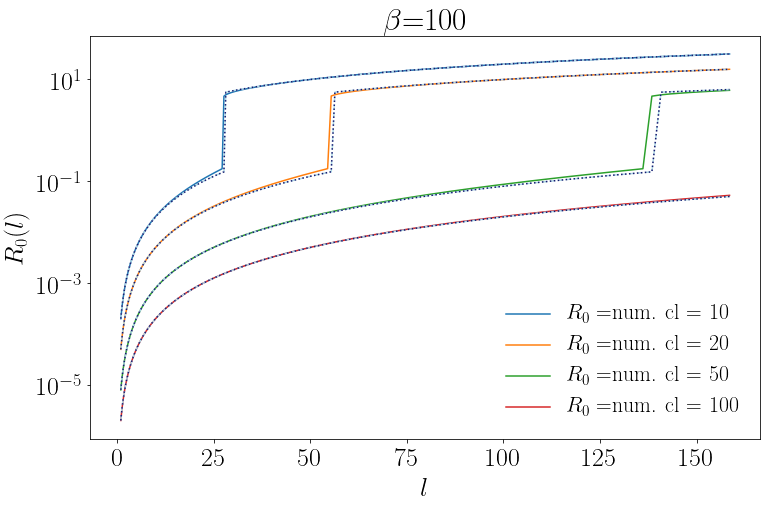

In [122]:
#for beta in [0.0001,0.1,2,10,20,100,1000]:
for beta in [5,10,100]:
#print('beta='+str(beta))
    #for l in [30,35,40.]:
    #print('l='+str(l))
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    #lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
    lvalsnew=np.logspace(0,2.2,300)
    #_____Fixed parameters_____
    for cl in [10,20,50,100]:
        potential='attractive'
        a = 1/(beta*cl)
        b = cl**2*beta/2
        mphi=0.1 #GeV.
        alphaX = 0.1
        mX= cl**2*beta/2
        v = 0.2/(beta*cl)*c

    #_____Relations_____
        m=(mX/2.)  #reduced mass m
        p=m*(v/c) #momentum p
        k=p/hbar

    
        pl.plot(lvalsnew,[mphi*r0num(potential,alphaX,mX,mphi,l,v,logging=False) for l in lvalsnew],'-',label=r'$R_0=$num. cl = '+str(cl))
        #pl.plot(lvalsnew,[l**2/((a*b)**2*(2*beta)) for l in lvalsnew], '--', label = r'$l^2/(ab)^2 1/2\beta$')
        #pl.plot(lvalsnew, [l/(a*b) for l in lvalsnew], '--', label = r'$l/k$')
        #pl.plot(lvalsnew,[R0_full2(a,b,l) for l in lvalsnew], '--', label = r'$R_0 \,(2)$')
        pl.plot(lvalsnew,[R0_full(a,b,l) for l in lvalsnew], linestyle='--', color = 'lightblue')
        pl.plot(lvalsnew,[R0_full_test(a,b,l) for l in lvalsnew], linestyle=':', color = 'midnightblue')
    

    #pl.xscale('log')
    pl.yscale('log')
    #pl.ylim(0.01,100)
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.ylabel(r'$R_{0}(l)$',fontsize=fontsize)
    #pl.ylim([10.**(-5.),10.**5.])
    #pl.axhline(k**2, label=r'$k^2$', color = 'black')
    #pl.axvline(a*b*beta, color = 'black')
    #pl.axvline(a*b*(1+np.log(beta)), linestyle='--', color = 'black')
    pl.legend(loc='lower right',edgecolor='white',fontsize=legendfontsize) 
    #pl.axvline(13.047189562170502, color = 'grey', linestyle=':')
    #pl.axvline(26.094379124341003, color = 'grey', linestyle=':')
    #pl.axvline(65.23594781085251, color = 'grey', linestyle=':')
    #pl.axvline(130.47189562170502, color = 'grey', linestyle=':')
    pl.title(r'$\beta$='+str(beta))
    pl.show()
    

In [58]:
for cl in [10,20,50,100]:
    print(lbreak(5, cl))


13.047189562170502
26.094379124341003
65.23594781085251
130.47189562170502


In [81]:
from scipy.special import erf

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


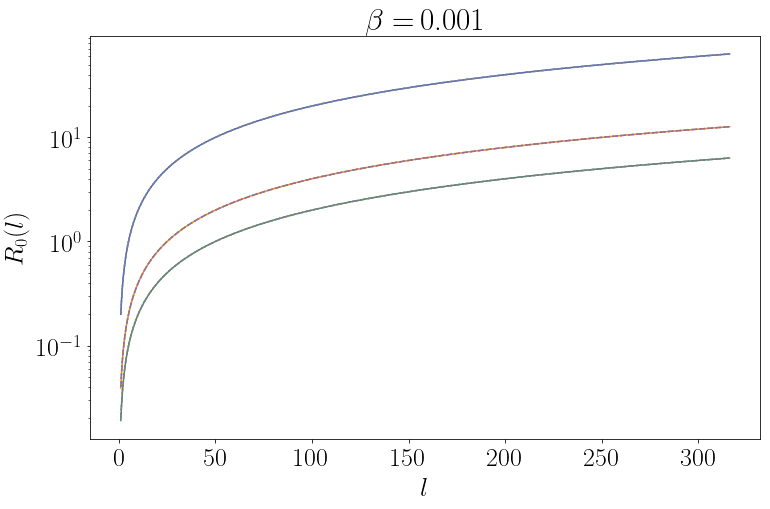

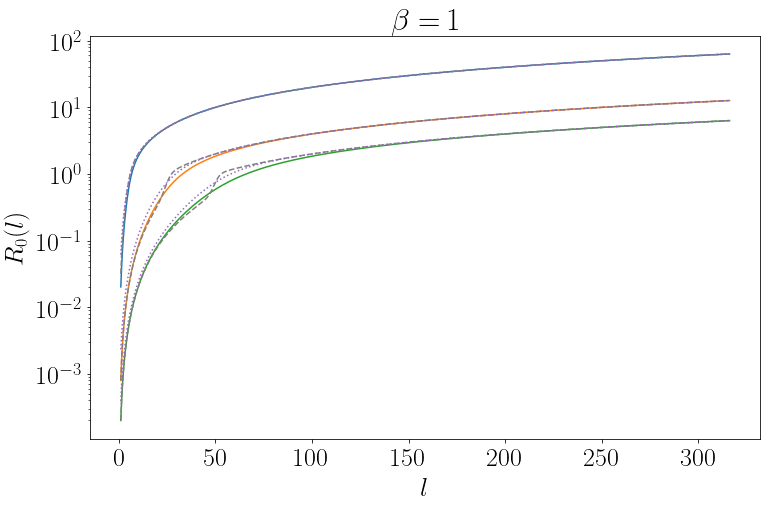

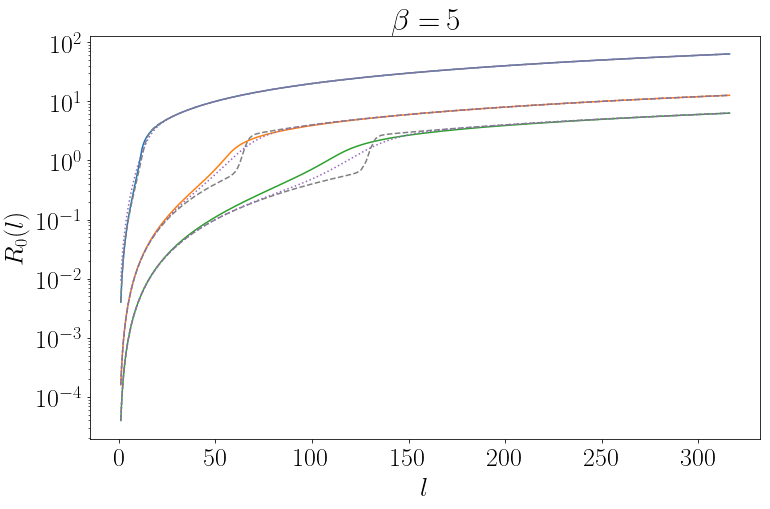

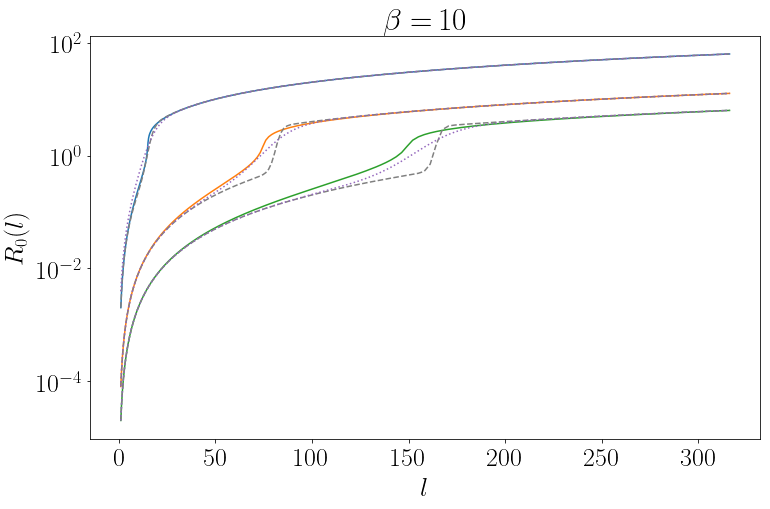

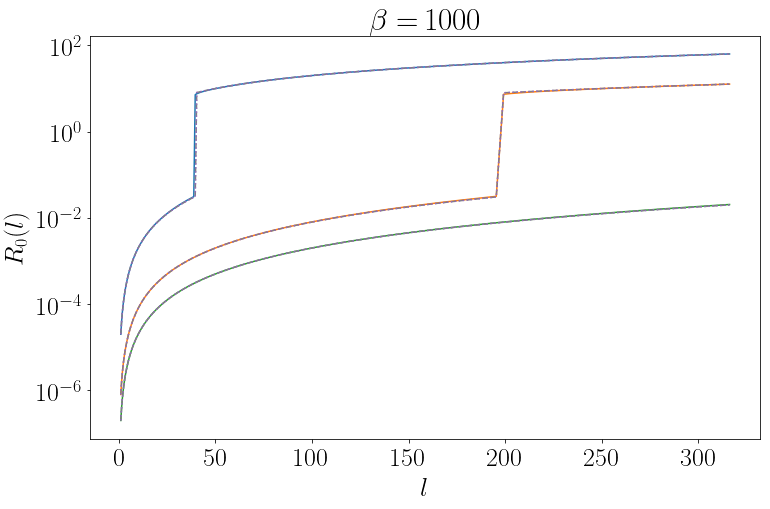

In [241]:

def R0_full_test(a,b,l):
    beta = 1/(2*a**2*b)
    num= 1
    den = 3*(a*b)**0.5
    if beta <= 10:
        return (np.tanh((l-a*b*(1+np.log(beta)))*num/(den))+1)/2*l/(a*b) + l**2/((a*b)**2*2*beta)*(np.tanh((a*b*(1+np.log(beta))-l)*num/(den))+1)/2
    else:
        if l <= a*b*(1 + np.log(beta)):
            return l**2/((a*b)**2*2*beta)
        else:
            return l/(a*b)
for beta in [0.001,1,5, 10,1000]:
#print('beta='+str(beta))
    #for l in [30,35,40.]:
    #print('l='+str(l))
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    #lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
    lvalsnew=np.logspace(0,2.5,300)
    #_____Fixed parameters_____
    for cl in [10, 50,100]:
        potential='attractive'
        a = 1/(beta*cl)
        b = cl**2*beta/2
        mphi=0.1 #GeV.
        alphaX = 0.1
        mX= cl**2*beta/2
        v = 0.2/(beta*cl)*c

    #_____Relations_____
        m=(mX/2.)  #reduced mass m
        p=m*(v/c) #momentum p
        k=p/hbar
        pl.plot(lvalsnew,[mphi*r0num(potential,alphaX,mX,mphi,l,v,logging=False) for l in lvalsnew],'-',label=r'$R_0=$num. cl = '+str(cl))
        pl.plot(lvalsnew, [R0_full(a,b,l) for l in lvalsnew], linestyle='--', color = 'grey')
        pl.plot(lvalsnew, [R0_full_test(a,b,l) for l in lvalsnew], linestyle = ':', color = 'C4')
        #print(3*(a*b)**0.5)
    pl.yscale('log')
    #pl.ylim(0.01,100)
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.ylabel(r'$R_{0}(l)$',fontsize=fontsize)
    pl.title(r'$\beta=\,$'+str(beta))
    pl.show()